# Analysis of f$_{NL}$ with DESI LRGs

This notebook will include snippets regarding the fNL project with DESI Imaging.

In [1]:
!qstat -u medirz90


o0053.ten.osc.edu:
                                                                               Req'd  Req'd   Elap 
Job id               Username Queue    Name                 SessID NDS   TSK   Memory Time Use S Time 
-------------------- -------- -------- -------------------- ------ ----- ----- ------ ----- - -----
20930258             medirz90 serial   ondemand/sys/dashboa --         1     2     -- 01:00 C 01:00
20930280             medirz90 serial   ondemand/sys/dashboa --         1     2     -- 01:00 C 01:00
20930541             medirz90 serial   ondemand/sys/dashboa --         1     2     -- 01:00 R 00:04


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import numpy as np
import fitsio as ft
import healpy as hp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import getdist

from getdist import plots, MCSamples
from glob import glob

sys.path.insert(0, '/users/PHS0336/medirz90/github/LSSutils')
import lssutils.utils as ut
import lssutils.dataviz as dv
from lssutils.io import read_nnbar, read_nbmocks, read_chain
from lssutils.stats.pcc import pcc

class MCMC(MCSamples):
     def __init__(self, path_to_mcmc, read_kw=dict(), mc_kw=dict()):
        self.stats, chains = read_chain(path_to_mcmc, **read_kw)
        MCSamples.__init__(self, samples=chains, **mc_kw)
        

def read_clx(fn, bins=None):

    cl = np.load(fn, allow_pickle=True).item()
    
    cl_cross = []
    cl_ss = []

    for i in range(len(cl['cl_sg'])):    
        __, cl_sg_ = ut.histogram_cell(cl['cl_sg'][i]['l'], cl['cl_sg'][i]['cl'], bins=bins)
        __, cl_ss_ = ut.histogram_cell(cl['cl_ss'][i]['l'], cl['cl_ss'][i]['cl'], bins=bins)

        cl_ss.append(cl_ss_)
        cl_cross.append(cl_sg_**2/cl_ss_)    

    return np.array(cl_cross).flatten()


def read_clxmocks(list_clx, bins=None):
    
    err_mat = []    
    for i, clx_i in enumerate(list_clx):
        
        err_i  = read_clx(clx_i, bins=bins)
        err_mat.append(err_i)
        
        if (i % (len(list_clx)//10)) == 0:
            print(f'{i}/{len(list_clx)}')

    err_mat = np.array(err_mat)
    print(err_mat.shape)
    return err_mat

def combine_nn(maps, output):
    
    hpmap = np.zeros(12*256*256)
    counts = np.zeros(12*256*256)
    for map_ in maps:
        d_ = ft.read(map_)
        counts[d_['hpix']] += 1.0
        hpmap[d_['hpix']] += d_['weight'].mean(axis=1)

    hpmap = hpmap / counts
    hpmap[~(counts > 0.0)] = hp.UNSEEN
    hp.write_map(output, hpmap, fits_IDL=False)
    print(f'wrote {output}')        

In [4]:
%matplotlib inline

In [5]:
dv.setup_color()

## Cleaned data
First we prepare the data into `hpix`, `features`, `label`, and `fracgood`.

Text(0, 0.5, 'sin(DEC [deg])')

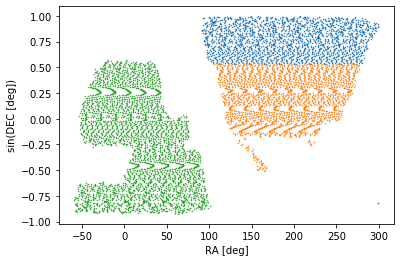

In [4]:
for r in ['bmzls', 'ndecals', 'sdecals']:
    
    table = f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{r}_256.fits'
    dt = ft.read(table)
    
    ra, dec = ut.hpix2radec(256, dt['hpix'])
    plt.scatter(ut.shiftra(ra[::50]), np.sin(np.radians(dec[::50])), 1, marker='.')
    
plt.xlabel('RA [deg]')
plt.ylabel('sin(DEC [deg])')

Now, let's combine BASS/MzLS with DECaLS North into NGC

In [5]:
bmzls = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')
ndecals = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_ndecals_256.fits')

common = np.intersect1d(bmzls['hpix'], ndecals['hpix'])
ngc = np.concatenate([bmzls, ndecals])

mask_comm = np.in1d(ngc['hpix'], common)
ngc_comm = ngc[mask_comm]
ngc_comm = np.sort(ngc_comm, order='hpix')
commons = np.zeros(common.size, dtype=ngc_comm.dtype)

for key in commons.dtype.names:
    
    if key=='hpix':
        commons[key] = ngc_comm[key][:-1:2]
    elif key in ['label', 'fracgood']:
        commons[key] = (ngc_comm[key][:-1:2]+ngc_comm[key][1::2])
    elif key=='features':
        commons[key] = (ngc_comm[key][:-1:2]+ngc_comm[key][1::2]) / 2.0
    else:
        print(key)
        
ngc_unique = ngc[~mask_comm]
combined = np.concatenate([ngc_unique, commons])
assert ngc.size ==2*commons.size+ngc_unique.size        

ft.write('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_ngc_256.fits', combined)


# Combine NGC and DECaLS S into desi
ngc = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_ngc_256.fits')
sdecals = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_sdecals_256.fits')

common = np.intersect1d(sdecals['hpix'], ngc['hpix'])
assert len(common) == 0
desi = np.concatenate([ngc, sdecals])

ft.write('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_desi_256.fits', desi)

In [13]:
# Combine DECaLS N and DECaLS S into DECaLS
ndecals = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_ndecals_256.fits')
sdecals = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_sdecals_256.fits')

common = np.intersect1d(sdecals['hpix'], ndecals['hpix'])
assert len(common) == 0
decals = np.concatenate([ndecals, sdecals])

ft.write('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_decals_256.fits', decals)

In [5]:
ls /fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/ -altr

total 138817
drwxr-xr-x+ 9 medirz90 PHS0336     4096 Sep 12 11:07 ../
-rw-rw-r--+ 1 medirz90 PHS0336  9417600 Sep 12 17:12 nlrg_features_bmzls_256.fits
-rw-rw-r--+ 1 medirz90 PHS0336 10892160 Sep 12 17:12 nlrg_features_ndecals_256.fits
-rw-rw-r--+ 1 medirz90 PHS0336 16421760 Sep 12 17:12 nlrg_features_sdecals_256.fits
-rw-rw-r--+ 1 medirz90 PHS0336 20255040 Sep 12 17:21 nlrg_features_ngc_256.fits
-rw-rw-r--+ 1 medirz90 PHS0336 36668160 Sep 12 17:21 nlrg_features_desi_256.fits
-rw-rw-r--+ 1 medirz90 PHS0336 27305280 Sep 12 17:29 nlrg_features_decals_256.fits
-rw-rw-r--+ 1 medirz90 PHS0336 10609920 Oct  7 20:49 nlrg_features_ndecalsc_256.fits
drwxrwxr-x+ 2 medirz90 PHS0336     4096 Oct  7 20:52 ./
-rw-rw-r--+ 1 medirz90 PHS0336 10517760 Oct  7 20:52 nlrg_features_sdecalsc_256.fits


In [6]:
bmzls = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')
ndecals = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_ndecalsc_256.fits')

common = np.intersect1d(bmzls['hpix'], ndecals['hpix'])
ngc = np.concatenate([bmzls, ndecals])

mask_comm = np.in1d(ngc['hpix'], common)
ngc_comm = ngc[mask_comm]
ngc_comm = np.sort(ngc_comm, order='hpix')
commons = np.zeros(common.size, dtype=ngc_comm.dtype)

for key in commons.dtype.names:
    
    if key=='hpix':
        commons[key] = ngc_comm[key][:-1:2]
    elif key in ['label', 'fracgood']:
        commons[key] = (ngc_comm[key][:-1:2]+ngc_comm[key][1::2])
    elif key=='features':
        commons[key] = (ngc_comm[key][:-1:2]+ngc_comm[key][1::2]) / 2.0
    else:
        print(key)
        
ngc_unique = ngc[~mask_comm]
combined = np.concatenate([ngc_unique, commons])
assert ngc.size ==2*commons.size+ngc_unique.size        

ft.write('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_ngcc_256.fits', combined)


# Combine NGC and DECaLS S into desi
ngc = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_ngcc_256.fits')
sdecals = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_sdecalsc_256.fits')

common = np.intersect1d(sdecals['hpix'], ngc['hpix'])
assert len(common) == 0
desi = np.concatenate([ngc, sdecals])

ft.write('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_desic_256.fits', desi)

## Target Density

804.7442846363949


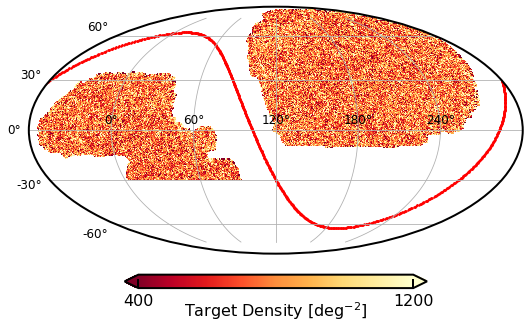

In [15]:
desi = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_desic_256.fits')
ng  = ut.make_hp(256, desi['hpix'], desi['label']/(desi['fracgood']*hp.nside2pixarea(256, True)), np.inf)
print(np.mean(ng[desi['hpix']]))

dv.mollview(ng, 400, 1200, r'Target Density [deg$^{-2}$]', 
        cmap='YlOrRd_r', colorbar=True, galaxy=True)
plt.savefig(f'/users/PHS0336/medirz90/github/dimagfnl/figures/lrgdens.pdf', bbox_inches='tight')

## Selection Functions

In [7]:
# everything
maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzls_256_known1/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecals_256_known1/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecals_256_known1/nn-weights.fits']
combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desi_known1.hp256.fits')

wrote /fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desi_known1.hp256.fits


/tmp/slurmtmp.20925985/ipykernel_4234/674072037.py:66: RuntimeWarning: invalid value encountered in true_divide
  hpmap = hpmap / counts


In [6]:
# w dec cuts
maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzls_256_known1/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecalsc_256_known1/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecalsc_256_known1/nn-weights.fits']

combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known1.hp256.fits')

wrote /fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known1.hp256.fits


/tmp/slurmtmp.20900451/ipykernel_10669/3419441414.py:10: RuntimeWarning: invalid value encountered in true_divide
  hpmap = hpmap / counts
/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:184: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(


In [ ]:
maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzls_256_known2/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecalsc_256_known2/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecalsc_256_known2/nn-weights.fits']
#print(maps)
combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known2.hp256.fits')

In [7]:
hp_known = hp.read_map('/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/linp_lrg_desic_known.hp256.fits')
hp_known1 = hp.read_map('/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/linp_lrg_desic_known1.hp256.fits')
hp_all = hp.read_map('/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/linp_lrg_desic_all.hp256.fits')
hp_nknown1 = hp.read_map('/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known1.hp256.fits')

/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [8]:
sf = hp.nside2pixarea(256, True)

In [9]:
for hp_i in [hp_all, hp_known, hp_known1, hp_nknown1]:
    is_g = hp_i != hp.UNSEEN
    print(np.percentile(hp_i[is_g]/sf, [1, 99]))

[762.85281187 882.96767244]
[768.70877619 872.53061009]
[765.42592846 876.23243794]
[760.62626899 884.85135114]


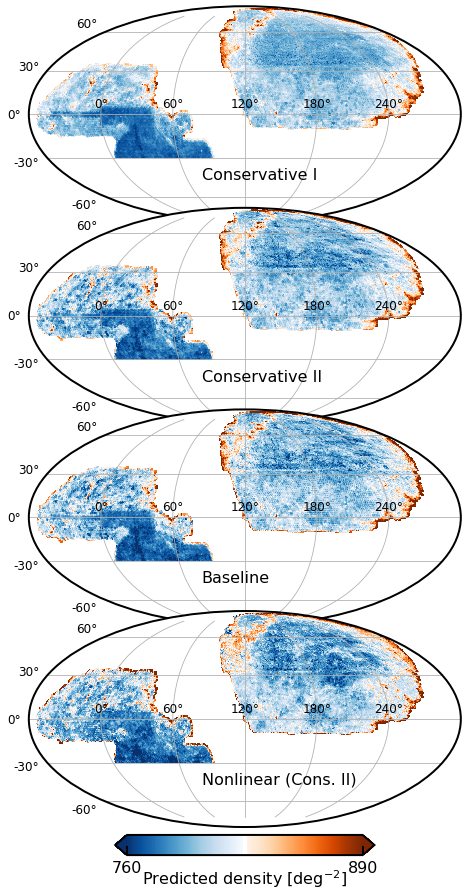

In [16]:
fig = plt.figure(figsize=(6, 7))

ax0  = fig.add_axes([0., 1.,  1., 1], projection='mollweide')
ax1  = fig.add_axes([0,  0.6, 1., 1],  projection='mollweide')
ax2  = fig.add_axes([0., 0.2, 1., 1],  projection='mollweide')
ax3  = fig.add_axes([0., -0.2, 1., 1], projection='mollweide')

kw = {'vmin':760., 'vmax':890., 'cmap':dv.mycolor(), 'in_deg':True}
dv.mollview(hp_known,  figax=[fig, ax0], **kw)
dv.mollview(hp_known1, figax=[fig, ax1], **kw)
dv.mollview(hp_all,    figax=[fig, ax2], **kw)
dv.mollview(hp_nknown1, figax=[fig, ax3], 
            colorbar=True, galaxy=False, unit=r'Predicted density [deg$^{-2}$]', **kw)

for ni, axi in zip(['Conservative I', 'Conservative II', 'Baseline', 'Nonlinear (Cons. II)'], 
                                  [ax0, ax1, ax2, ax3]):
    axi.text(0.4, 0.2, ni, transform=axi.transAxes)
    
fig.savefig(f'/users/PHS0336/medirz90/github/dimagfnl/figures/npred.pdf', bbox_inches='tight')

Pearson Correlation Coefficient

In [6]:
pccs = {}
for region in ['bmzls', 'ndecalsc', 'sdecalsc']:
    d_ = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{region}_256.fits')
    y_ = pcc(d_['features'], d_['label']/d_['fracgood'], kind='pearson')
    
    mocks = glob(f'/fs/ess/PHS0336/data/lognormal/v3/hpmaps/lrghp-zero-*-f1z1.fits')[::10]
    print(len(mocks))
    ym_ = []
    for mock in mocks:
        dm_ = hp.read_map(mock, verbose=False)
        ym_.append(pcc(d_['features'], dm_[d_['hpix']], kind='pearson'))
        
    pccs[region] = y_, np.array(ym_)
    print(region, 'done')

100


/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


bmzls done
100
ndecalsc done
100
sdecalsc done


(100, 9) 9
(100, 9) 9
(100, 9) 9


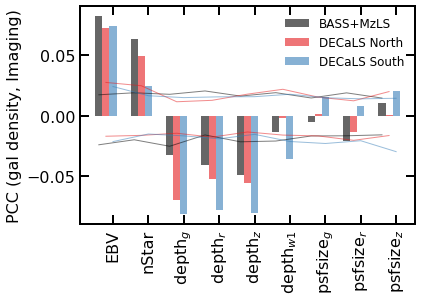

In [7]:
colors = ['C0', 'C1', 'C2']
names = [r'EBV', r'nStar']+[fr'depth$_{b}$' for b in ['g', 'r', 'z', '{w1}']]\
        + [fr'psfsize$_{b}$' for b in ['g', 'r', 'z']]
 
for i, (region, name) in enumerate(zip(['bmzls', 'ndecalsc', 'sdecalsc'],
                                      ['BASS+MzLS', 'DECaLS North', 'DECaLS South'])):
    p_, er_ = pccs[region]
    
    pcc_ = p_[0]
    err_ = er_[:, 0, :]
    print(err_.shape, len(pcc_))
    pcc_min, pcc_max = np.percentile(err_, [0, 100], axis=0)

    x = np.arange(len(pcc_))+i*0.2
    plt.bar(x, pcc_, width=0.2, alpha=0.6, color=colors[i], label=name)
    plt.plot(x, pcc_min, ls='-', lw=1, color=colors[i], alpha=0.5)
    plt.plot(x, pcc_max, ls='-', lw=1, color=colors[i], alpha=0.5)

plt.xticks(x, names, rotation=90)
plt.ylabel('PCC (gal density, Imaging)')
plt.legend()
plt.savefig(f'/users/PHS0336/medirz90/github/dimagfnl/figures/pcc.pdf', bbox_inches='tight')

Pearson Correlation Coefficient

In [19]:
desi = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_desic_256.fits')

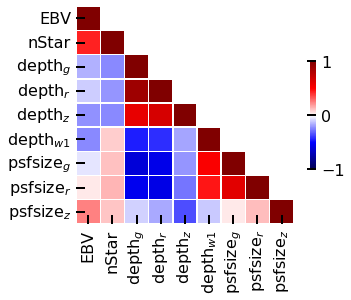

In [21]:
names = [r'EBV', r'nStar']+[fr'depth$_{b}$' for b in ['g', 'r', 'z', '{w1}']]\
        + [fr'psfsize$_{b}$' for b in ['g', 'r', 'z']]

d = pd.DataFrame(data=desi['features'], columns=names)
corr_cf = d.corr()
mask = np.ones_like(corr_cf, dtype=np.bool)
mask[np.tril_indices_from(mask)] = False
f, ax = plt.subplots(figsize=(6, 4))
kw = dict(mask=mask, cmap=plt.cm.seismic, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(corr_cf, **kw)
ax.yaxis.set_tick_params(right=False)
ax.xaxis.set_tick_params(top=False)
plt.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/pccx.pdf', bbox_inches='tight')
plt.show()

## Cross Power

In [8]:
ell_edges = ut.ell_edges[:10]
ell_edges

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])

In [9]:
p = '/fs/ess/PHS0336/data/lognormal/v3/clustering/'

err_0 = read_clxmocks(glob(f'{p}clmock_0_*_lrg_zero_desic_256_noweight.npy'),
                        ell_edges)
err_100 = read_clxmocks(glob(f'{p}clmock_0_*_lrg_po100_desic_256_noweight.npy'),
                        ell_edges)

chi2s = {}
chi2s['fNL=0'] = ut.get_chi2pdf(err_0)
chi2s['fNL=100'] = ut.get_chi2pdf(err_100)

0/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
(1000, 81)
0/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
(1000, 81)
nmocks: 1000, nbins: 81
nmocks: 1000, nbins: 81


In [10]:
err_dr9 = read_clx('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_desic_256_noweight.npy', ell_edges)
err_dr9all = read_clx('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_desic_256_linp_all.npy', ell_edges)
err_dr9known = read_clx('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_desic_256_linp_known.npy', ell_edges)
err_dr9known1 = read_clx('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_desic_256_linp_known1.npy', ell_edges)
err_dr9nknown1 = read_clx('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_desic_256_dnnp_known1.npy', ell_edges)

icov, cov_0 = ut.get_inv(err_0, return_cov=True)
cov_100 = ut.get_inv(err_100, return_cov=True)[1]

chi2_dr9 = ut.chi2_fn(err_dr9, icov)
chi2_dr9all = ut.chi2_fn(err_dr9all, icov)
chi2_dr9known = ut.chi2_fn(err_dr9known, icov)
chi2_dr9known1 = ut.chi2_fn(err_dr9known1, icov)
chi2_dr9nknown1 = ut.chi2_fn(err_dr9nknown1, icov)

ell_edges

Hartlap factor: 1.089422028353326
with nmocks: 1000 and nbins: 81
Hartlap factor: 1.089422028353326
with nmocks: 1000 and nbins: 81


array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])

In [11]:
names = ['EBV',
 'STARDENS',
 'GALDEPTH_G',
 'GALDEPTH_R',
 'GALDEPTH_Z',
 'PSFDEPTH_W1',
 'PSFSIZE_G',
 'PSFSIZE_R',
 'PSFSIZE_Z']

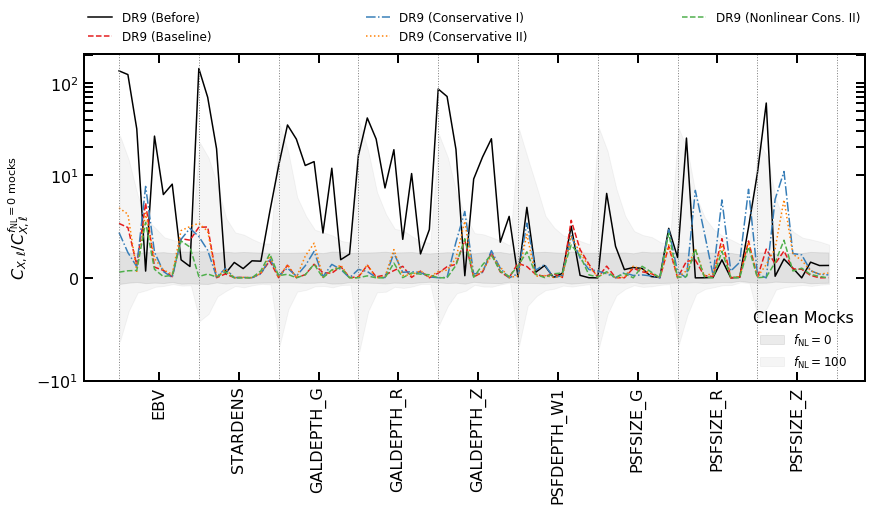

In [12]:
fg, ax = plt.subplots(sharex=True, figsize=(14, 6))
fg.subplots_adjust(hspace=0.)

err_0m = err_0.mean(axis=0)
err_100m = err_100.mean(axis=0)

ell_b = np.arange(err_0m.size)
err_0e = np.diagonal(cov_0)**0.5
err_100e = np.diagonal(cov_100)**0.5


ln1 = ax.fill_between(ell_b, 1.-(err_0e/err_0m), 1.+(err_0e/err_0m),  label=r'$f_{\rm NL}=0$', color='k', alpha=0.08)
ln2 = ax.fill_between(ell_b+0.1, (err_100m-err_100e)/err_0m, (err_100m+err_100e)/err_0m, label=r'$f_{\rm NL}=100$', color='k', alpha=0.04)
lgn1 = plt.legend(handles=[ln1, ln2], loc='lower right', title='Clean Mocks')

kw = dict()
ln3, = ax.plot(ell_b, err_dr9/err_0m,      label='DR9 (Before)', )
ln4, = ax.plot(ell_b, err_dr9all/err_0m,    label='DR9 (Baseline)')
ln5, = ax.plot(ell_b, err_dr9known/err_0m,  label='DR9 (Conservative I)')
ln6, = ax.plot(ell_b, err_dr9known1/err_0m, label='DR9 (Conservative II)')
ln7, = ax.plot(ell_b, err_dr9nknown1/err_0m, label='DR9 (Nonlinear Cons. II)')
ax.legend(handles=[ln3, ln4, ln5, ln6, ln7], 
             bbox_to_anchor=(0, 1.02, 1, 0.4), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, frameon=False)

plt.gca().add_artist(lgn1)
ax.set_yscale('symlog', linthreshy=10)
ax.set_yticks([-10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200])

# ax.set_xlabel(r'$\ell$ bin index')
ax.set_ylabel(r'$C_{X, \ell}/C_{X, \ell}^{f_{\rm NL}=0~{\rm mocks}}$')
for xt in np.arange(0, 82, 9):
    ax.axvline(xt, ls=':', lw=1, color='grey')
ax.set_xticks([4.5+i*9 for i in range(len(names))])
ax.set_xticklabels(names, rotation=90)

fg.savefig(f'/users/PHS0336/medirz90/github/dimagfnl/figures/clx_mocks.pdf', bbox_inches='tight')

452.51439036526654 12.73599146545597
532.0629408864258 16.211484375059015


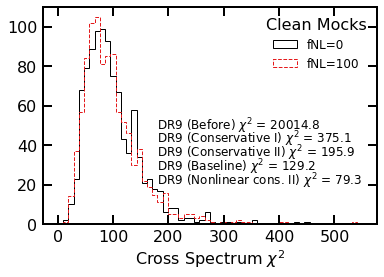

In [13]:
ls = ['-', '--']

for i, (name_i, chi2_i) in enumerate(chi2s.items()):
    print(np.max(chi2_i), np.min(chi2_i))
    plt.hist(chi2_i, histtype='step', bins=58, ls=ls[i],
             label=name_i, range=(0, 550.))    
# plt.yscale('log')

plt.text(180., 48., f'DR9 (Before) $\chi^{2}$ = {chi2_dr9:.1f}', fontsize=12)
plt.text(180., 41., f'DR9 (Conservative I) $\chi^{2}$ = {chi2_dr9known:.1f}', fontsize=12)
plt.text(180., 34., f'DR9 (Conservative II) $\chi^{2}$ = {chi2_dr9known1:.1f}', fontsize=12)
plt.text(180., 27., f'DR9 (Baseline) $\chi^{2}$ = {chi2_dr9all:.1f}', fontsize=12)
plt.text(180., 20., f'DR9 (Nonlinear cons. II) $\chi^{2}$ = {chi2_dr9nknown1:.1f}', fontsize=12)
# plt.yscale('log')
plt.xticks([0, 100, 200, 300, 400, 500])
plt.legend(title='Clean Mocks', frameon=False)
plt.xlabel(r'Cross Spectrum $\chi^{2}$')
plt.savefig(f'/users/PHS0336/medirz90/github/dimagfnl/figures/chi2test.pdf', bbox_inches='tight')

## make histogram of mean density contrast

In [15]:
err_0 = read_nbmocks(glob('/fs/ess/PHS0336/data/lognormal/v3/clustering/nbarmock_0_*_lrg_zero_desic_256_noweight.npy'))
err_100 = read_nbmocks(glob('/fs/ess/PHS0336/data/lognormal/v3/clustering/nbarmock_0_*_lrg_po100_desic_256_noweight.npy'))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [16]:
icov, cov_0 = ut.get_inv(err_0, return_cov=True)
cov_100 = ut.get_inv(err_100, return_cov=True)[1]

Hartlap factor: 1.0788336933045357
with nmocks: 1000 and nbins: 72
Hartlap factor: 1.0788336933045357
with nmocks: 1000 and nbins: 72


In [17]:
err_dr9 = read_nnbar('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_desic_256_noweight.npy')
err_dr9all = read_nnbar('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_desic_256_linp_all.npy')
err_dr9known = read_nnbar('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_desic_256_linp_known.npy')
err_dr9known1 = read_nnbar('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_desic_256_linp_known1.npy')
err_dr9nknown1 = read_nnbar('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_desic_256_dnnp_known1.npy')

In [18]:
chi2_dr9 = ut.chi2_fn(err_dr9, icov)
chi2_dr9all = ut.chi2_fn(err_dr9all, icov)
chi2_dr9known = ut.chi2_fn(err_dr9known, icov)
chi2_dr9known1 = ut.chi2_fn(err_dr9known1, icov)
chi2_dr9nknown1 = ut.chi2_fn(err_dr9nknown1, icov)

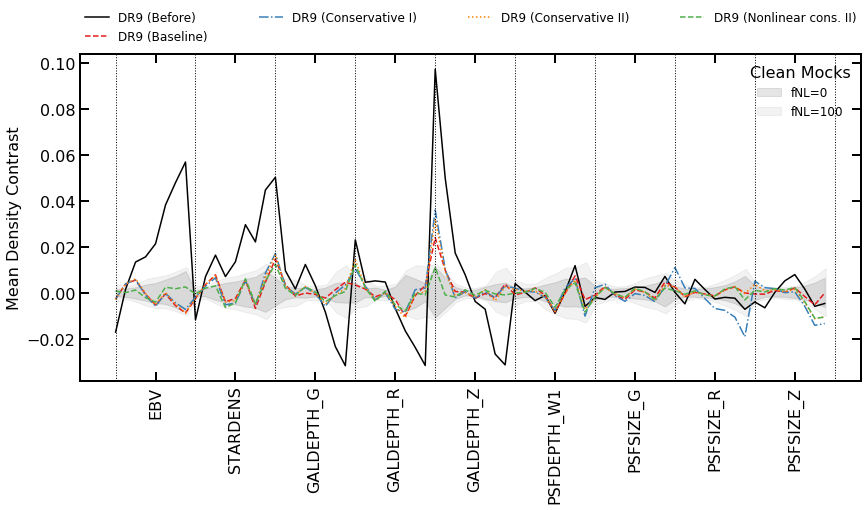

In [19]:
fg, ax = plt.subplots(sharex=True, figsize=(14, 6))
fg.subplots_adjust(hspace=0.)

err_0m = err_0.mean(axis=0)
err_100m = err_100.mean(axis=0)

ell_b = np.arange(err_0m.size)
err_0e = np.diagonal(cov_0)**0.5
err_100e = np.diagonal(cov_100)**0.5

names = ['EBV',
 'STARDENS',
 'GALDEPTH_G',
 'GALDEPTH_R',
 'GALDEPTH_Z',
 'PSFDEPTH_W1',
 'PSFSIZE_G',
 'PSFSIZE_R',
 'PSFSIZE_Z']

ln1 = ax.fill_between(ell_b, err_0m-err_0e, err_0m+err_0e,  label='fNL=0', color='k', alpha=0.1)
ln2 = ax.fill_between(ell_b+0.1, err_100m-err_100e, err_100m+err_100e, label='fNL=100', color='k', alpha=0.05)
lgn1 = plt.legend(handles=[ln1, ln2], loc='upper right', title='Clean Mocks')

kw = dict()
ln3, = ax.plot(ell_b, err_dr9,      label='DR9 (Before)', )
ln4, = ax.plot(ell_b, err_dr9all,    label='DR9 (Baseline)')
ln5, = ax.plot(ell_b, err_dr9known,  label='DR9 (Conservative I)')
ln6, = ax.plot(ell_b, err_dr9known1, label='DR9 (Conservative II)')
ln7, = ax.plot(ell_b, err_dr9nknown1, label='DR9 (Nonlinear cons. II)')
ax.legend(handles=[ln3, ln4, ln5, ln6, ln7], 
             bbox_to_anchor=(0, 1.02, 1, 0.4), loc="lower left",
                mode="expand", borderaxespad=0, ncol=4, frameon=False)

plt.gca().add_artist(lgn1)
# ax.set_yscale('log')
# ax.set_ylim(1.0e-9, 1.0e-4)

ax.set_ylabel('Mean Density Contrast')
for xt in np.arange(0, 80, 8):
    ax.axvline(xt, ls=':', lw=1, color='k')
ax.set_xticks([4+i*8 for i in range(len(names))])
ax.set_xticklabels(names, rotation=90)

fg.savefig(f'/users/PHS0336/medirz90/github/dimagfnl/figures/nbar_mocks.pdf', bbox_inches='tight')

In [20]:
chi2s = {}
chi2s['fNL=0'] = ut.get_chi2pdf(err_0)
chi2s['fNL=100'] = ut.get_chi2pdf(err_100)

nmocks: 1000, nbins: 72
nmocks: 1000, nbins: 72


125.73479275585461 37.64838882795117
119.05340053084848 39.279522675915686


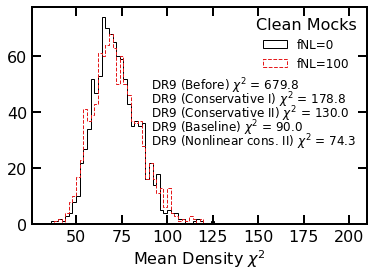

In [21]:
ls = ['-', '--']
for i, (name_i, chi2_i) in enumerate(chi2s.items()):
    print(np.max(chi2_i), np.min(chi2_i))
    plt.hist(chi2_i, histtype='step', bins=65, ls=ls[i],
             label=name_i, range=(30, 160.))    
# plt.yscale('log')

plt.text(91., 48., f'DR9 (Before) $\chi^{2}$ = {chi2_dr9:.1f}', fontsize=12)
plt.text(91., 43., f'DR9 (Conservative I) $\chi^{2}$ = {chi2_dr9known:.1f}', fontsize=12)
plt.text(91., 38., f'DR9 (Conservative II) $\chi^{2}$ = {chi2_dr9known1:.1f}', fontsize=12)
plt.text(91., 33., f'DR9 (Baseline) $\chi^{2}$ = {chi2_dr9all:.1f}', fontsize=12)
plt.text(91., 28., f'DR9 (Nonlinear cons. II) $\chi^{2}$ = {chi2_dr9nknown1:.1f}', fontsize=12)
# plt.yscale('log')
plt.xlim(26, 210)
plt.xticks([50, 75, 100, 125, 150, 175, 200])
plt.legend(title='Clean Mocks', frameon=False)
plt.xlabel(r'Mean Density $\chi^{2}$')
plt.savefig(f'/users/PHS0336/medirz90/github/dimagfnl/figures/chi2test2.pdf', bbox_inches='tight')

## Bin C$_{\ell}$

In [39]:
def bin_clmock(fnl, survey, iscont, method, ell_edges):
    print(ell_edges)
    p = '/fs/ess/PHS0336/data/lognormal/v3/clustering/'
    cl_files = glob(f'{p}clmock_{iscont}_*_lrg_{fnl}_{survey}_256_{method}.npy')
    print(fnl, survey, iscont, method)
    file_out1 = f'{p}clmock_{iscont}_lrg_{fnl}_{survey}_256_{method}_mean.npz'
    file_out2 = f'{p}clmock_{iscont}_lrg_{fnl}_{survey}_256_{method}_cov.npz'    
    print(len(cl_files), cl_files[0])
    assert len(cl_files) == 1000
    
    cl_gg = []
    cl_ggb = []
    
    for file_i in cl_files:
        cl_i = np.load(file_i, allow_pickle=True).item()
        cl_gg.append(cl_i['cl_gg']['cl'])
        
        lb, clb = ut.histogram_cell(cl_i['cl_gg']['l'], cl_i['cl_gg']['cl'], bins=ell_edges)
        cl_ggb.append(clb)

    cl_gg = np.array(cl_gg)
    cl_ggb = np.array(cl_ggb)   
    nmocks, nell = cl_gg.shape
    nbins = cl_ggb.shape[1]
    print(nmocks, nell, nbins)
    
    
    hf = (nmocks - 1.0)/(nmocks - nbins - 2.0)
    cl_cov = np.cov(cl_ggb, rowvar=False)*hf / nmocks
    inv_cov = np.linalg.inv(cl_cov)
    print(f'Hartlap with #mocks ({nmocks}) and #bins ({nbins}): {hf:.2f}' )

    fg, ax = plt.subplots(ncols=2, figsize=(12, 4))
    ax[0].imshow(inv_cov, origin='lower')
    ax[1].imshow(inv_cov.dot(cl_cov), origin='lower')
    plt.show()

    plt.figure()
    plt.plot(cl_gg.mean(axis=0))
    plt.plot(lb, cl_ggb.mean(axis=0), marker='o', mfc='w')
    plt.fill_between(np.arange(nell), *np.percentile(cl_gg, [0, 100], axis=0), alpha=0.1)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1.0e-8, 1.0e-2)
    plt.show()
    
    np.savez(file_out1, **{'el_edges':ell_edges, 'el_bin':lb, 'cl':cl_ggb.mean(axis=0)})
    np.savez(file_out2, **{'el_edges':ell_edges, 'el_bin':lb, 'clcov':cl_cov})    
    print('wrote', file_out1, file_out2)

[  2   4   6   8  10  12  14  16  18  20  30  40  50  60  70  80  90 100
 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280
 290 300]
zero ndecals 0 noweight
1000 /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_311_lrg_zero_ndecals_256_noweight.npy
1000 768 37
Hartlap with #mocks (1000) and #bins (37): 1.04


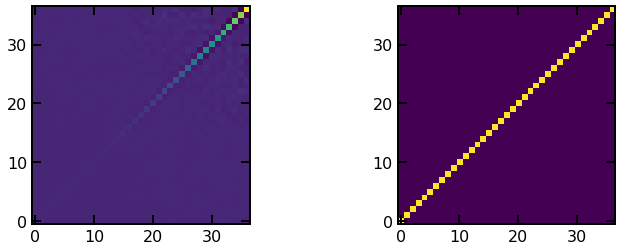

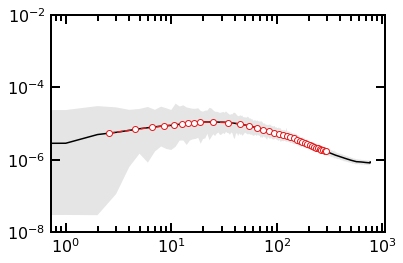

wrote /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_zero_ndecals_256_noweight_mean.npz /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_zero_ndecals_256_noweight_cov.npz
[  2   4   6   8  10  12  14  16  18  20  30  40  50  60  70  80  90 100
 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280
 290 300]
zero sdecals 0 noweight
1000 /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_172_lrg_zero_sdecals_256_noweight.npy
1000 768 37
Hartlap with #mocks (1000) and #bins (37): 1.04


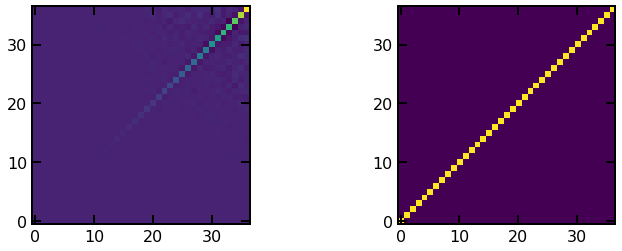

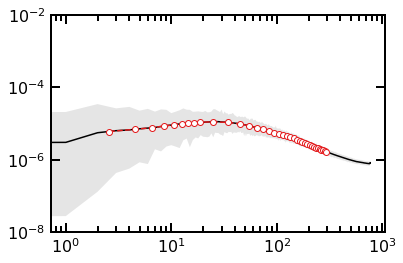

wrote /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_zero_sdecals_256_noweight_mean.npz /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_zero_sdecals_256_noweight_cov.npz
[  2   4   6   8  10  12  14  16  18  20  30  40  50  60  70  80  90 100
 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280
 290 300]
zero bmzls 0 noweight
1000 /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_681_lrg_zero_bmzls_256_noweight.npy
1000 768 37
Hartlap with #mocks (1000) and #bins (37): 1.04


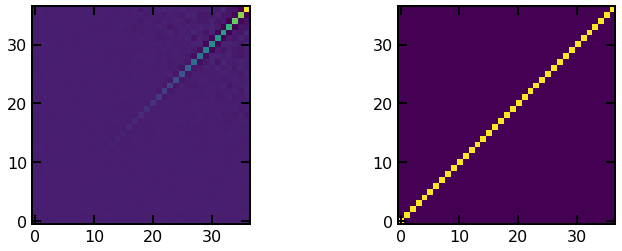

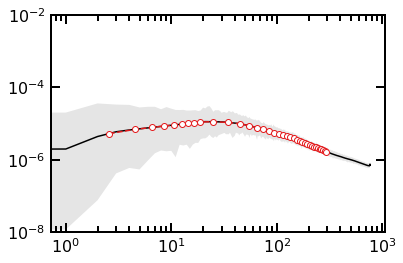

wrote /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_zero_bmzls_256_noweight_mean.npz /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_zero_bmzls_256_noweight_cov.npz
[  2   4   6   8  10  12  14  16  18  20  30  40  50  60  70  80  90 100
 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280
 290 300]
zero ndecalsc 0 noweight
1000 /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_801_lrg_zero_ndecalsc_256_noweight.npy
1000 768 37
Hartlap with #mocks (1000) and #bins (37): 1.04


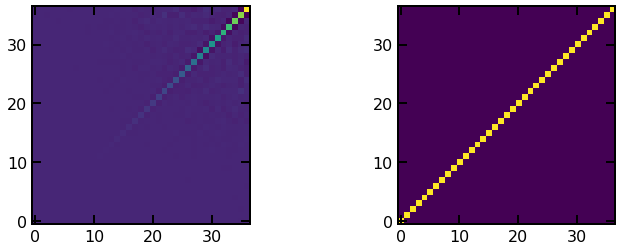

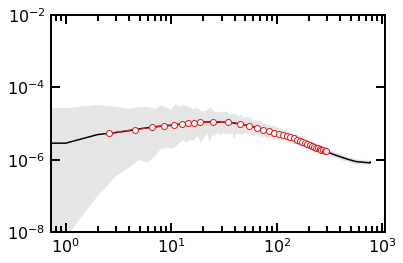

wrote /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_zero_ndecalsc_256_noweight_mean.npz /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_zero_ndecalsc_256_noweight_cov.npz
[  2   4   6   8  10  12  14  16  18  20  30  40  50  60  70  80  90 100
 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280
 290 300]
zero sdecalsc 0 noweight
1000 /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_666_lrg_zero_sdecalsc_256_noweight.npy
1000 768 37
Hartlap with #mocks (1000) and #bins (37): 1.04


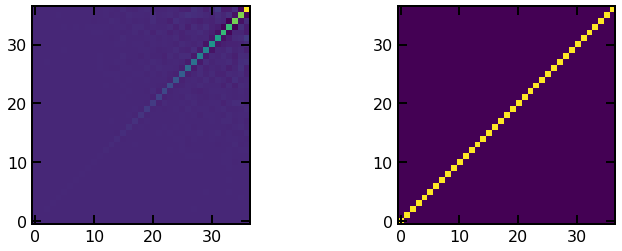

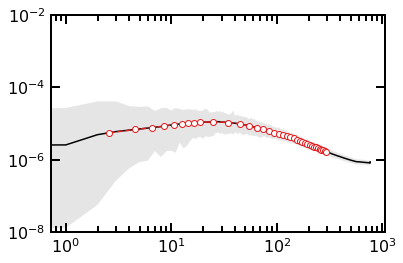

wrote /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_zero_sdecalsc_256_noweight_mean.npz /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_zero_sdecalsc_256_noweight_cov.npz
[  2   4   6   8  10  12  14  16  18  20  30  40  50  60  70  80  90 100
 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280
 290 300]
zero desic 0 noweight
1000 /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_12_lrg_zero_desic_256_noweight.npy
1000 768 37
Hartlap with #mocks (1000) and #bins (37): 1.04


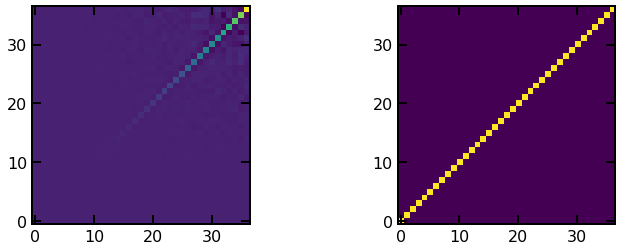

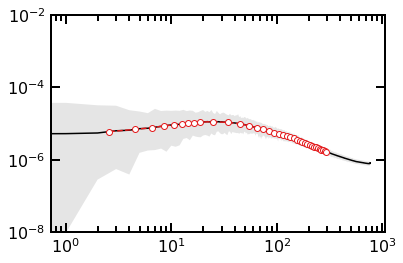

wrote /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_zero_desic_256_noweight_mean.npz /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_zero_desic_256_noweight_cov.npz
[  2   4   6   8  10  12  14  16  18  20  30  40  50  60  70  80  90 100
 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280
 290 300]
po100 desic 0 noweight
1000 /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_447_lrg_po100_desic_256_noweight.npy
1000 768 37
Hartlap with #mocks (1000) and #bins (37): 1.04


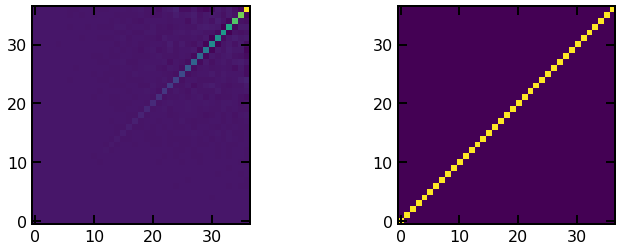

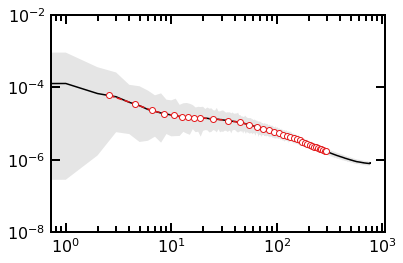

wrote /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_po100_desic_256_noweight_mean.npz /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_po100_desic_256_noweight_cov.npz


In [41]:
for region in ['ndecals', 'sdecals', 'bmzls', 'ndecalsc', 'sdecalsc', 'desic']:
    bin_clmock('zero', region, '0', 'noweight', ut.ell_edges)
    if region == 'desic':
        bin_clmock('po100', region, '0', 'noweight', ut.ell_edges)

## MCMC Contours

In [10]:
def plot_mcmc_mocks():
    stg = {'mult_bias_correction_order':0,'smooth_scale_2D':0.15, 
           'smooth_scale_1D':0.3, 'contours': [0.68, 0.95]}
    mc_kw = dict(names=['fnl', 'b', 'n0'], 
                 labels=['f_{NL}', 'b', '10^{7}n_{0}'], settings=stg) 
    read_kw = dict(ndim=3, iscale=[2])
    
    ze = MCMC('/fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_zero_desic_256_noweight_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)
    nd = MCMC('/fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_zero_ndecalsc_256_noweight_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)
    sd = MCMC('/fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_zero_sdecalsc_256_noweight_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)
    bm = MCMC('/fs/ess/PHS0336/data/lognormal/v3/mcmc//mcmc_0_lrg_zero_bmzls_256_noweight_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)    
    po = MCMC('/fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_po100_desic_256_noweight_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)    
    sc = MCMC('/fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_scaled_desic_256_noweight_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)    
    stats = {}
    stats['0 [DESI]'] = ze.stats
    stats['0 [DECaLS North]'] = nd.stats
    stats['0 [DECaLS South]'] = sd.stats
    stats['0 [BASS+MzLS]'] = bm.stats    
    stats['100 [DESI]'] = po.stats    
    stats['100 [DESI] scaled cov'] = sc.stats        

    # Triangle plot
#     g = plots.get_single_plotter(width_inch=4*1.5)
#     g.settings.legend_fontsize = 14
#     g.plot_2d([po], 'fnl', 'b', filled=True)
#     g.add_x_marker(100)
#     g.add_y_marker(1.43)
#     g.get_axes().set_ylim(1.426, 1.434)
#     g.get_axes().set_xlim(100-2.2, 100+3.2)    
#     g.add_legend([r'$f_{\rm NL}=100$ [DESI]'], colored_text=True, legend_loc='lower left')    
#     g.fig.align_labels()

    
    g = plots.get_single_plotter(width_inch=4*1.5)
    g.settings.legend_fontsize = 14
    g.plot_2d([sc, po], 'fnl', 'b', filled=True)
    g.add_x_marker(100)
    g.add_y_marker(1.43)
    g.get_axes().set_ylim(1.426, 1.434)
    g.get_axes().set_xlim(100-2.2, 100+3.2)
    g.add_legend([r'w $f_{\rm NL}=0$ cov', 
                  r'$f_{\rm NL}=100$ [DESI]'], colored_text=True, legend_loc='lower left')    
    g.fig.align_labels()
    g.fig.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/mcmc_po100.pdf', bbox_inches='tight')    
    
    g = plots.get_single_plotter(width_inch=4*1.5)
    g.settings.legend_fontsize = 14
    g.plot_2d([nd, sd, bm, ze], 'fnl', 'b', filled=True)
    g.add_x_marker(0)
    g.add_y_marker(1.43)
    g.get_axes().set_ylim(1.426, 1.434)
    g.get_axes().set_xlim(-2.2, 3.2)    
    g.add_legend(['DECaLS North', 'DECaLS South', 'BASS+MzLS', r'$f_{\rm NL}=0$ [DESI]'], 
                 colored_text=True, legend_loc='lower left')    
    g.fig.align_labels()
    g.fig.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/mcmc_zero.pdf', bbox_inches='tight')    

    #pstats = pd.DataFrame(stats,
    #                  index=['MAP [scipy]', 'Mean [chain]', '16th', '84th', '2.5', '97.5']).T  
    for s, v in stats.items():
        print(f"{s:20s} & ${v[0]:6.2f}$ & ${v[1]:6.2f}$ & ${v[2]:6.2f} < \ fnl < {v[3]:6.2f}$ & ${v[4]:6.2f} < \ fnl < {v[5]:6.2f}$ ")    
    return stats            

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
0 [DESI]             & $  0.48$ & $  0.48$ & $  0.10 < \ fnl <   0.85$ & $ -0.28 < \ fnl <   1.22$ 
0 [DECaLS North]     & $  0.10$ & $  0.09$ & $ -0.60 < \ fnl <   0.77$ & $ -1.27 < \ fnl <   1.42$ 
0 [DECaLS South]     & $  0.69$ & $  0.68$ & $ -0.01 < \ fnl <   1.36$ & $ -0.70 < \ fnl <   2.02$ 
0 [BASS+MzLS]        & $  0.97$ & $  0.97$ & $  0.21 < \ fnl <   1.73$ & $ -0.55 < \ fnl <   2.45$ 
100 [DESI]           & $100.97$ & $100.95$ & $100.32 < \ fnl < 101.58$ & $ 99.71 < \ fnl < 102.18$ 
100 [DESI] scaled cov & $100.13$ & $100.13$ & $100.00 < \ fnl < 100.26$ & $ 99.88 < \ fnl < 100.38$ 


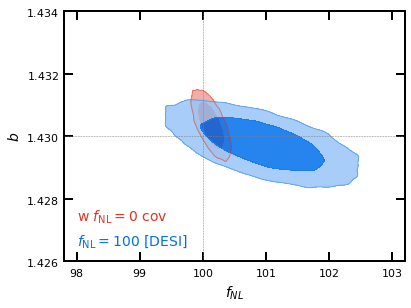

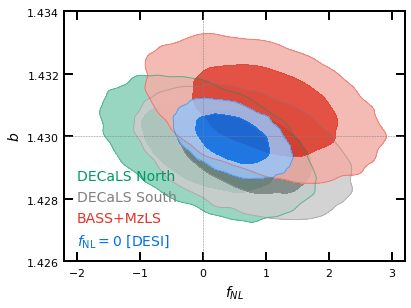

In [11]:
stats = plot_mcmc_mocks()

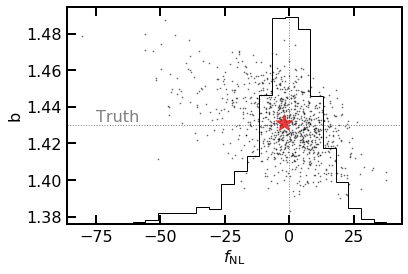

In [12]:
bf = np.load('/fs/ess/PHS0336/data/lognormal/v3/mcmc/bestfit_0_lrg_zero_desic_256_noweight.npz')

plt.scatter(*bf['params'][:, :2].T, s=2, marker='.', alpha=0.5, color='C0')
plt.scatter(*bf['params'].mean(axis=0)[:2],  s=300, marker='*', color='C1', alpha=0.8)
plt.axvline(0, lw=1, ls=':', color='grey', zorder=-10)
plt.axhline(1.43, lw=1, ls=':', color='grey', zorder=-10)
plt.text(-75, 1.432, 'Truth', color='grey')
plt.xlabel(r'$f_{\rm NL}$')
plt.ylabel('b')
plt.twinx()
plt.yticks([])
plt.hist(bf['params'][:, 0], zorder=-10, histtype='step', bins=24, color='C0')
plt.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/bestfit_zero.pdf', bbox_inches='tight')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


<Figure size 1296x972 with 0 Axes>

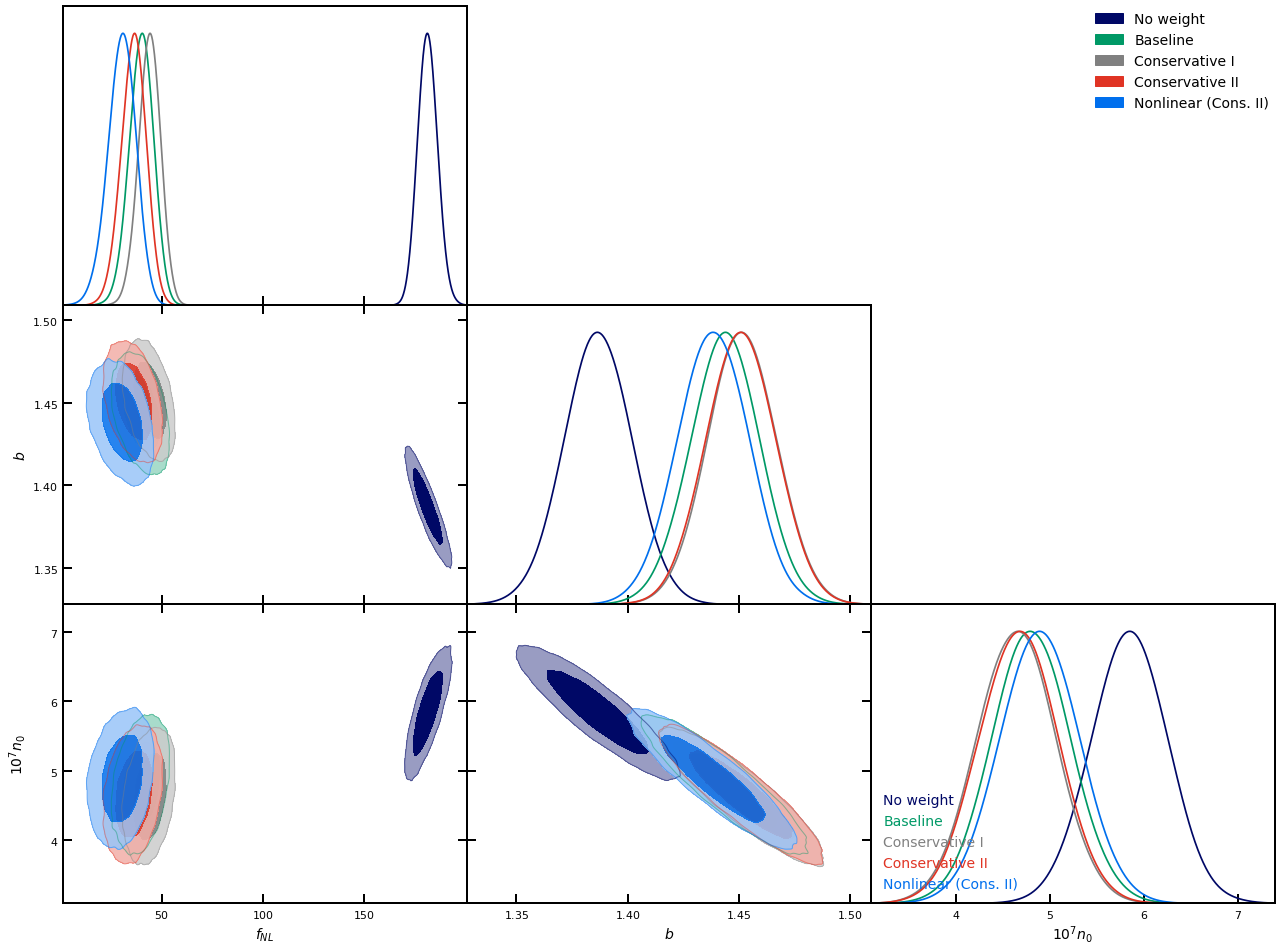

<Figure size 1296x972 with 0 Axes>

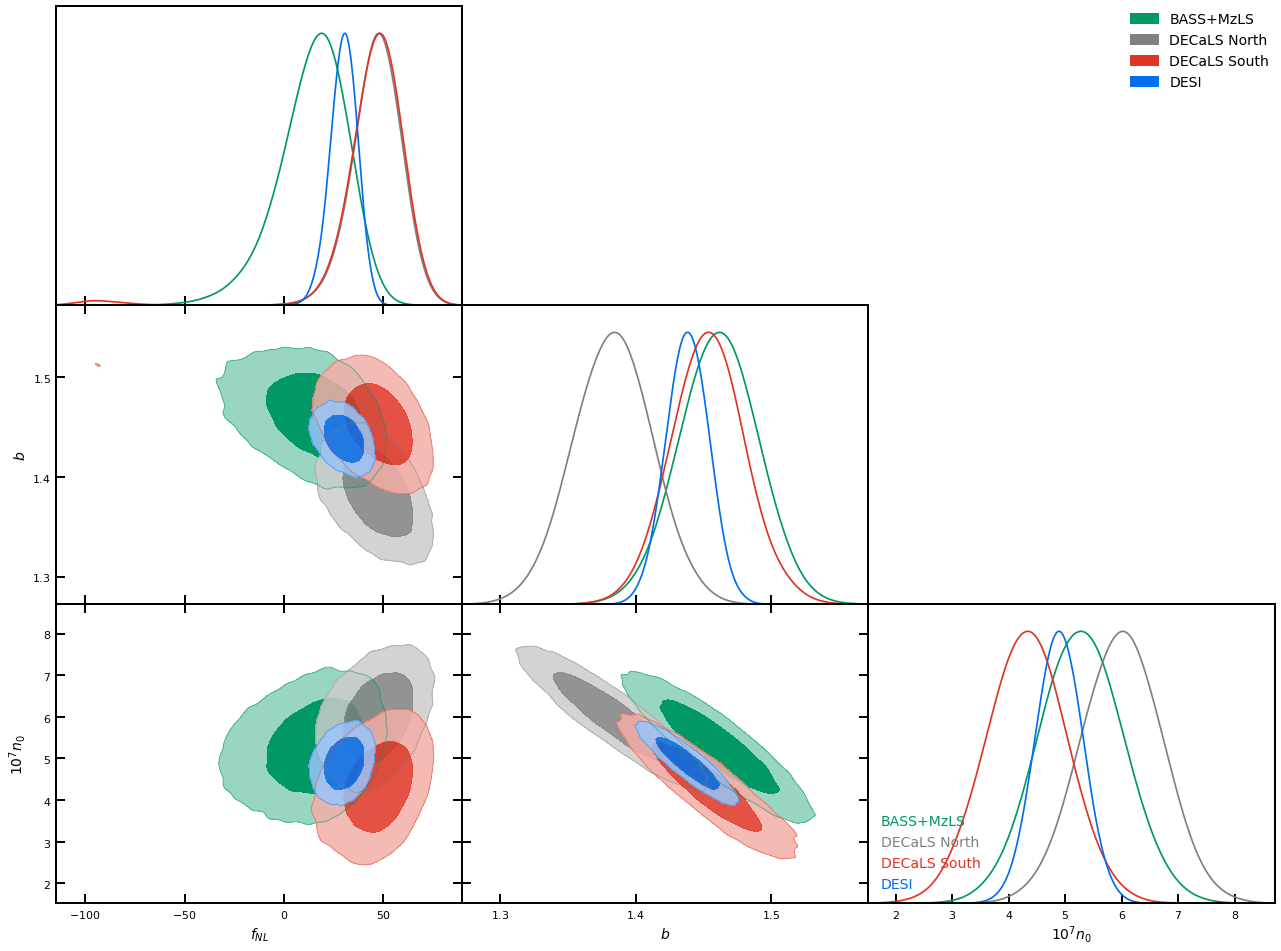

No Weight            & $181.64$ & $181.80$ & $177.05 < \ fnl < 186.53$ & $172.80 < \ fnl < 191.36$ 
Baseline             & $ 40.24$ & $ 39.68$ & $ 33.89 < \ fnl <  45.48$ & $ 27.77 < \ fnl <  50.66$ 
Conservative I       & $ 44.10$ & $ 43.75$ & $ 38.51 < \ fnl <  49.01$ & $ 32.96 < \ fnl <  53.87$ 
Conservative II      & $ 36.38$ & $ 35.87$ & $ 29.94 < \ fnl <  41.79$ & $ 23.71 < \ fnl <  47.14$ 
Nonlinear (Cons. II) & $ 31.07$ & $ 29.98$ & $ 23.39 < \ fnl <  36.60$ & $ 16.08 < \ fnl <  42.43$ 
Nonlinear (Cons. II) - BMZLS & $ 19.10$ & $ 14.27$ & $ -2.00 < \ fnl <  30.66$ & $-24.94 < \ fnl <  42.74$ 
Nonlinear (Cons. II) - NDEC & $ 48.02$ & $ 46.67$ & $ 35.24 < \ fnl <  58.30$ & $ 21.55 < \ fnl <  68.68$ 
Nonlinear (Cons. II) - SDEC & $ 48.58$ & $ 44.58$ & $ 35.43 < \ fnl <  57.55$ & $ 16.48 < \ fnl <  66.78$ 


{'No Weight': [181.6375785735537,
  181.7993757027124,
  177.05199700250202,
  186.53190973368598,
  172.80490299294868,
  191.3582440974566],
 'Baseline': [40.243320350296564,
  39.68120597615029,
  33.88559218211781,
  45.48227953642645,
  27.77004451549613,
  50.66029088554336],
 'Conservative I': [44.09720428537489,
  43.75119412164682,
  38.51044170837331,
  49.00957700177564,
  32.96055338705872,
  53.86715020922851],
 'Conservative II': [36.37606893250569,
  35.87096683300642,
  29.93791726982279,
  41.791230793321255,
  23.709607501105754,
  47.1425134790191],
 'Nonlinear (Cons. II)': [31.06581227976694,
  29.98140711202613,
  23.385204359827295,
  36.59564131899409,
  16.083313012987965,
  42.43456854533248],
 'Nonlinear (Cons. II) - BMZLS': [19.103121556095733,
  14.27161303548566,
  -2.000173804999103,
  30.664336575844366,
  -24.94371835300202,
  42.73747667550888],
 'Nonlinear (Cons. II) - NDEC': [48.02249922085959,
  46.666604394363254,
  35.23975548862311,
  58.298441565

In [22]:
def plot_mcmc_data():
    stg = {'mult_bias_correction_order':0,'smooth_scale_2D':0.15, 
           'smooth_scale_1D':0.3, 'contours': [0.68, 0.95]}
    mc_kw = dict(names=['fnl', 'b', 'n0'], 
                 labels=['f_{NL}', 'b', '10^{7}n_{0}'], settings=stg) 
    read_kw = dict(ndim=3, iscale=[2])
    
    ze = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desic_noweight_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)
    po = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desic_linp_all_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)    
    kn = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desic_linp_known_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)    
    kn1 = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desic_linp_known1_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)        
    knn1 = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desic_dnnp_known1_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)            
    knn1b = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_bmzls_dnnp_known1_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)                
    knn1n = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecalsc_dnnp_known1_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)                
    knn1s = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_sdecalsc_dnnp_known1_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)                    
    #knn2 = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desi_dnnp_known2_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)            
    stats = {}
    stats['No Weight'] = ze.stats
    stats['Baseline'] = po.stats    
    stats['Conservative I'] = kn.stats    
    stats['Conservative II'] = kn1.stats
    stats['Nonlinear (Cons. II)'] = knn1.stats    
    stats['Nonlinear (Cons. II) - BMZLS'] = knn1b.stats    
    stats['Nonlinear (Cons. II) - NDEC'] = knn1n.stats    
    stats['Nonlinear (Cons. II) - SDEC'] = knn1s.stats        
    #stats['Nonlinear (Depths+EBV)'] = knn2.stats    

    # Triangle plot
    g = plots.get_single_plotter(width_inch=3*4*1.5)
    g.settings.legend_fontsize = 14
    #g.plot_2d([ze, po, kn, kn1], 'fnl', 'b', filled=True)
    g.triangle_plot([ze, po, kn, kn1, knn1], filled=True, legend_labels=['No weight', 'Baseline',
                                                                        'Conservative I', 'Conservative II',
                                                                        'Nonlinear (Cons. II)'])
    g.add_legend(['No weight', 'Baseline', 'Conservative I', 'Conservative II', 'Nonlinear (Cons. II)'], 
                 colored_text=True, legend_loc='lower left', )    
    g.fig.align_labels()
    g.fig.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/mcmc_dr9.pdf', bbox_inches='tight')    
    plt.show()
    
    
    # Triangle plot
    g = plots.get_single_plotter(width_inch=3*4*1.5)
    g.settings.legend_fontsize = 14
    #g.plot_2d([ze, po, kn, kn1], 'fnl', 'b', filled=True)
    g.triangle_plot([knn1b, knn1n, knn1s, knn1], filled=True, 
                    legend_labels=['BASS+MzLS', 'DECaLS North', 'DECaLS South', 'DESI'])
    g.add_legend(['BASS+MzLS', 'DECaLS North', 'DECaLS South', 'DESI'], 
                 colored_text=True, legend_loc='lower left', )    
    g.fig.align_labels()
    g.fig.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/mcmc_dr9_2.pdf', bbox_inches='tight')    
    plt.show()
    
    for s, v in stats.items():
        print(f"{s:20s} & ${v[0]:6.2f}$ & ${v[1]:6.2f}$ & ${v[2]:6.2f} < \ fnl < {v[3]:6.2f}$ & ${v[4]:6.2f} < \ fnl < {v[5]:6.2f}$ ")    
        
    return stats 

plot_mcmc_data()

In [29]:
knn1 = np.load('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desic_dnnp_known1_steps10k_walkers50.npz')
bf = np.load('/fs/ess/PHS0336/data/lognormal/v3/mcmc/bestfit_0_lrg_zero_desic_256_noweight.npz')

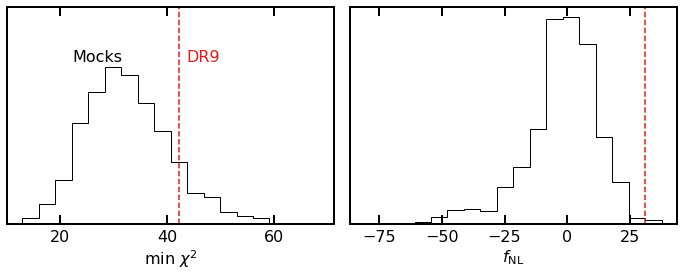

In [56]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.05)

ax[0].hist(2*bf['neglog']/1000., histtype='step', bins=18)
ax[0].axvline(2*knn1['best_fit_logprob'], ls='--', color='C1')

ax[1].hist(bf['params'][:, 0], histtype='step', bins=18)
ax[1].axvline(knn1['best_fit'][0], ls='--', color='C1')

ax[0].set(xlabel=r'min $\chi^{2}$', yticks=[])
ax[1].set(xlabel=r'$f_{\rm NL}$')

ax[0].text(0.2, 0.75, 'Mocks', transform=ax[0].transAxes)
ax[0].text(0.55, 0.75, 'DR9', color='C1', transform=ax[0].transAxes)

fig.align_xlabels() 
fig.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/pdf_dr9vsmocks.pdf', bbox_inches='tight')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


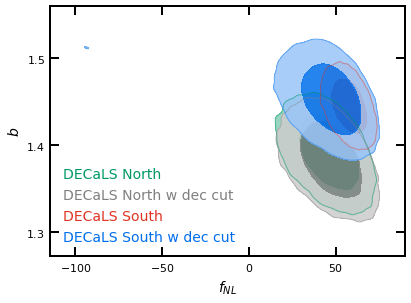

DECaLS North         & $ 47.07$ & $ 45.46$ & $ 34.31 < \ fnl <  56.83$ & $ 20.85 < \ fnl <  66.56$ 
DECaLS North w dec cut & $ 48.02$ & $ 46.67$ & $ 35.24 < \ fnl <  58.30$ & $ 21.55 < \ fnl <  68.68$ 
DECaLS South         & $ 57.99$ & $ 57.55$ & $ 51.06 < \ fnl <  64.04$ & $ 44.24 < \ fnl <  70.02$ 
DECaLS South w dec cut & $ 48.58$ & $ 44.58$ & $ 35.43 < \ fnl <  57.55$ & $ 16.48 < \ fnl <  66.78$ 


In [8]:
stg = {'mult_bias_correction_order':0,'smooth_scale_2D':0.15, 
       'smooth_scale_1D':0.3, 'contours': [0.68, 0.95]}
mc_kw = dict(names=['fnl', 'b', 'n0'], 
             labels=['f_{NL}', 'b', '10^{7}n_{0}'], settings=stg) 
read_kw = dict(ndim=3, iscale=[2])

nd = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecals_dnnp_known1_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)            
ndc = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecalsc_dnnp_known1_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)            
sd = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_sdecals_dnnp_known1_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)            
sdc = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_sdecalsc_dnnp_known1_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)            


stats = {}
stats['DECaLS North'] = nd.stats
stats['DECaLS North w dec cut'] = ndc.stats
stats['DECaLS South'] = sd.stats
stats['DECaLS South w dec cut'] = sdc.stats

labels = stats.keys()

# Triangle plot
g = plots.get_single_plotter(width_inch=4*1.5)
g.settings.legend_fontsize = 14
g.plot_2d([nd, ndc, sd, sdc], 'fnl', 'b', filled=True, legend_labels=labels)
g.add_legend(labels, colored_text=True, legend_loc='lower left', )    
g.fig.align_labels()
# g.fig.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/mcmc_dr9_cutdec.pdf', bbox_inches='tight')
plt.show()

for s, v in stats.items():
    print(f"{s:20s} & ${v[0]:6.2f}$ & ${v[1]:6.2f}$ & ${v[2]:6.2f} < \ fnl < {v[3]:6.2f}$ & ${v[4]:6.2f} < \ fnl < {v[5]:6.2f}$ ")    

## Extreme Window

In [38]:
d_1 = hp.read_map('/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desi_known1.hp256.fits')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [31]:
mask = d_1 != hp.UNSEEN
np.percentile(d_1[mask], [2, 98]) 

array([40.12145233, 45.35710144])

In [32]:
is_ex = ((d_1 < 40.12) | (d_1 > 45.36)) & mask

In [33]:
is_ex.sum()/mask.sum(), mask.sum(), mask.mean()

(0.03983606918863069, 317451, 0.4036598205566406)

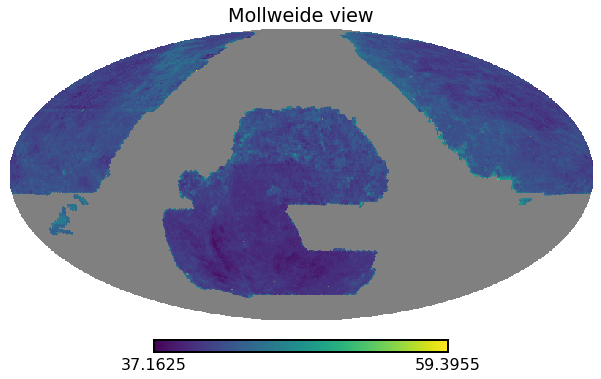

In [39]:
hp.mollview(d_1)

In [35]:
ix_ex = np.argwhere(is_ex).flatten()

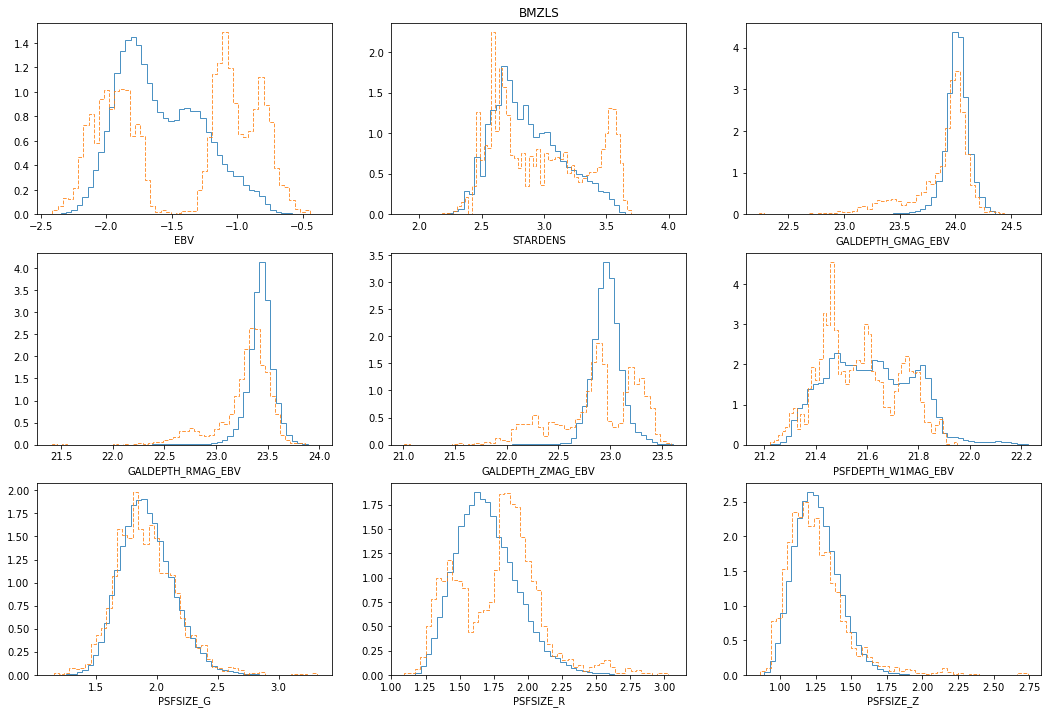

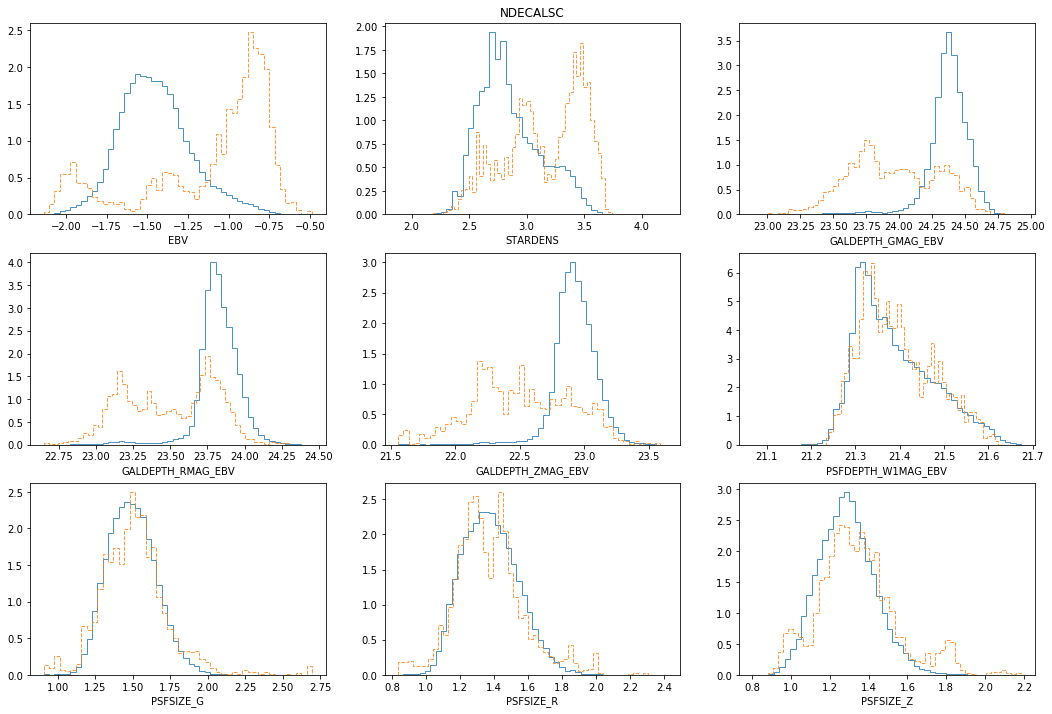

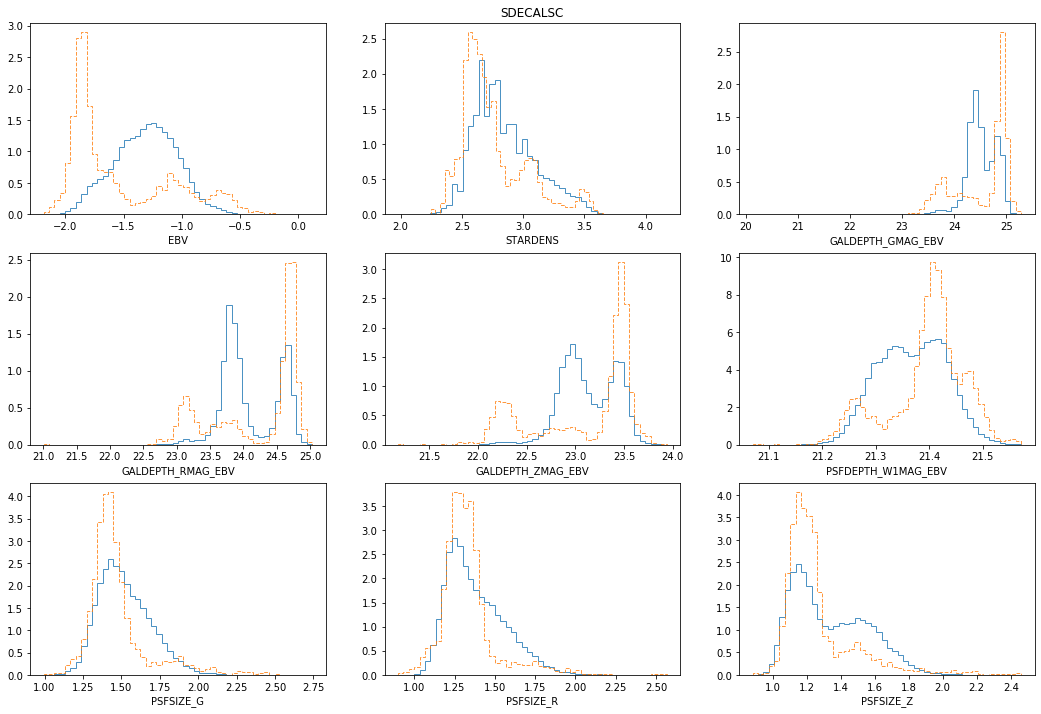

In [37]:
for r in ['bmzls', 'ndecalsc', 'sdecalsc']:
    
    data = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{r}_256.fits')
    is_comm = np.in1d(data['hpix'], ix_ex)
    #is_comm.sum(), ix_ex.size
    kw = dict(density=True, bins=50, histtype='step', alpha=0.8)

    fg, ax = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
    ax = ax.flatten()

    for i in range(data['features'].shape[1]):
        if i< 2:
            ax[i].hist(np.log10(data['features'][:, i]), ls='-', **kw)
            ax[i].hist(np.log10(data['features'][is_comm, i]), ls='--', **kw)
        else:
            ax[i].hist(data['features'][:, i], ls='-', **kw)
            ax[i].hist(data['features'][is_comm, i], ls='--', **kw)

        ax[i].set_xlabel(ut.maps_dr9[i])     
        

    ax[1].set_title(r.upper())
    plt.show()

Removed no burn in
Removed no burn in
Removed no burn in


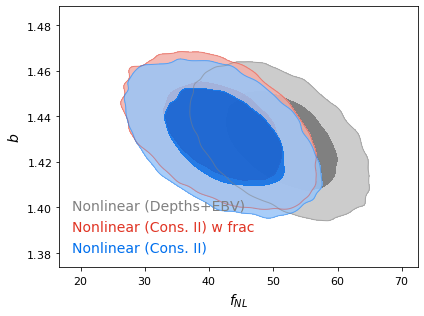

,MAP [scipy],MAP [chain],Mean [chain],Median [chain],16th,84th
Nonlinear (Depths+EBV),51.662924,51.553357,51.246052,51.351139,45.627949,56.829878
Nonlinear (Cons. II) w frac,42.608974,42.694712,42.121080,42.289579,36.120379,48.114209
Nonlinear (Cons. II),42.845528,42.682128,42.255626,42.360824,36.203137,48.370399


In [20]:
stg = {'mult_bias_correction_order':0,'smooth_scale_2D':0.15, 
       'smooth_scale_1D':0.3, 'contours': [0.68, 0.95]}
mc_kw = dict(names=['fnl', 'b', 'n0'], 
             labels=['f_{NL}', 'b', '10^{7}n_{0}'], settings=stg) 
read_kw = dict(ndim=3, iscale=[2])

knn1 = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desi_dnnp_known1_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)            
knn1f = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desi_dnnp_known1frac_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)       
knn2 = MCMC('/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desi_dnnp_known2_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)            
stats = {}
stats['Nonlinear (Depths+EBV)'] = knn2.stats   
stats['Nonlinear (Cons. II) w frac'] = knn1f.stats    
stats['Nonlinear (Cons. II)'] = knn1.stats



lgnd_labels = stats.keys()

# Triangle plot
g = plots.get_single_plotter(width_inch=4*1.5)
g.settings.legend_fontsize = 14
g.plot_2d([knn2, knn1f, knn1], 'fnl', 'b', filled=True, legend_labels=lgnd_labels)
g.add_legend(lgnd_labels, colored_text=True, legend_loc='lower left', )    
g.fig.align_labels()
g.fig.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/mcmc_dr9_frac.pdf', bbox_inches='tight')    
plt.show()

pstats = pd.DataFrame(stats,
                  index=['MAP [scipy]', 'MAP [chain]', 'Mean [chain]',
                         'Median [chain]', '16th', '84th']).T 
pstats

In [6]:
from lssutils.theory.cell import (init_sample, SurveySpectrum, Spectrum, bias_model_lrg)
from lssutils.stats.window import WindowSHT
from matplotlib.gridspec import GridSpec

In [8]:
def plot_model(fnltag='po100'):
    bm = np.load(f'/fs/ess/PHS0336/data/lognormal/v3/mcmc/mcmc_0_lrg_{fnltag}_desic_256_noweight_steps10k_walkers50.npz')
    zbdndz = init_sample(kind='lrg')
    
    # read survey geometry
    dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_desic_256.fits')
    w = np.zeros(12*256*256)
    w[dt['hpix']] = 1.0
    weight = hp.ud_grade(w, 1024)
    mask = weight > 0.5

    model = Spectrum()
    model.add_tracer(*zbdndz, p=1.0)
    model.add_kernels(np.arange(2000))


    wind = WindowSHT(weight, mask, np.arange(2048), ngauss=2048)
    fnl, b, noise = bm['best_fit']
    print(fnl, b)
    
    el_g = np.arange(2000)
    cl_bf = model(el_g, fnl=fnl, b=b, noise=noise)

    cl_bfw = wind.convolve(el_g, cl_bf)
    lmax = max(el_g)+1
    cl_bfwic = wind.apply_ic(cl_bfw[:lmax])

    cl_ = np.load(f'/fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_{fnltag}_desic_256_noweight_mean.npz')
    cl_cov_ = np.load(f'/fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_{fnltag}_desic_256_noweight_cov.npz')

    el_edges = cl_['el_edges']
    el = cl_['el_bin']
    cl = cl_['cl']
    cl_err = np.diagonal(cl_cov_['clcov'])**0.5

    cl_models = {}
    for name, cl_i in zip(['Best Fit Model', '+ Window Convolution', '+ Integral Constraint'],
                          [cl_bf, cl_bfw[:2000], cl_bfwic[:2000]]):

        cl_models[name] = ut.histogram_cell(el_g, cl_i, bins=el_edges)


    fig = plt.figure(figsize=(7, 7), constrained_layout=False)
    gs = GridSpec(3, 1, figure=fig)

    ax1 = fig.add_subplot(gs[:2, 0])
    ax2 = fig.add_subplot(gs[2, 0])

    f = 1.0e5
    lw = [0.8, 0.8, 3.]
    ls = ['-', '-', '-']
    al = [1., 1., 0.7]
    for i, (n, v) in enumerate(cl_models.items()):
        kw = dict(label=n, lw=lw[i], ls=ls[i], alpha=al[i])
        ax1.plot(v[0], f*v[1], **kw)
        ax2.plot(el, v[1]/cl, **kw)

    ax1.plot(el, f*cl, 'C0--', label='Mean of Mocks')
    ax2.axhline(1.0, color='C0', ls='--')
    ax2.fill_between(el, 1-cl_err/cl, 1+cl_err/cl, alpha=0.2)


    ax1.legend(ncol=1)
    ax1.set(xscale='log', ylabel=r'$10^{5}C_{\ell}$') #, yscale='log')
    ax1.tick_params(labelbottom=False)
    ax2.set(xscale='log', xlabel=r'$\ell$', ylabel='Ratio', xlim=ax1.get_xlim(), ylim=(0.975, 1.025))

    fig.subplots_adjust(hspace=0.0, wspace=0.02)
    fig.align_labels()

    fig.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/model_mock.pdf', bbox_inches='tight')     

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.0


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:276: RuntimeWarning: invalid value encountered in multiply
  i_gf2.append(self.simps(k3pk*w_g*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users

0.4797038343830716 1.4299168308979995


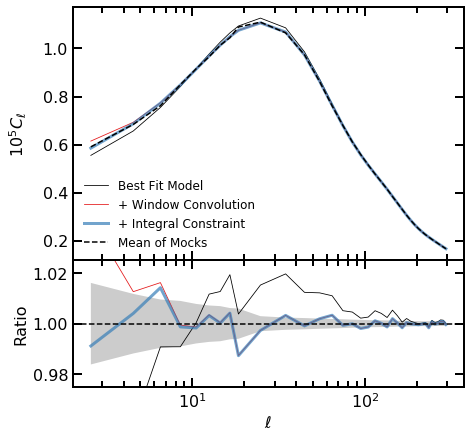

In [9]:
plot_model(fnltag='zero')

In [10]:
zbdndz = init_sample(kind='lrg')

# read survey geometry
dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_desic_256.fits')
w = np.zeros(12*256*256)
w[dt['hpix']] = dt['fracgood']
weight = hp.ud_grade(w, 1024)
mask = weight > 0.5

z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.0)
model.add_kernels(model.el_model)
model.add_window(weight, mask, np.arange(2048), ngauss=2048)  

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.0


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:276: RuntimeWarning: invalid value encountered in multiply
  i_gf2.append(self.simps(k3pk*w_g*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users

Baseline 40.243320350296564 1.4438700797211204
Conservative I 44.09720428537489 1.4516759614121288
Conservative II 36.37606893250569 1.4510978439261755
Nonlinear (Cons. II) 31.06581227976694 1.4383218632127688
No weight 181.6375785735537 1.3871074685932994


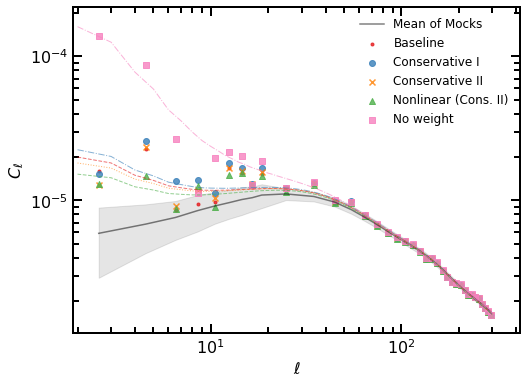

In [11]:
fnltag = 'zero'
cl_ = np.load(f'/fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_{fnltag}_desic_256_noweight_mean.npz')
cl_cov_ = np.load(f'/fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_{fnltag}_desic_256_noweight_cov.npz')

cl_err = np.diagonal(cl_cov_['clcov']*1000.)**0.5

mk = ['.', 'o', 'x', '^', 's', '1']
el_g = np.arange(300)

plt.figure(figsize=(8, 6))
ln, = plt.plot(cl_['el_bin'], cl_['cl'], label='Mean of Mocks', alpha=0.5)
plt.fill_between(cl_['el_bin'], cl_['cl']-cl_err, cl_['cl']+cl_err, alpha=0.1, color=ln.get_color())

for i, (n, nm) in enumerate(zip(['linp_all', 'linp_known', 'linp_known1', 'dnnp_known1', 'noweight'],
                 ['Baseline', 'Conservative I', 'Conservative II','Nonlinear (Cons. II)', 'No weight'])):
    cl_d = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_desic_256_{n}.npy', allow_pickle=True).item()
    cl_b = ut.histogram_cell(cl_d['cl_gg']['l'], cl_d['cl_gg']['cl'], bins=ut.ell_edges)[1]
    
    bestp = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_desic_{n}_steps10k_walkers50.npz')
    fnl, b, noise = bestp['best_fit']
    print(nm, fnl, b)

    cl_bf = model(el_g, fnl=fnl, b=b, noise=noise) 
    ln = plt.plot(el_g[2:], cl_bf[2:], lw=1, alpha=0.6)
    plt.scatter(cl_['el_bin'], cl_b, label=nm, 
                marker=mk[i], color=ln[0].get_color(), alpha=0.8)
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.ylim(1.2e-6, 2.2e-4)
plt.xlim(xmin=1.9)
plt.legend(ncol=1, loc='upper right')
plt.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/cl_obs.pdf', bbox_inches='tight')     

In [13]:
zbdndz = init_sample(kind='lrg')

# read survey geometry
dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_ndecals_256.fits')
w = np.zeros(12*256*256)
w[dt['hpix']] = dt['fracgood']
weight = hp.ud_grade(w, 1024)
mask = weight > 0.5

z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.0)
model.add_kernels(model.el_model)
model.add_window(weight, mask, np.arange(2048), ngauss=2048)  

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.0


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:276: RuntimeWarning: invalid value encountered in multiply
  i_gf2.append(self.simps(k3pk*w_g*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users

In [12]:
ls /fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecals*

/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecalsc_dnnp_known1_steps10k_walkers50.npz
/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecals_dnnp_known1_steps10k_walkers50.npz


No weight 47.06827841846321 1.392588755439644


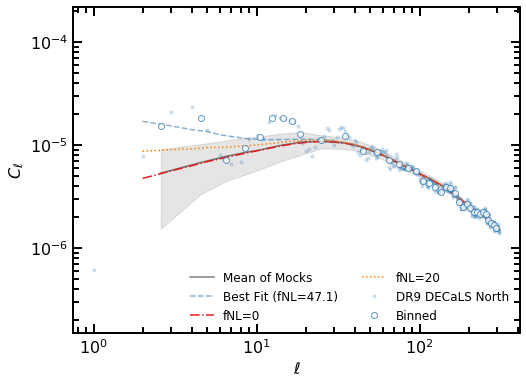

In [14]:
cl_ = np.load(f'/fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_zero_ndecals_256_noweight_mean.npz')
cl_cov_ = np.load(f'/fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_zero_ndecals_256_noweight_cov.npz')

cl_err = np.diagonal(cl_cov_['clcov']*1000.)**0.5

el_g = np.arange(300)
plt.figure(figsize=(8, 6))
ln, = plt.plot(cl_['el_bin'], cl_['cl'], label='Mean of Mocks', alpha=0.5)
plt.fill_between(cl_['el_bin'], cl_['cl']-cl_err, cl_['cl']+cl_err, alpha=0.1, color=ln.get_color())

n = 'dnnp_known1'
cl_d = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_ndecals_256_{n}.npy', allow_pickle=True).item()
cl_b = ut.histogram_cell(cl_d['cl_gg']['l'], cl_d['cl_gg']['cl'], bins=ut.ell_edges)[1]

bestp = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecals_{n}_steps10k_walkers50.npz')
fnl, b, noise = bestp['best_fit']
print(nm, fnl, b)

plt.plot(el_g[2:], model(el_g, fnl=fnl, b=b, noise=noise)[2:], alpha=0.6, label=f'Best Fit (fNL={fnl:.1f})', color='C2')
plt.plot(el_g[2:], model(el_g, fnl=0.0, b=b+0.03, noise=noise)[2:], label='fNL=0', color='C1')
plt.plot(el_g[2:], model(el_g, fnl=20.0, b=b+0.03, noise=noise)[2:], label='fNL=20', color='C3')

plt.plot(cl_d['cl_gg']['cl'][:310], label='DR9 DECaLS North', marker='.', ls='none', alpha=0.2, color='C2')
plt.plot(cl_['el_bin'], cl_b, alpha=0.8,  color='C2', label='Binned', ls='none', marker='o', mfc='w')


    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.ylim(1.5e-7, 2.2e-4)

plt.legend(ncol=2, loc=4)
# plt.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/cl_obs.pdf', bbox_inches='tight')     

In [11]:
dt = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')
hpix = dt['hpix']

In [ ]:
ix = '96'

m0c = hp.read_map(f'/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-zero-{ix}-f1z1-contaminated.fits')
m100c = hp.read_map(f'/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-po100-{ix}-f1z1-contaminated.fits')
m0 = hp.read_map(f'/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-zero-{ix}-f1z1.fits')
m100 = hp.read_map(f'/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-po100-{ix}-f1z1.fits')



[Text(0, 0.5, 'Ncont/Nfid'), Text(0.5, 0, 'HPIX')]

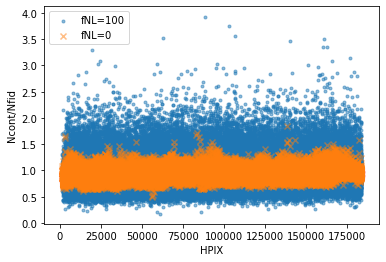

In [31]:

#plt.scatter(m0[hpix], (m0c-m0)[hpix], alpha=0.5)
#plt.scatter(m100[hpix], (m100c-m100)[hpix], alpha=0.5, zorder=-12)
#plt.scatter(m0[hpix], m100[hpix], marker='.', alpha=0.2)

fg, ax = plt.subplots(nrows=1, figsize=(6, 4), sharex=True)

ax.scatter(hpix, m100c[hpix]/m100[hpix], marker='.', alpha=0.5)
ax.scatter(hpix, m0c[hpix]/m0[hpix], marker='x', alpha=0.5)
ax.legend(['fNL=100', 'fNL=0'])
ax.set(xlabel='HPIX', ylabel='Ncont/Nfid')

# ax[1].scatter(hpix, m100c[hpix]-m100[hpix], marker='.', alpha=0.5)
# ax[1].scatter(hpix, m0c[hpix]-m0[hpix], marker='x', alpha=0.5)
# ax[1].legend(['fNL=100', 'fNL=0'])
# ax[1].set(xlabel='HPIX', ylabel='Ncont-Nfid')

In [3]:
from sympy.physics.wigner import wigner_3j
from scipy.optimize import curve_fit

In [4]:
data = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_desi_256.fits')
weight = ut.make_hp(256, data['hpix'], data['fracgood'])

0.4856058756510417


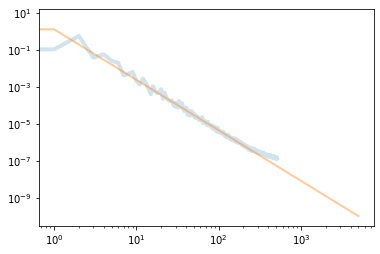

In [58]:
def model(l, *p):
    return p[0]*np.log10(l)+p[1]

def get_cl_wind(weight, mask, plot=False, nside=256):

    fsky = mask.mean()
    print(fsky)
    weight[~mask] = hp.UNSEEN
    cl_wind = hp.anafast(weight, lmax=2*nside) / fsky

    el_p = 1
    el = np.arange(5000)
    is_small = el < el_p

    lmin = 10
    lmax = 200 #2*nside-1
    x = np.arange(lmin, lmax+1)
    y = cl_wind[lmin:lmax+1]
    res = curve_fit(model, x, np.log10(y), p0=[1, 1])

    cl_window = np.zeros(el.size)
    cl_window[:el_p] = cl_wind[:el_p]
    cl_window[~is_small] = 10**model(el[~is_small], *res[0])
    
    if plot:
        x_g = np.arange(el_p, 5000)
        plt.plot(cl_wind, alpha=0.2, lw=4)
        plt.plot(cl_window, alpha=0.4, lw=2, ls='-')
        #plt.plot(x_g, 10**model(x_g, *res[0]), lw=1)
        plt.xscale('log')
        plt.yscale('log')    
        
    return cl_window

mask = weight > 0
cl_w = get_cl_wind(weight, mask, plot=True)

In [59]:
!qstat -u medirz90


o0018.ten.osc.edu:
                                                                               Req'd  Req'd   Elap 
Job id               Username Queue    Name                 SessID NDS   TSK   Memory Time Use S Time 
-------------------- -------- -------- -------------------- ------ ----- ----- ------ ----- - -----
20609558             medirz90 serial   ondemand/sys/dashboa --         1     2     -- 01:00 R 00:59


In [60]:
l1 = np.array([2, 5, 10, 30])
l2 = np.arange(51)
l3 = np.arange(2000)

mixm = np.zeros((l1.size, l2.size))
for i, l1_ in enumerate(l1):
    print('.', end='')
    
    for l2_ in l2:
        l3sum_ = 0.0        
        for l3_ in l3:
            wj = float(wigner_3j(l1_, l2_, l3_, 0, 0, 0))
            l3sum_ += (2.*l3_+1.)*cl_w[l3_]*wj*wj        
        mixm[i, l2_] = l3sum_*(2.*l2_+1.)/(4.*np.pi)

....

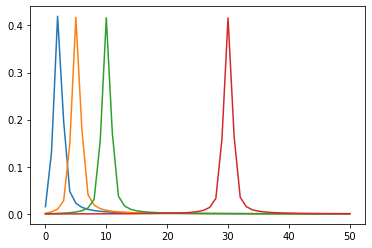

In [61]:
plt.plot(mixm[0, :])
plt.plot(mixm[1, :])
plt.plot(mixm[2, :])
plt.plot(mixm[3, :])
# plt.yscale('log')

22.7  9  2.5
19.6  9  2.2
22.1  9  2.5


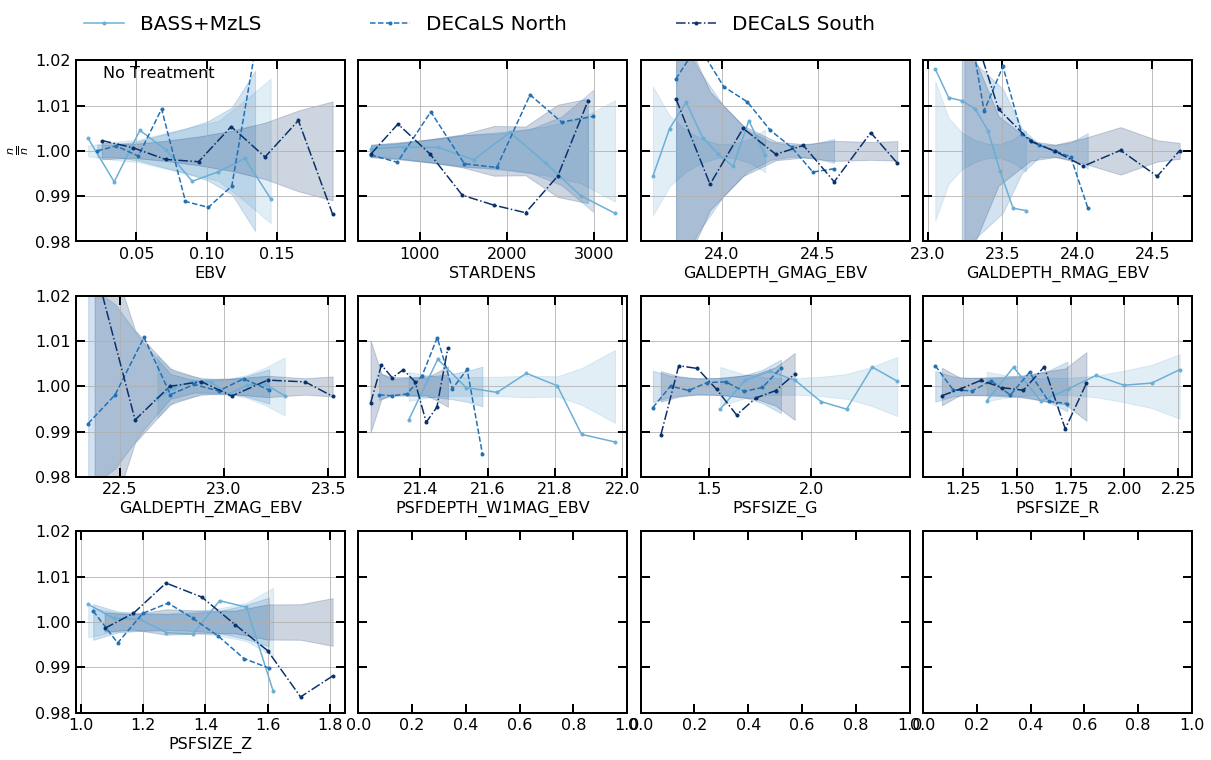

In [19]:
dv.plot_nnbar(['/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_bmzls_256_dnnp_known1.npy',
               '/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_ndecalsc_256_dnnp_known1.npy',
               '/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_sdecalsc_256_dnnp_known1.npy'],
            title='No Treatment', axes=np.arange(9), 
            lb=['BASS+MzLS', 'DECaLS North', 'DECaLS South'], 
            ylim=(0.98, 1.02))#, delaxes=[15, 14, 13])

In [ ]:
mean_den = np.load('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_bmzls_256_noweight.npy', allow_pickle=True)

In [ ]:
mean_den[0]

In [ ]:
ncols = 7
fg, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(ncols*6, 8), sharey=True)
fg.subplots_adjust(wspace=0.0)
ax = ax.flatten()

for i, den_i in enumerate(mean_den):
    ax[i].errorbar(den_i['bin_avg'], den_i['nnbar'], den_i['nnbar_err'], capsize=3)

In [ ]:
mean_den[0]

In [3]:
import modules as md

running on /users/PHS0336/medirz90


In [4]:
!qstat -u medirz90 # check your time


o0006.ten.osc.edu:
                                                                               Req'd  Req'd   Elap 
Job id               Username Queue    Name                 SessID NDS   TSK   Memory Time Use S Time 
-------------------- -------- -------- -------------------- ------ ----- ----- ------ ----- - -----
20484458             medirz90 serial   ondemand/sys/dashboa --         1     2     -- 01:00 R 00:31


In [ ]:
map_cont = md.hp.read_map('/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-po100-1-f1z1-contaminated.fits')
map_null = md.hp.read_map('/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-po100-1-f1z1.fits')

In [ ]:
md.plt.plot(map_cont)

In [ ]:
md.plt.plot(map_null)

In [ ]:
is_g = (map_cont > 0)

In [ ]:
md.plt.scatter(map_null[is_g], (map_cont-map_null)[is_g], alpha=0.1, marker='.')
md.plt.xlabel(r'N$_{\rm Orig}$')
md.plt.ylabel(r'$\Delta$N')

In [ ]:
d= md.ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/density_maps/0.57.0/resolve/density_map_sv3_lrg_south_nside_256_minobs_1_maskbits__lrgmask_v1.fits')

In [ ]:
md.plt.scatter(d['RA'], d['DEC'])

## Histogram of Weights

## Histogram of Mean Density


## Histogram of Cross Spectrum

In [ ]:
md.make_chi2clx('zero')
md.make_chi2clx('po100')

In [ ]:
ws = md.glob('/fs/ess/PHS0336/data/lognormal/v2/regression/fnl_po100/cont/*/bmzls/nn_known5/nn-weights.fits')

In [ ]:
wm = md.np.zeros(12*256*256)
for wi in ws:
    d_ = md.ft.read(wi)
    wm[d_['hpix']] += d_['weight'].mean(axis=1)
wm /= len(ws)

In [ ]:
ws1 = md.glob('/fs/ess/PHS0336/data/lognormal/v2/regression/fnl_zero/cont/*/bmzls/nn_known5/nn-weights.fits')

In [ ]:
wm1 = md.np.zeros(12*256*256)
for wi in ws1:
    d_ = md.ft.read(wi)
    wm1[d_['hpix']] += d_['weight'].mean(axis=1)
wm1 /= len(ws)

In [ ]:
md.hp.mollview(wm1/wm-1, rot=(131,), cmap='bwr', unit='relative diff')

In [ ]:
md.hp.write_map('/fs/ess/PHS0336/data/lognormal/v2/regression/fnl_zero_cont_bmzls_nn_known5.fits',wm1, fits_IDL=False)
md.hp.write_map('/fs/ess/PHS0336/data/lognormal/v2/regression/fnl_po100_cont_bmzls_nn_known5.fits',wm, fits_IDL=False)

In [ ]:
is_good = d_['hpix']
md.plt.hist(wm[is_good], label='fNL=100', histtype='step', range=(0, 50), bins=40)
md.plt.hist(wm1[is_good], label='fNL=0', histtype='step', range=(0, 50), bins=40)
md.plt.xlabel('Mean Weight')
md.plt.legend()

In [ ]:
loss = md.np.load('/fs/ess/PHS0336/data/lognormal/v2/regression/fnl_po100/cont/1/bmzls/nn_known5/metrics.npz', allow_pickle=True)

In [ ]:
loss.files

In [ ]:
lt = md.np.array(loss['losses'].item()['train'])
lv = md.np.array(loss['losses'].item()['valid'])

In [ ]:
lv.shape

In [ ]:
md.plt.figure(figsize=(10, 4))
for i in range(1):
    for j in range(20):
        md.plt.plot(lt[i, j, :], ls='-', lw=1, color='C0', zorder=-10, alpha=0.2)
        md.plt.plot(lv[i, j, :], ls='-', lw=1, color='C1', alpha=0.2)        
md.plt.ylim(65.7, 69)
md.plt.ylabel('Loss')
md.plt.xlabel('Epoch')
md.plt.grid()

In [5]:
def read_cl(path):
    files = md.glob(path)
    cl1 = []
    for fl in files:
        d_ = md.np.load(fl, allow_pickle=True).item()
        cl1.append(d_['cl_gg']['cl'])
    return md.np.array(cl1)

def get_mean_cl(fnlt):
    
    fl0 = read_cl(f'/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_0_*_lrg_{fnlt}_bmzls_256_noweight.npy')
    #fl1 = read_cl(f'/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_1_*_lrg_{fnlt}_bmzls_256_nn_known5_avg.npy')
    fl1 = read_cl(f'/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_1_*_lrg_{fnlt}_bmzls_256_nn_known5_regrs.npy')
    fl2 = read_cl(f'/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_1_*_lrg_{fnlt}_bmzls_256_nn_known5.npy')
    flc = read_cl(f'/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_1_*_lrg_{fnlt}_bmzls_256_noweight.npy')   
    
    return (fl0, fl1, fl2, flc)

In [15]:
files = md.glob(f'/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_1_*_lrg_po100_bmzls_256_nn_known5_regrs.npz')

In [16]:
cl_rf = []
for fl in files:
    d_ = md.np.load(fl)
    cl_rf.append([d_['cl_before'], d_['cl_after']])
    print('.',end='')

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [18]:
cl_rf = md.np.array(cl_rf)

In [19]:
cl_rf.shape

(1000, 2, 768)

In [30]:
cl_rf.mean(axis=0)[0, :10]-clpo100[3].mean(axis=0)[:10]

array([-1.57772181e-29,  3.52365706e-19, -1.08420217e-19,  5.42101086e-20,
        4.87890978e-19,  5.42101086e-19,  0.00000000e+00, -1.89735380e-19,
       -1.21972744e-19, -4.06575815e-20])

In [ ]:
#clpo100w0 = read_cl(f'/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_1_*_lrg_po100_bmzls_256_nn_known5_avgwsys0.npy')

In [6]:
#clzeros = get_mean_cl('zero')
clpo100 = get_mean_cl('po100')

In [35]:
dv.setup_color()

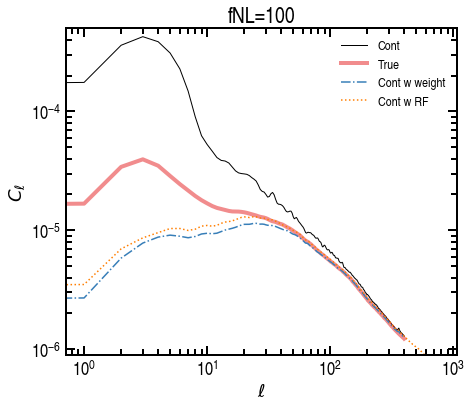

In [37]:
fg, ax = md.plt.subplots(figsize=(7, 6), sharex=True, sharey=True)

ax.loglog(clpo100[3].mean(axis=0)[:400], label='Cont', lw=1)    
ax.loglog(clpo100[0].mean(axis=0)[:400], label='True', alpha=0.5, lw=4, ls='-')
ax.loglog(clpo100[2].mean(axis=0)[:400], label='Cont w weight')

ax.loglog(cl_rf.mean(axis=0)[1, :], label='Cont w RF')
ax.set_title('fNL=100')
ax.set_ylim((9.0e-7, 5.0e-4))
ax.set(ylabel=r'$C_{\ell}$', xlabel=r'$\ell$')
ax.legend()

No handles with labels found to put in legend.


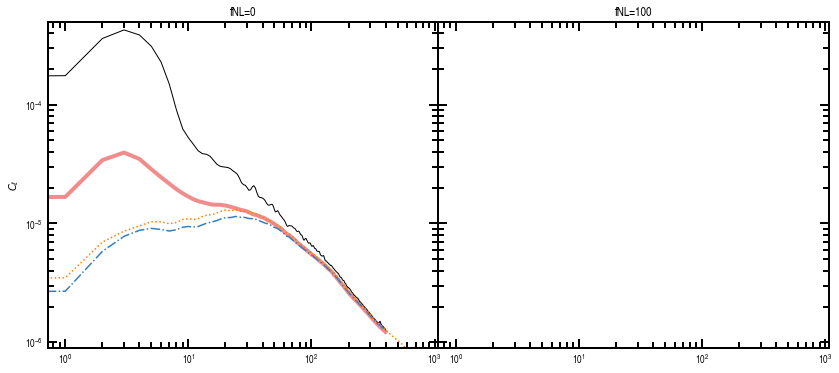

In [33]:
fg, ax = md.plt.subplots(ncols=2, figsize=(14, 6), sharex=True, sharey=True)
fg.subplots_adjust(wspace=0.)

for i, cli in enumerate([clpo100,]): #clzeros
    ax[i].loglog(cli[3].mean(axis=0)[:400], label='Cont', lw=1)    
    ax[i].loglog(cli[0].mean(axis=0)[:400], label='True', alpha=0.5, lw=4, ls='-')
    #ax[i].loglog(cli[1].mean(axis=0)[:400], label='Cont w avg weight')
    ax[i].loglog(cli[2].mean(axis=0)[:400], label='Cont w weight')

ax[0].loglog(cl_rf.mean(axis=0)[1, :], label='Cont w RF')
#ax[1].loglog(clpo100w0.mean(axis=0)[:400], label='Cont w avg weight (from fnl=0)', marker='x')
ax[0].set_title('fNL=0')
ax[1].set_title('fNL=100')
ax[0].set_ylim((9.0e-7, 5.0e-4))
ax[0].set(ylabel=r'$C_{\ell}$')
ax[1].legend()

In [ ]:
fg, ax = md.plt.subplots(ncols=2, figsize=(14, 6), sharex=True, sharey=True)
fg.subplots_adjust(wspace=0.)

def add_cl(axi, cls, **kw):
    mu = cls.mean(axis=0)[:400]
    std = cls.std(axis=0)[:400]/md.np.sqrt(1000.)
    el = md.np.arange(400)
    
    ln, = axi.loglog(mu, **kw)
    axi.fill_between(el, mu-std, mu+std, color=ln.get_color(), alpha=0.2)
    
    


for i, cli in enumerate([clzeros, clpo100]):
    add_cl(ax[i], cli[3], label='Cont', lw=1)    
    add_cl(ax[i], cli[0], label='True', alpha=0.5, lw=1, ls='-')
    add_cl(ax[i], cli[1], label='Cont w avg weight', lw=1)
    add_cl(ax[i], cli[2], label='Cont w weight', lw=1)


ax[0].set_title('fNL=0')
ax[1].set_title('fNL=100')
ax[0].set_ylim((9.0e-7, 5.0e-4))
ax[0].set(ylabel=r'$C_{\ell}$')
ax[1].legend()

In [ ]:
fg, ax = md.plt.subplots(ncols=2, figsize=(14, 6), sharex=True, sharey=True)
fg.subplots_adjust(wspace=0.)

sq = md.np.sqrt(1000.)
for i, cli in enumerate([clzeros, clpo100]):
    ax[i].loglog(cli[3].std(axis=0)[:400]/sq, label='Cont', lw=1)    
    ax[i].loglog(cli[0].std(axis=0)[:400]/sq, label='True', alpha=0.5, lw=4, ls='-')
    ax[i].loglog(cli[1].std(axis=0)[:400]/sq, label='Cont w avg weight')
    ax[i].loglog(cli[2].std(axis=0)[:400]/sq, label='Cont w weight')


ax[0].set_title('fNL=0')
ax[1].set_title('fNL=100')
ax[0].set_ylim((1.0e-9, 5.0e-6))
ax[0].set(ylabel=r'$\sigma(C_{\ell})/\sqrt{1000}$')
ax[1].legend()

In [ ]:
md.plt.semilogx(clpo100[3].mean(0)-clzeros[3].mean(0), label='with contamination')
md.plt.semilogx(clpo100[0].mean(0)-clzeros[0].mean(0), label='no contamination')
md.plt.ylabel('Cell[fnl=100] - Cell[fnl=0]')
md.plt.legend()

In [ ]:
md.plt.semilogx(clpo100[3].mean(0)/clzeros[3].mean(0), label='with contamination')
md.plt.semilogx(clpo100[0].mean(0)/clzeros[0].mean(0), label='no contamination')
md.plt.ylabel('Cell[fnl=100]/Cell[fnl=0]')
md.plt.legend()

In [ ]:
((clpo100[3].mean(0)clzeros[3].mean(0))/(clpo100[0].mean(0)-clzeros[0].mean(0))).max()

In [ ]:
md.plt.loglog(md.np.std(clpo100[3], axis=0)/1000.**0.5)
md.plt.loglog(md.np.std(clzeros[3], axis=0)/1000.**0.5)

## MCMC of Contaminated Mocks

In [ ]:
plot_mcmc_mocks('bmzls')

In [ ]:
plot_mcmc_mocks('bmzls', fnltag='po100')

## Power Spectra of Cont Mocks

In [ ]:
for region in ['bmzls', 'ndecals', 'sdecals']:    
    for method in ['noweight', 'nn_all']: #, 'noweight'
        md.bin_clmock('zero', region, 1, method)
        if method=='noweight':
            md.bin_clmock('zero', region, 0, method)
            
region = 'bmzls'
for method in ['nn_known1', 'nn_known2', 'nn_known3', 'nn_known4', 'nn_known5']:
    md.bin_clmock('zero', region, 1, method)
    if method=='noweight':
        md.bin_clmock('zero', region, 0, method)
        
md.bin_clmock('zero', 'ndecals', 1, 'nn_known5')

region = 'bmzls'
for method in ['noweight', 'nn_all', 'nn_known1', 
               'nn_known2', 'nn_known3', 'nn_known4', 'nn_known5']:
    md.bin_clmock('po100', region, 1, method)
    if method=='noweight':
        md.bin_clmock('po100', region, 0, method)

In [ ]:
md.plot_clmocks_wsys()

## Feature Selection on Contaminated Mock 1
Perform forward feature selection. Add one map at a time to the set of input features. Ordering is determined by the map that indicates the strongest trend, quantified with $\chi^{2}$ statistics. In each iteration the neural net parameters are trained from scratch.

In [ ]:
labels = ['No correction', 'I: EBV', 'II: I+psfdepthg', 'III: II+nstar', 'IV: III+psfsize-g', 'V:IV+galdepthz', 'All Maps']
names  = ['noweight', 'nn_known1', 'nn_known2', 'nn_known3', 'nn_known4', 'nn_known5', 'nn_all']
md.plot_nbar_mock(names, labels)

In [ ]:
labels = ['No correction', 'I: EBV', 'II: I+psfdepthg', 'III: II+nstar', 'IV: III+psfsize-g', 'V:IV+galdepthz', 'All Maps']
names  = ['noweight', 'nn_known1', 'nn_known2', 'nn_known3', 'nn_known4', 'nn_known5', 'nn_all']
md.plot_chi2hist_mock(names, labels)

In [ ]:
labels = ['No correction', 'V:IV+galdepthz', 'All Maps']
names  = ['noweight',  'nn_known5', 'nn_all']
md.plot_chi2hist_mock(names, labels, imock=10, region='ndecals')

In [ ]:
ls /fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_1_1_lrg_zero_ndecals_256_*.npy

In [ ]:
labels = ['No correction', 'I: EBV', 'II: I+psfdepthg', 'III: II+nstar', 'IV: III+psfsize-g', 'V:IV+galdepthz', 'All Maps']
names  = ['noweight', 'nn_known1', 'nn_known2', 'nn_known3', 'nn_known4', 'nn_known5', 'nn_all']
md.plot_chi2hist_mock(names, labels, fnltag='zero')

In [ ]:
labels = ['No correction', 'I: EBV', 'II: I+psfdepthg', 'III: II+nstar', 'IV: III+psfsize-g', 'V:IV+galdepthz', 'All Maps']
names  = ['noweight', 'nn_known1', 'nn_known2', 'nn_known3', 'nn_known4', 'nn_known5', 'nn_all']
md.plot_chi2hist_mock(names, labels, fnltag='po100')

In [ ]:
labels = ['No correction', 'I: EBV', 'II: I+psfdepthg', 'III: II+nstar', 'IV: III+psfsize-g', 'V:IV+galdepthz', 'All Maps']
names  = ['noweight', 'nn_known1', 'nn_known2', 'nn_known3', 'nn_known4', 'nn_known5', 'nn_all']


for n,v in zip(names, labels):
    md.plot_chi2hist_mocks(n, v, region='bmzls', fnltag='zero')
    md.plot_chi2hist_mocks(n, v, region='bmzls', fnltag='po100')
    

In [ ]:
p_ = '/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/'
names = ['No correction', 'I: EBV', 'II: I+gdepthg', 'III: II+nstar', 'IV: III+psfsize-g', 'V:IV+depths']
#
r = 'bmzls'

def errorbar(axi, *arrays, **kwargs):
    _, y, ye = arrays
    chi2 = (((y-1)/ye)**2).sum()
    axi.errorbar(*arrays, **kwargs, label=fr'$\chi^{2}$ = {chi2:.1f}')
        
        
for jj in range(1):
    
        
    fg, ax = plt.subplots(nrows=3, ncols=5, figsize=(25, 14), sharey=True)
    ax = ax.flatten()
    fg.subplots_adjust(wspace=0.0)
    for k, r in enumerate(['bmzls','ndecals', 'sdecals']):
        nbars = {}
        for n in ['noweight',]:# 'nn_known1', 'nn_known4', 'nn_known5', 'nn_known6', 'nn_known7']:
            nbars[n] = np.load(f'{p_}nbar_lrg_{r}_256_{n}.npy', allow_pickle=True)        

        for i in range(13):
            for j, n in enumerate(nbars.keys()):
                if j > jj:break
                errorbar(ax[i], nbars[n][i]['bin_avg'], nbars[n][i]['nnbar'], nbars[n][i]['nnbar_err'], capsize=4)
                if i==12:
                    ax[13].text(0.2, 0.8-0.1*j-0.1*k, f'{names[j]} {r}', 
                                transform=ax[13].transAxes, color='C%s'%k)
            ax[i].axhline(1.0, ls=':', lw=1)
            ax[i].set_xlabel(nbars['noweight'][i]['sys'])
            ax[i].legend(ncol=2)
            ax[i].set_ylim(0.82, 1.18)
        
    # plt.plot(nbars['nn'])
    ax[5].set_ylabel('Mean Density')

    # plt.plot(nbars['noweight'])
    fg.show()

In [ ]:
chi2d = {}

p_ = '/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/'
names = ['No correction', 'Conservative', 'Extreme']
for i, n in enumerate(['noweight', 'nn_known', 'nn_all']):
    chi2d[names[i]] = get_chi2t(f'{p_}nbar_lrg_bmzls_256_{n}.npy', chi2s[1])

In [ ]:
plt.hist(chi2s[0], histtype='step', range=(50., 200.), bins=25)
plt.hist(chi2f[0], histtype='step', range=(50., 200.), bins=25)

i = 0
for n,v in chi2d.items():
    plt.axvline(v, label=n, color='C%d'%i)
    i += 1
plt.legend(title='DR9')
plt.text(150, 80, r'Mocks $f_{\rm NL}=0$')
plt.text(150, 65, r'Mocks $f_{\rm NL}=100$', color='C1')
plt.xlabel(r'Mean Density Contrast $\chi^{2}$')
plt.savefig('figs/nbar_chi2_dr9.pdf', bbox_inches='tight')

In [ ]:
pwd

In [ ]:
plt.hist(chi2s[0], histtype='step', range=(50., 200.), bins=25)
plt.hist(chi2f[0], histtype='step', range=(50., 200.), bins=25)

i = 0
for n,v in chi2c.items():
    #if i > 2:
    plt.axvline(v, label=n, color='C%d'%i)
    i += 1
plt.legend(loc=(1., 0.2))
plt.text(570, 80, r'Mocks $f_{\rm NL}=0$')
plt.text(570, 65, r'Mocks $f_{\rm NL}=100$', color='C1')
plt.xlabel(r'Mean Density Contrast $\chi^{2}$')
plt.savefig('figs/nbar_chi2_mock1.pdf', bbox_inches='tight')
# plt.yscale('log')

In [ ]:
plt.hist(chi2s[0], histtype='step', range=(50., 200.), bins=25)
plt.hist(chi2f[0], histtype='step', range=(50., 200.), bins=25)

i = 0
for n,v in chi2c.items():
    if i==0 or (i > 3):
        plt.axvline(v, label=n, color='C%d'%i)
    i += 1
plt.legend(loc=(1., 0.2))
plt.text(200, 150, r'Mocks $f_{\rm NL}=0$')
plt.text(200, 135, r'Mocks $f_{\rm NL}=100$', color='C1')
plt.xlabel(r'Mean Density Contrast $\chi^{2}$')
plt.savefig('figs/nbar_chi2_mock2.pdf', bbox_inches='tight')

In [ ]:
stg = {'mult_bias_correction_order':0,'smooth_scale_2D':0.15, 'smooth_scale_1D':0.3, 'contours': [0.68, 0.95]}
mc_kw = dict(names=['fnl', 'b', 'n0'], 
             labels=['f_{NL}', 'b', '10^{7}n_{0}'], settings=stg) 

read_kw = dict(ndim=3, iscale=[2])

mcmcs = {}

names = ['Truth', 'No correction', 'I: EBV', 'II: I+psfdepthg', 'III: II+nstar', 'IV: III+psfsize-g', 'V:IV+galdepthz', 'All Maps']
keys  = ['noweight', 'nn_known1', 'nn_known2', 'nn_known3', 'nn_known4', 'nn_known5', 'nn_all']

# keys = ['noweight', 'nn_known1', 'nn_known4', 
#         'nn_known5', 'nn_known6', 'nn_known7', 'nn_all']
# names = ['Truth', 'Contaminated', 'I: EBV', 'II: I+gdepthg', 'III: II+nstar',
#          'IV: III+psfsize-g', 'V:IV+gdepth-rz', 'All maps']

mcmcs['Truth'] = md.MCMC(f'/fs/ess/PHS0336/data/lognormal/v2/mcmc/mcmc_0_1_lrg_zero_bmzls_noweight_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)
for key in keys:
    mcmcs[key] = md.MCMC(f'/fs/ess/PHS0336/data/lognormal/v2/mcmc/mcmc_1_1_lrg_zero_bmzls_{key}_steps10k_walkers50.npz', mc_kw=mc_kw, read_kw=read_kw)

y = []
for n,v in mcmcs.items():
    y.append(v)

    
    
# Triangle plot
g = md.plots.get_single_plotter(width_inch=4*1.5)
g.settings.legend_fontsize = 14

g.plot_2d(y, 'fnl', 'b', filled=False)
g.add_x_marker(0)
g.add_y_marker(1.43)
g.add_legend(names, colored_text=True)
#prsubplots(g.subplots[0, 0].get_xlim())
# g.subplots[0, 0].set_xticklabels([])
g.fig.align_labels()
# g.fig.savefig('figs/fnl2dmocks_mock1.pdf', bbox_inches='tight')    

In [ ]:
names = ['Truth', 'Contaminated', 'I: EBV', 'II: I+gdepthg', 'III: II+nstar',
         'IV: III+psfsize-g', 'V:IV+gdepth-rz', 'All maps']

cls = {}

def load_cl(filename):
    cl_ = np.load(filename, allow_pickle=True).item()
    ell_edges = np.array([2, 6, 10, 14, 18, 22, 26] \
                       + [10*i for i in range(3,10)] \
                       + [100+i*20 for i in range(5)] \
                       + [200+i*50 for i in range(3)])
    
    return histogram_cell(cl_['cl_gg']['l'], cl_['cl_gg']['cl'], bins=ell_edges)

cls['Truth'] = load_cl(f'/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_0_1_lrg_zero_bmzls_256_noweight.npy')
cls['Contaminated'] = load_cl(f'/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_1_1_lrg_zero_bmzls_256_noweight.npy')


for j, n in enumerate(['nn_known1', 'nn_known4', 'nn_known5', 'nn_known6', 'nn_known7', 'nn_all']):    
    cls[names[j+2]] = load_cl(f'/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_1_1_lrg_zero_bmzls_256_{n}.npy')

In [ ]:
for k in range(2, 8):
    
    plt.figure(figsize=(8, 6))
    kk = 0
    for n_i, cl_i in cls.items():
        if kk < k:
            plt.plot(*cl_i, label=n_i, lw=3)
        kk += 1

    plt.legend(frameon=False, ncol=2, loc='upper right')
    #md.plt.text(1.5, 5.0e-5, 'cleaned', color='C3')
    plt.ylim(1.0e-7, 1.0e-3)

    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$C_{\ell}$')
    plt.show()

## Plots

In [ ]:
md.plot_ngmoll()

In [ ]:
md.plot_nz()

In [ ]:
md.plot_model()

In [ ]:
md.plot_mcmc_mocks()

In [ ]:
md.plot_mcmc_dr9methods()

In [ ]:
md.plot_mcmc_dr9regions()

In [ ]:
md.plot_mcmc_dr9joint()

In [ ]:
plot_mcmc_dr9joint_bench()

In [ ]:
from lssutils.utils import hpixsum

In [ ]:
## combining Obiwon with NN
d = md.ft.read('/fs/ess/PHS0336/data/rongpu/subset_dr9_lrg_sv3_v2.fits')

In [ ]:
for n in d.dtype.names:
    print(n)

In [ ]:
mask_clean = md.np.ones(len(d), dtype=bool)
for bit in [1, 12, 13]:
    mask_clean &= (d['maskbits'] & 2**bit)==0

In [ ]:
dt = md.ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_ndecals_256.fits')

In [ ]:
md.np.unique(d['maskbits'])

In [ ]:
dm = d[mask_clean]
d.size, dm.size

In [ ]:
dhp = hpixsum(256, d['ra'], d['dec'])
dhpw = hpixsum(256, d['ra'], d['dec'], weights=d['obiwan_weight'])

In [ ]:
dhp_my = md.make_hp(256, dt['hpix'], dt['label'])

In [ ]:
md.hp.mollview(dhp, rot=120, min=0, max=97, title="Hui's LRGs")

In [ ]:
md.hp.mollview(dhp_my, rot=120, min=0, max=97, title="Rongpu's LRGs")

## Contaminated Mocks

In [ ]:
from lssutils.stats.cl import AnaFast

In [ ]:
ng = hp.read_map('/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-zero-1-f1z1.fits')
nc = hp.read_map('/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-zero-1-f1z1-contaminated.fits')
dt = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')
dtf = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzlshuff_256.fits')

In [ ]:
mask = make_hp(256, dt['hpix'], 1.) > 0.5
frac = make_hp(256, dt['hpix'], dt['fracgood'])
fracf = make_hp(256, dtf['hpix'], dtf['fracgood'])

In [ ]:
delta = {}
delta['truth'] = make_overdensity(ng, mask*1., mask)
delta['contaminated'] = make_overdensity(nc, mask*1., mask)

In [ ]:
af = AnaFast()

In [ ]:
cls = {}

for n_i, d_i in delta.items():
    cls[n_i] = af(d_i, mask*1.0, mask)['cl']

In [ ]:
names = ['IV: III+psfsize-g', 'IV+Depths', 'All maps']
for j, n in enumerate(['nn_known6', 'nn_known7', 'nn_all']):
    wt = ft.read(f'/fs/ess/PHS0336/data/lognormal/v2/regression/fnl_zero/cont/1/bmzls/{n}/nn-weights.fits')
    wnn_ = make_hp(256, wt['hpix'], wt['weight'].mean(axis=1))
    wnn_ = wnn_ / wnn_[mask].mean()
    is_bad = ((wnn_ < 0.5) | (wnn_ > 2.0)) & mask
    wnn_[is_bad] = 1.0

    delta_ = make_overdensity(nc, mask*1., mask, selection_fn=wnn_)
    cls[names[j]] = af(delta_, mask*1.0, mask)['cl']


names = ['All maps II']
for j, n in enumerate(['nn_all2']):
    wt = ft.read(f'/fs/ess/PHS0336/data/lognormal/v2/regression/fnl_zero/cont/1/bmzls/{n}/nn-weights.fits')
    wnn_ = make_hp(256, wt['hpix'], wt['weight'].mean(axis=1))*frac
    wnn_ = wnn_ / wnn_[mask].mean()
    is_bad = ((wnn_ < 0.5) | (wnn_ > 2.0)) & mask
    wnn_[is_bad] = 1.0

    delta_ = make_overdensity(nc, mask*1., mask, selection_fn=wnn_)
    cls[names[j]] = af(delta_, mask*1.0, mask)['cl']
    
    
names = ['Shuffle 1', 'Shuffle 2']
nbars = {}
for j, n in enumerate(['nn_all', 'nn_all2']):
    wt = ft.read(f'/fs/ess/PHS0336/data/lognormal/v2/regression/fnl_zero/cont/1/bmzlshuff/{n}/nn-weights.fits')
    wnn_ = make_hp(256, wt['hpix'], wt['weight'].mean(axis=1))*fracf
    wnn_ = wnn_ / wnn_[mask].mean()
    is_bad = ((wnn_ < 0.5) | (wnn_ > 2.0)) & mask
    wnn_[is_bad] = 1.0    

    delta_ = make_overdensity(nc, mask*1., mask, selection_fn=wnn_)
    cls[names[j]] = af(delta_, mask*1.0, mask)['cl']    

In [ ]:
plt.figure(figsize=(8, 6))
for n_i, cl_i in cls.items():
    plt.plot(cl_i, label=n_i, lw=3)
    
#for cl_j in cl_clean:
#    md.plt.loglog(cl_j, color='C3', alpha=0.2, zorder=-1)
    
plt.legend(frameon=False, ncol=2, loc='lower center')
#md.plt.text(1.5, 5.0e-5, 'cleaned', color='C3')
plt.ylim(1.0e-7, 1.0e-3)

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')

In [ ]:
ng = hp.read_map('/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-zero-1-f1z1.fits')
nc = hp.read_map('/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-zero-1-f1z1-contaminated.fits')
dt = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')

In [ ]:
mask = make_hp(256, dt['hpix'], 1.) > 0.5
frac = make_hp(256, dt['hpix'], dt['fracgood'])

In [ ]:
delta = {}
delta['truth'] = make_overdensity(ng, mask*1., mask)
delta['contaminated'] = make_overdensity(nc, mask*1., mask)

In [ ]:
af = AnaFast()

In [ ]:
cls = {}

for n_i, d_i in delta.items():
    cls[n_i] = af(d_i, mask*1.0, mask)['cl']

In [ ]:
names = []

for j, n in enumerate(['nn_known1', 'nn_known4', 'nn_known5', 'nn_known6', 'nn_known7', 'nn_all']):
    wt = ft.read(f'/fs/ess/PHS0336/data/lognormal/v2/regression/fnl_zero/cont/1/bmzls/{n}/nn-weights.fits')
    wnn_ = make_hp(256, wt['hpix'], wt['weight'].mean(axis=1))
    wnn_ = wnn_ / wnn_[mask].mean()
    wnn_ = wnn_.clip(0.5, 2.0)

    delta_ = make_overdensity(nc, mask*1., mask, selection_fn=wnn_)
    cls[names[j]] = af(delta_, mask*1.0, mask)['cl']

In [ ]:
plt.figure(figsize=(8, 6))
for n_i, cl_i in cls.items():
    plt.loglog(cl_i, label=n_i, lw=3)
    
#for cl_j in cl_clean:
#    md.plt.loglog(cl_j, color='C3', alpha=0.2, zorder=-1)
    
plt.legend(frameon=False, ncol=2, loc='lower center')
#md.plt.text(1.5, 5.0e-5, 'cleaned', color='C3')
plt.ylim(1.0e-7, 1.0e-3)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')

## Bin C$_{\ell}$

In [ ]:
def bin_clmock(fnl, survey):    
    #ell_edges = np.array([2] + [10*i for i in range(1,10)] + [100+i*20 for i in range(5)] + [200+i*50 for i in range(3)])
    ell_edges = np.array([2, 6, 10, 14, 18, 22, 26] \
                       + [10*i for i in range(3,10)] \
                       + [100+i*20 for i in range(5)] \
                       + [200+i*50 for i in range(3)])

    cl_mocks = np.load(f'/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_{fnl}_{survey}.npy')
    nmocks, lmax = cl_mocks.shape

    ell = np.arange(lmax)
    cl_mocks_binned = []
    for cl_i in cl_mocks:
        ell_bin, cl_bin = histogram_cell(ell, cl_i, bins=ell_edges)
        cl_mocks_binned.append(cl_bin)
    cl_mocks_binned = np.array(cl_mocks_binned)

    nbins = ell_edges.size-1
    assert (cl_mocks_binned.shape[1]==nbins)

    hf = (nmocks - 1.0)/(nmocks - nbins - 2.0)
    cl_cov = np.cov(cl_mocks_binned, rowvar=False)*hf #/ nmocks
    inv_cov = np.linalg.inv(cl_cov)
    print(f'Hartlap with #mocks ({nmocks}) and #bins ({nbins}): {hf:.2f}' )

    #fg, ax = plt.subplots(ncols=2, figsize=(12, 4))
    #ax[0].imshow(inv_cov, origin='lower')
    #ax[1].imshow(inv_cov.dot(cl_cov), origin='lower')

    np.savez(f'/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_{fnl}_{survey}_mean.npz',
         **{'el_edges':ell_edges, 'el_bin':ell_bin, 'cl':cl_mocks_binned.mean(axis=0)})

    np.savez(f'/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_{fnl}_{survey}_cov.npz',
         **{'el_edges':ell_edges, 'el_bin':ell_bin, 'clcov':cl_cov})

In [ ]:
ls /fs/ess/PHS0336/data/lognormal/v2/clustering/cl*

In [ ]:
fnl = 'zero'
for survey in ['ndecals', 'sdecals',
               'ngc', 'desi', 'fullsky', 'bmzls']:

    bin_clmock(fnl, survey)
    print(f'{survey} done.')

In [ ]:
fnl = 'po100'
for survey in ['ndecals', 'sdecals', 'bmzls']:

    bin_clmock(fnl, survey)
    print(f'{survey} done.')

## MCMC

In [ ]:
hwidth=0.1
width=0.001
kw = dict(shape='full', width=width, 
          head_width=hwidth, alpha=0.8)  
kw2 = dict(bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 10})

for r in ['bmzls', 'ndecals', 'sdecals']:
    
    noweight = read_chain(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_{r}_noweight_steps10k_walkers50.npz')[1]
    nnknown = read_chain(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_{r}_nn_known_steps10k_walkers50.npz')[1]
    nnall = read_chain(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_{r}_nn_all_steps10k_walkers50.npz')[1]

    names = ['fnl', 'b', 'n0']
    labels = ['f_{NL}', 'b', '10^{7}N_{shot}']

    nw_ = MCSamples(samples=noweight, names=names, labels=labels, label='No Weight')
    nk_ = MCSamples(samples=nnknown, names=names, labels=labels, label='Conservative')
    na_ = MCSamples(samples=nnall, names=names, labels=labels, label='Extreme')

    # Triangle plot
    g = plots.get_subplot_plotter(width_inch=8)
    g.triangle_plot([nw_, nk_, na_], filled=True)
    g.subplots[2, 0].set_xticklabels([])
    
    mparams = nw_.samples.mean(axis=0)
    dparams = mparams - nk_.samples.mean(axis=0)
    g.subplots[2, 0].arrow(mparams[0], mparams[-1], -dparams[0], 0, color='C1', **kw)
    g.subplots[2, 0].text(mparams[0]-0.5*dparams[0], mparams[-1]+0.2, '%.1f'%dparams[0], color='C1', **kw2)
    
    mparams = nw_.samples.mean(axis=0)
    dparams = mparams - na_.samples.mean(axis=0)
    g.subplots[2, 0].arrow(mparams[0], mparams[-1]-2, -dparams[0], 0, color='C2', **kw)
    g.subplots[2, 0].text(mparams[0]-0.5*dparams[0], mparams[-1]-1.8, '%.1f'%dparams[0], color='C2', **kw2)    
    
    g.fig.align_labels()
    g.fig.legend(title=r.upper())
    plt.show()
    

In [ ]:
hwidth=0.1
width=0.001
kw = dict(shape='full', width=width, 
          head_width=hwidth, alpha=0.8)
kw2 = dict(bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 10})
            
for r in ['noweight', 'nn_known', 'nn_all']:
    
    noweight = read_chain(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_bmzls_{r}_steps10k_walkers50.npz')[1]
    nnknown = read_chain(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecals_{r}_steps10k_walkers50.npz')[1]
    nnall = read_chain(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_sdecals_{r}_steps10k_walkers50.npz')[1]

    names = ['fnl', 'b', 'n0']
    labels = ['f_{NL}', 'b', '10^{7}N_{shot}']

    nw_ = MCSamples(samples=noweight, names=names, labels=labels, label='BASS/MzLS')
    nk_ = MCSamples(samples=nnknown, names=names, labels=labels, label='DECaLS N')
    na_ = MCSamples(samples=nnall, names=names, labels=labels, label='DECaLS S')

    # Triangle plot
    g = plots.get_subplot_plotter(width_inch=8)
    g.triangle_plot([nw_, nk_, na_], filled=True)
    g.subplots[2, 0].set_xticklabels([])
    
    mparams = nw_.samples.mean(axis=0)
    dparams = mparams - nk_.samples.mean(axis=0)
    g.subplots[2, 0].arrow(mparams[0], mparams[-1], -dparams[0], 0, color='C1', **kw)
    g.subplots[2, 0].text(mparams[0]-0.5*dparams[0], mparams[-1]+0.2, '%.1f'%dparams[0], color='C1', **kw2)
    
    mparams = nw_.samples.mean(axis=0)
    dparams = mparams - na_.samples.mean(axis=0)
    g.subplots[2, 0].arrow(mparams[0], mparams[-1]-2, -dparams[0], 0, color='C2', **kw)
    g.subplots[2, 0].text(mparams[0]-0.5*dparams[0], mparams[-1]-1.8, '%.1f'%dparams[0], color='C2', **kw2)    
    
    g.fig.align_labels()
    g.fig.legend(title=r.upper())
    plt.show()    

In [ ]:
mparams = nw_.samples.mean(axis=0)
dparams = mparams - nk_.samples.mean(axis=0)
dparams[0]

In [ ]:
pstats = pd.DataFrame(stats,
                      index=['MAP [scipy]', 'MAP [chain]', 'Mean [chain]',
                             'Median [chain]', '16th', '84th']).T
pstats

In [ ]:
pstats = pd.DataFrame(stats,
                      index=['MAP [scipy]', 'MAP [chain]', 'Mean [chain]',
                             'Median [chain]', '16th', '84th']).T
pstats

In [ ]:
kw = dict(histtype='step', bins=100, range=(-290, 190), density=True)

plt.figure()#figsize=(10, 6))
plt.hist(fs[:, 0], alpha=0.2, **kw, label='Fullsky')
plt.hist(ngc[:, 0], **kw, label='NGC (BMzLS+NDECaLS)')
plt.hist(bnd[:, 0], color='k',ls='-', **kw, label='Joint (BMzLS+NDECaLS)')
plt.hist(bm[:, 0], **kw, ls='-', label='BMzLS')
plt.hist(nd[:, 0], **kw, label='NDECaLS')
plt.legend(loc=2)
_ = plt.xlabel(r'$f_{\rm NL}$')

In [ ]:
kw = dict(plot_datapoints=False, #truths=[0.0, 1.426, 5.24], truth_color='C2',
          labels=[r'$f_{NL}$', 'b', '$10^{7}n_{0}$'], plot_density=False,
          fill_contours=False, levels=[0.68, 0.95])

fig = corner.corner(fs, color='C0', **kw)
corner.corner(bm, fig=fig, color='C1', contour_kwargs=dict(linestyles='--'), **kw)
corner.corner(fss, fig=fig, color='C2', contour_kwargs=dict(linestyles='-.', alpha=0.8), **kw)
ax = fig.get_axes()

ax[1].text(0.3, 0.8, 'Full Sky', color='C0', transform=ax[1].transAxes)
ax[1].text(0.3, 0.65, 'BASS/MzLS', color='C1', transform=ax[1].transAxes)
ax[1].text(0.3, 0.5, 'Full Sky (scaled)', color='C2', transform=ax[1].transAxes)
#ax[1].text(0.3, 0.35, 'Truth', color='C2', transform=ax[1].transAxes)

# fig.savefig('mcmc_mocks.pdf', bbox_inches='tight')

In [ ]:
fs_ = fs.copy()
fs_m = fs_.mean(axis=0)
fs_ = fs_ - fs_m
fs_ /= np.sqrt(0.125)
fs_ += fs_m

kw = dict(plot_datapoints=False, truths=[0.0, 1.426, 5.24], truth_color='C2',
          labels=[r'$f_{NL}$', 'b', '$10^{7}n_{0}$'], plot_density=False,
          fill_contours=False, levels=[0.68, 0.95])

fig = corner.corner(fs_, color='C0', **kw)
corner.corner(bm, fig=fig, color='C1', contour_kwargs=dict(linestyles='--'), **kw)
ax = fig.get_axes()

ax[1].text(0.3, 0.8, 'Full Sky (scaled)', color='C0', transform=ax[1].transAxes)
ax[1].text(0.3, 0.65, 'BASS/MzLS', color='C1', transform=ax[1].transAxes)
ax[1].text(0.3, 0.5, 'Truth', color='C2', transform=ax[1].transAxes)

# fig.savefig('mcmc_mocks.pdf', bbox_inches='tight')

## Feature selection

In [ ]:
fr = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')['features']

In [ ]:
maps_dr9 = ['ebv', 'nstar']\
            + [f'galdepth_{b}' for b in ['r', 'g', 'z']]\
            + [f'psfdepth_{b}' for b in ['r', 'g', 'z', 'w1', 'w2']] \
            + [f'psfsize_{b}' for b in ['r', 'g', 'z']]

In [ ]:
ccf = np.corrcoef(fr, rowvar=False)
ccf.max(), ccf.min()

In [ ]:
fg, ax = plt.subplots()

mp = ax.imshow(ccf, cmap='seismic', origin='lower', vmin=-1.0, vmax=1.0)
fg.colorbar(mp)

ax.set_xticks(np.arange(len(maps_dr9)))
ax.set_xticklabels(maps_dr9, rotation=90)
ax.set_yticks(np.arange(len(maps_dr9)))
_ = ax.set_yticklabels(maps_dr9)

In [ ]:
model = src.LinearRegression(add_bias=True)

In [ ]:
def run_rfe(filename):
 
    maps_dr9 = ['ebv', 'nstar']\
                + [f'galdepth_{b}' for b in ['r', 'g', 'z']]\
                + [f'psfdepth_{b}' for b in ['r', 'g', 'z', 'w1', 'w2']] \
                + [f'psfsize_{b}' for b in ['r', 'g', 'z']]

    dl = src.MyDataLoader(filename, 
                          do_kfold=True, seed=85)
    axes = []
    for i in range(5):
        fs = src.FeatureElimination(model, dl.load_data(-1, i))
        fs.run([j for j in range(13)])
        axes.append(fs.results['axes_to_keep'])


    #     fs.plot(labels=maps_dr9, cmap='seismic', vmin=0.99, vmax=1.01)
    
    weights = [[(1.+i)/len(axes_i) for i in range(len(axes_i))] for axes_i in axes]

    axes_ = []
    for axi in axes:
        for axj in axi:
            axes_.append(axj)

    weights_ = []
    for wt in weights:
        for wj in wt:
            weights_.append(wj)

    plt.hist(axes_, weights=weights_, bins=np.arange(13), align='left', width=0.8)
    plt.xticks(ticks=np.arange(13), labels=maps_dr9, rotation=90)
    plt.xlim(-1, 13)
    plt.ylim(0, 5.2)

In [ ]:
run_rfe('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')

In [ ]:
run_rfe('/fs/ess/PHS0336/data/lognormal/v0/tables/bmzls/nlrg-10-bmzls.fits')

In [ ]:
maps_dr9 = ['ebv', 'nstar']\
            + [f'galdepth_{b}' for b in ['r', 'g', 'z']]\
            + [f'psfdepth_{b}' for b in ['r', 'g', 'z', 'w1', 'w2']] \
            + [f'psfsize_{b}' for b in ['r', 'g', 'z']]

In [ ]:
r = 'bmzls'
def run_pcc(r):
    
    dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{r}_256.fits')
    pcc_d, = pcc(dt['features'], dt['label'], return_err=False)

    pcc_m = []
    for filename in glob(f'/fs/ess/PHS0336/data/lognormal/v0/tables/{r}/nlrg-*-{r}.fits')[:100]:
        mc = ft.read(filename)
        pcc_, = pcc(mc['features'], mc['label'], return_err=False)
        pcc_m.append(pcc_)
        
    plt.bar(np.arange(13), pcc_d, alpha=0.4)#, label='DR9 BMzLS')        
    for pcc_i in pcc_m:
        plt.plot(pcc_i, lw=1, alpha=0.2, ls='-', c='C1')
    # plt.xticks(ticks=np.arange(len(maps_dr9)), labels=maps_dr9, rotation=90)
    plt.ylabel('PCC')
    # plt.legend()
    _ = plt.xticks(ticks=np.arange(13), labels=maps_dr9, rotation=90)        

In [ ]:
run_pcc(r)

In [ ]:
run_pcc('ndecals')

In [ ]:
run_pcc('sdecals')

In [ ]:
r = 'bmzls'

maps_dr9 = ['ebv', 'nstar']\
            + [f'galdepth_{b}' for b in ['r', 'g', 'z']]\
            + [f'psfdepth_{b}' for b in ['r', 'g', 'z', 'w1', 'w2']] \
            + [f'psfsize_{b}' for b in ['r', 'g', 'z']]

dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{r}_256.fits')


mc = hp.read_map('/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-zero-1-f1z1-contaminated.fits')
pcc_d, pcc_e = pcc(dt['features'], mc[dt['hpix']], return_err=True)

In [ ]:
plt.bar(np.arange(13), pcc_d, alpha=0.4)#, label='DR9 BMzLS')        
plt.fill_between(np.arange(13), *np.percentile(pcc_e, [0, 100], axis=0), alpha=0.2)
plt.ylabel('PCC')
# plt.legend()
_ = plt.xticks(ticks=np.arange(13), labels=maps_dr9, rotation=90)        

## Mean Density After Feature Selection

In [ ]:
p_ = '/fs/ess/PHS0336/data/lognormal/v2/clustering/'
names = ['No correction', 'I: EBV', 'II: I+gdepthg', 'III: II+nstar', 'IV: III+psfsize-g', 'V:IV+depths']
#
r = 'bmzls'

def errorbar(axi, *arrays, **kwargs):
    _, y, ye = arrays
    chi2 = (((y-1)/ye)**2).sum()
    axi.errorbar(*arrays, **kwargs, label=fr'$\chi^{2}$ = {chi2:.1f}')
        
        
for jj in range(1):
    
        
    fg, ax = plt.subplots(nrows=3, ncols=5, figsize=(25, 14), sharey=True)
    ax = ax.flatten()
    fg.subplots_adjust(wspace=0.0)
    for k, r in enumerate(['bmzls','ndecals', 'sdecals']):
        nbars = {}
        for n in ['noweight',]:# 'nn_known1', 'nn_known4', 'nn_known5', 'nn_known6', 'nn_known7']:
            nbars[n] = np.load(f'{p_}nbarmock_1_1_lrg_zero_{r}_256_{n}.npy', allow_pickle=True)        

        for i in range(13):
            for j, n in enumerate(nbars.keys()):
                if j > jj:break
                errorbar(ax[i], nbars[n][i]['bin_avg'], nbars[n][i]['nnbar'], nbars[n][i]['nnbar_err'], capsize=4)
                if i==12:
                    ax[13].text(0.2, 0.8-0.1*j-0.1*k, f'{names[j]} {r}', 
                                transform=ax[13].transAxes, color='C%s'%k)
            ax[i].axhline(1.0, ls=':', lw=1)
            ax[i].set_xlabel(nbars['noweight'][i]['sys'])
            ax[i].legend(ncol=2)
            ax[i].set_ylim(0.82, 1.18)
        
    # plt.plot(nbars['nn'])
    ax[5].set_ylabel('Mean Density')

    # plt.plot(nbars['noweight'])
    fg.show()

In [ ]:
p_ = '/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/'
for r in ['bmzls', 'ndecals', 'sdecals']:
    
    nbars = {}
    for n in ['noweight', 'nn_known', 'nn_all']:
        nbars[n] = np.load(f'{p_}nbar_lrg_{r}_256_{n}.npy', allow_pickle=True)
        
    fg, ax = plt.subplots(nrows=3, ncols=5, figsize=(25, 14), sharey=True)
    ax = ax.flatten()
    fg.subplots_adjust(wspace=0.0)

    def errorbar(axi, *arrays, **kwargs):
        _, y, ye = arrays
        chi2 = (((y-1)/ye)**2).sum()
        axi.errorbar(*arrays, **kwargs, label=fr'$\chi^{2}$ = {chi2:.1f}')

    for i in range(13):
        for n in nbars.keys():
            errorbar(ax[i], nbars[n][i]['bin_avg'], nbars[n][i]['nnbar'], nbars[n][i]['nnbar_err'], capsize=4)

        ax[i].axhline(1.0, ls=':', lw=1)
        ax[i].set_xlabel(nbars['nn_known'][i]['sys'])
        ax[i].legend()
    # plt.plot(nbars['nn'])
    ax[5].set_ylabel('Mean Density')
    # plt.plot(nbars['noweight'])
    fg.show()

In [ ]:
ell_edges = np.array([2, 6, 10, 14, 18, 22, 26] \
                   + [10*i for i in range(3,10)] \
                   + [100+i*20 for i in range(5)] \
                   + [200+i*50 for i in range(3)])


fg, ax = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
fg.subplots_adjust(wspace=0.0)

names = ['No treatment', 'Conservative', 'Extreme']
markers = ['.', 'o', 'x']

for i, r in enumerate(['bmzls', 'ndecals', 'sdecals']):
    
    for j,method in enumerate(['noweight', 'nn_known', 'nn_all']):



        cl = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_{r}_256_{method}.npy', 
                     allow_pickle=True).item()
        lb, clb = histogram_cell(cl['cl_gg']['l'], cl['cl_gg']['cl'], bins=ell_edges)

        ln = ax[i].plot(cl['cl_gg']['cl'], alpha=0.2)
        ax[i].plot(lb, clb, marker=markers[j], 
                   ls='None', color=ln[0].get_color(), label=names[j], mfc='w', alpha=0.9)
        
    ax[i].set(yscale='log', xscale='log', ylim=(1.0e-7, 2.0e-4), xlim=(0.8, 900), xlabel=r'$\ell$')

ax[0].set(ylabel=r'$C_{\ell}$')
ax[2].legend()

In [ ]:
def bin_cldr9(r, method): 
    
    ell_edges = np.array([2, 6, 10, 14, 18, 22, 26] \
                       + [10*i for i in range(3,10)] \
                       + [100+i*20 for i in range(5)] \
                       + [200+i*50 for i in range(3)])

    cl = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_{r}_256_{method}.npy', 
                 allow_pickle=True).item()
    lb, clb = histogram_cell(cl['cl_gg']['l'], cl['cl_gg']['cl'], bins=ell_edges)
    
    np.savez(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/clgg_lrg_{r}_256_{method}.npz',
         **{'el_edges':ell_edges, 'el_bin':lb, 'cl':clb})

In [ ]:
for r in ['bmzls', 'ndecals', 'sdecals']:
    for m in ['noweight', 'nn_known', 'nn_all']:
        bin_cldr9(r, m)

In [ ]:
run_rfe('sdecals')

In [ ]:
## Mean Density mocks

In [ ]:
region = 'bmzls'
print(f'region: {region}')

list_nbars = glob(f'/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_*_lrg_{region}_256_noweight.npy')
err_mat = read_nbmocks(list_nbars)

In [ ]:
print('# mocks', len(list_nbars))
invcov, covmax = get_inv(err_mat, True)

In [ ]:
np.diagonal(covmax)**0.5

In [ ]:
covmax.shape[0]/13

In [ ]:
d_ = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_1_lrg_bmzls_256_noweight.npy', allow_pickle=True)

In [ ]:
edges = []
for d_i in d_:
    edges.append(d_i['bin_edges'])

In [ ]:
edge_ = np.array(edges).flatten()

In [ ]:
edge_[27:27+9]

In [ ]:
class Data:
    def __init__(self, dt):
        self.ng = make_hp(256, dt['hpix'], dt['label'])
        self.pix = dt['hpix']
        self.nr = make_hp(256, dt['hpix'], dt['fracgood'])
        self.ebv = make_hp(256, dt['hpix'], dt['features'][:, 0])

In [ ]:
bm = Data(bmzls)
nd = Data(ndecals)

In [ ]:
common = np.intersect1d(bm.pix, nd.pix)

In [ ]:
plt.scatter(common, bm.nr[common], c=bm.ng[common], cmap='jet', vmin=0, vmax=60)
plt.scatter(common, nd.nr[common], c=nd.ng[common], cmap='jet', vmin=0, vmax=60)
plt.colorbar()

In [ ]:
plt.scatter(np.arange(common.size), bm.ebv[common], 1, alpha=0.3)
plt.scatter(np.arange(common.size), nd.ebv[common], 1)
plt.scatter(np.arange(common.size), ebvc[common], 1)
plt.xlim([-1, 10])

In [ ]:
ngc = np.concatenate([bmzls, ndecals])
ngc.size, bmzls.size+ndecals.size

In [ ]:
commons = np.in1d(ngc['hpix'], common)
ngc_ = ngc[commons]

In [ ]:
common.size

In [ ]:
commons = np.zeros(common.size, dtype=ngc_.dtype)

In [ ]:
for key in commons.dtype.names:
    commons[key] = (ngc_[key][:-1:2]+ngc_[key][1::2]) / 2.0

In [ ]:
ebvc = make_hp(256, commons['hpix'], commons['features'][:, 0])

In [ ]:
ngc_['hpix'][:-1:2][:10]

In [ ]:
ngc_['hpix'][1::2][:10]

## Parameter Fitting Mocks
### Best Fit on individual mocks

In [ ]:
params = {}

for r in ['fullsky', 'bmzls']:
    bf = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/mcmc/bestfit_{r}_noweight_fine.npz')

    if np.all(bf['success']):print(f'{r} all best fit optimizers termined successfully!')
    p = bf['params']
    p[:, 2] *= 1.0e7  # scale shotnoise term
    
    params[r] = p

In [ ]:
fg = corner.corner(params['fullsky'], labels=[r'$f_{NL}$', 'b', '$10^{7}n_{0}$'], truths=[0.0, 1.426, 5.24], truth_color='C2',
              **dict(fill_contours=False, plot_density=False, plot_contours=False, data_kwargs={'alpha':0.8}))
corner.corner(params['bmzls'], labels=[r'$f_{NL}$', 'b', '$10^{7}n_{0}$'], fig=fg, color='C1',
              **dict(fill_contours=False, plot_density=False, plot_contours=False, data_kwargs={'alpha':0.8}))
fg.align_labels()

ax = fg.get_axes()
ax[1].text(0.3, 0.8, 'Full Sky', color='C0', transform=ax[1].transAxes)
ax[1].text(0.3, 0.65, 'BASS/MzLS', color='C1', transform=ax[1].transAxes)
ax[1].text(0.3, 0.5, 'Truth', color='C2', transform=ax[1].transAxes)
# fg.savefig('bestfit_mocks.pdf', bbox_inches='tight')
fg.show()

In [ ]:
params['fullsky'].std(axis=0)/params['bmzls'].std(axis=0), np.sqrt(0.125)

### MCMC on mean of mocks

In [ ]:
stats = {}

stats['BASS/MzLS'], bm = read_chain('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_bmzls_noweight_steps10000_walkers50.npz')
stats['Full Sky'], fs = read_chain('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_fullsky_noweight_steps10000_walkers50.npz')

kw = dict(plot_datapoints=False, truths=[0.0, 1.426, 5.24], truth_color='C2',
          labels=[r'$f_{NL}$', 'b', '$10^{7}n_{0}$'], plot_density=False,
          fill_contours=False, levels=[0.68, 0.95])

fig = corner.corner(fs, color='C0', **kw)
corner.corner(bm, fig=fig, color='C1', contour_kwargs=dict(linestyles='--'), **kw)
ax = fig.get_axes()

ax[1].text(0.3, 0.8, 'Full Sky', color='C0', transform=ax[1].transAxes)
ax[1].text(0.3, 0.65, 'BASS/MzLS', color='C1', transform=ax[1].transAxes)
ax[1].text(0.3, 0.5, 'Truth', color='C2', transform=ax[1].transAxes)

# fig.savefig('mcmc_mocks.pdf', bbox_inches='tight')

In [ ]:
pstats = pd.DataFrame(stats,
                      index=['MAP [scipy]', 'MAP [chain]', 'Mean [chain]',
                             'Median [chain]', '16th', '84th']).T
pstats

In [ ]:
(22.65+13.9)/(33.02+104.22), np.sqrt(0.125)

In [ ]:
fs_ = fs.copy()
fs_m = fs_.mean(axis=0)
fs_ = fs_ - fs_m
fs_ /= np.sqrt(0.125)
fs_ += fs_m

kw = dict(plot_datapoints=False, truths=[0.0, 1.426, 5.24], truth_color='C2',
          labels=[r'$f_{NL}$', 'b', '$10^{7}n_{0}$'], plot_density=False,
          fill_contours=False, levels=[0.68, 0.95])

fig = corner.corner(fs_, color='C0', **kw)
corner.corner(bm, fig=fig, color='C1', contour_kwargs=dict(linestyles='--'), **kw)
ax = fig.get_axes()

ax[1].text(0.3, 0.8, 'Full Sky (scaled)', color='C0', transform=ax[1].transAxes)
ax[1].text(0.3, 0.65, 'BASS/MzLS', color='C1', transform=ax[1].transAxes)
ax[1].text(0.3, 0.5, 'Truth', color='C2', transform=ax[1].transAxes)

# fig.savefig('mcmc_mocks.pdf', bbox_inches='tight')

In [ ]:
fg, ax = plt.subplots(nrows=2, ncols=2, 
                      figsize=(12, 8), sharex=True, 
                      sharey='row')
fg.subplots_adjust(hspace=0.0, wspace=0.0)
ax = ax.flatten()

kw = dict(density=True, histtype='step', bins=np.arange(-300, 300, 8))
ax[0].hist(fs[:, 0], **kw, label='MCMC Mean')
ax[0].hist(params['fullsky'][:, 0], **kw, label='BestFit Individual')
ax[0].set_yticklabels([])
ax[0].legend(loc=2)
ax[0].set(title='Fullsky')
ax[2].scatter(*fs[:, :2].T, 1.)
ax[2].scatter(*params['fullsky'][:, :2].T, 1.)
ax[2].set(xlabel=r'f$_{\rm NL}$', ylabel='b')


kw = dict(density=True, histtype='step', bins=np.arange(-300, 300, 8))
ax[1].hist(bm[:, 0], **kw, label='MCMC Mean')
ax[1].hist(params['bmzls'][:, 0], **kw, label='BestFit Individual')
ax[1].set_yticklabels([])
ax[1].set(title='BMzLS')
ax[1].legend(loc=2)
ax[3].scatter(*bm[:, :2].T, 1.)
ax[3].scatter(*params['bmzls'][:, :2].T, 1.)
ax[3].set(xlabel=r'f$_{\rm NL}$', ylabel='b')

## Model Spectrum

In [ ]:
bm = np.load('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_bmzls_noweight_steps10000_walkers50.npz')

zbdndz = init_sample(kind='lrg')

# read survey geometry
dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')
w = np.zeros(12*256*256)
w[dt['hpix']] = 1.0
weight = hp.ud_grade(w, 1024)
mask = weight > 0.5

model = Spectrum()
model.add_tracer(*zbdndz, p=1.6)
model.add_kernels(np.arange(2000))

wind = WindowSHT(weight, mask, np.arange(2048), ngauss=2048)


fnl, b, noise = bm['best_fit']
el_g = np.arange(2000)
cl_bf = model(el_g, fnl=fnl, b=b, noise=noise)
        
cl_bfw = wind.convolve(el_g, cl_bf)
lmax = max(el_g)+1
cl_bfwic = wind.apply_ic(cl_bfw[:lmax])

cl_ = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean_fine.npz')
el_edges = cl_['el_edges']
el = cl_['el_bin']
cl = cl_['cl']

cl_models = {}
for name, cl_i in zip(['Best Fit Model', '+ Window Convolution', '+ Integral Constraint'],
                      [cl_bf, cl_bfw[:2000], cl_bfwic[:2000]]):
    
    cl_models[name] = histogram_cell(el_g, cl_i, bins=el_edges)

In [ ]:
fig = plt.figure(figsize=(5, 5), constrained_layout=False)
gs = GridSpec(3, 1, figure=fig)

ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[2, 0])

f = 1.0e5
lw = [0.8, 0.8, 3.]
ls = ['-', '-', '-']
al = [1., 1., 0.7]
for i, (n, v) in enumerate(cl_models.items()):
    kw = dict(label=n, lw=lw[i], ls=ls[i], alpha=al[i])
    ax1.plot(v[0], f*v[1], **kw)
    ax2.plot(el, v[1]/cl, **kw)
    
ax1.plot(el, f*cl, 'C0--', label='Mean of Mocks')
ax2.axhline(1.0, color='C0', ls='--')


ax1.legend(ncol=1)
ax1.set(xscale='log', ylabel=r'$10^{5}C_{\ell}$')
ax1.tick_params(labelbottom=False)
ax2.set(xscale='log', xlabel=r'$\ell$', ylabel='Ratio')
ax2.set_xlim(ax1.get_xlim())
ax2.set(ylim=(0.94, 1.11))
for hline in [0.98, 1.02]:
    ax2.axhline(hline, ls=':', lw=1)

fig.subplots_adjust(hspace=0.0, wspace=0.02)
fig.align_labels()

# fig.savefig('model_window.pdf', bbox_inches='tight')

## Create C_ell for mocks with fNL != 0
Create cosmologies with fNL to test the pipeline

In [ ]:
z, b, dNdz = init_sample(kind='lrg', plot=True)

model = Spectrum()
model.add_tracer(z, b, dNdz, p=1.0)
model.add_kernels(np.arange(2000))

In [ ]:
fg, ax = plt.subplots()


el = np.arange(2000)
for fnl, name in zip([-200, -100, 0, 100, 200],
                     ['ne200', 'ne100', 'zero', 'po100', 'po200']):
    
    cl_raw = model(el, fnl=fnl, b=1.43)
    ax.plot(cl_raw, label='%.1f'%fnl)
    np.savetxt(f'/users/PHS0336/medirz90/github/flask/data/desiCl{name}-f1z1f1z1.dat', 
               np.column_stack([el, cl_raw]), header='# el -- Cel')
    
ax.set(xlim=(-1, 22), yscale='log', xlabel=r'$\ell$', 
       ylim=(2.0e-7, 3.0e-2), ylabel=r'$C_\ell$')
ax.legend(ncol=2)
#bbox_to_anchor=(1.5, 1.))
#ax[1].set(xlim=(1, 700))

## Test Window with fNL mocks

In [ ]:
zbdndz = init_sample(kind='lrg')

# read survey geometry
dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')
w = np.zeros(12*256*256)
w[dt['hpix']] = 1.0
weight = hp.ud_grade(w, 1024)
mask = weight > 0.5

model = SurveySpectrum()
model.add_tracer(*zbdndz, p=1.0)
model.add_kernels(np.arange(2000))

In [ ]:
model.add_window(weight, mask, np.arange(2048), ngauss=2048)

In [ ]:
cl_fs = np.load('/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_po100_bmzls.npy')
# cl_bm = np.load('/fs/ess/PHS0336/data/lognormal/v1/clustering/clmock_lrg-ne200_bmzls.npy')

In [ ]:
fg, ax = plt.subplots()

el = np.arange(768)

for cl_i, name_i in zip([cl_fs], 
                        ['Fullsky']):
    
    ln, = ax.plot(cl_i.mean(axis=0), label=name_i, lw=0.8)
    ax.fill_between(el, *np.percentile(cl_i, [16, 84], axis=0), 
                    color=ln.get_color(), alpha=0.1)
    
    
ax.plot(el, model(el, fnl=40, b=1.43, noise=5.0e-7), label='Model', lw=3, ls='-', zorder=-10)
ax.legend()
ax.set(xscale='log', yscale='log', ylim=(1.0e-7, 1.0e-3),
      xlabel=r'$\ell$', ylabel=r'C$_{\ell}$')

In [ ]:
plt.figure(figsize=(8, 5))

for ell in [2, 5, 10, 20, 30]:
    y_ = mixm[ell, :]/fsky
    line,  = plt.plot(y_)
    plt.text(np.argmax(y_)*1.05, y_.max()*1.01, r'$\ell$=%d'%ell, color=line.get_color())
    
plt.ylabel(r'M$_{\ell, \ell^{*}}$')
plt.xlabel(r'$\ell^{*}$')
plt.ylim(-0.01, .25)
# plt.legend()
plt.grid()
plt.xlim(xmax=60)

In [ ]:
el = np.arange(1000)
wind = WindowSHT(weight, mask, el)

In [ ]:
wind.read_rr('../scripts/bmzls_rr_window_256.npy', mask.sum(), 12*256*256)

In [ ]:
x_ = np.degrees(np.arccos(wind.x))

plt.plot(x_, wind.xi_mask, alpha=0.5, label='SHT Window')
plt.plot(x_, wind.xi_mask_smooth, label='SHT+RR Window')
                
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\omega$')
plt.xscale('symlog', linethreshx=1)
plt.legend(loc='lower left')#, title='BASS/MzLS')
# plt.axes([0.4,  ,0.45, 0.45, 0.35])


# plt.plot(x_, wind.xi_mask, alpha=0.5)
# plt.plot(x_, wind.xi_mask_smooth)
# plt.yscale('log')
# plt.ylim(-1.0e-6, 1.0e-5)
# plt.xlim(100, 190)
# plt.axis([90, 190, -4.0e-8, 3.5e-8])

In [ ]:
z, b, dNdz = init_sample(kind='lrg')

model = Spectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.add_kernels(np.arange(2000))

In [ ]:
fg, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(18, 4))
fg.subplots_adjust(wspace=0.0)

el = np.arange(2000)
for fnl in [-200, 0, 200]:
    
    cl_raw = model(el, fnl=fnl, b=1.5)
    cl_w = wind.convolve(el, cl_raw)
    cl_w2 = mixm.dot(cl_raw[:100])/0.13
    
    ax[0].plot(cl_raw, label='%.1f'%fnl)
    ax[1].plot(cl_w)
    ax[2].plot(cl_w2)
    
ax[0].set(xlim=(-1, 22), yscale='log', ylim=(2.0e-7, 3.0e-2), ylabel=r'$C_\ell$')

titles = ['Model', '+ Window Convolution (SHT)', '+ Window Convolution (Mixing Mat)']
for i, axi in enumerate(ax):
    axi.set_title(titles[i])
    axi.set_xlabel(r'$\ell$')
ax[0].legend(ncol=2)#bbox_to_anchor=(1.5, 1.))
#ax[1].set(xlim=(1, 700))

In [ ]:
fg, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(18, 4))
fg.subplots_adjust(wspace=0.0)

el = np.arange(2000)
for fnl in [-200, -100, -50, 0, 50, 100, 200]:
    cl_raw = model(el, fnl=fnl, b=1.5)
    cl_w = wind.convolve(el, cl_raw)
    cl_wic = wind.apply_ic(cl_w[:700])
    
    ax[0].plot(cl_raw, label='%.1f'%fnl)
    ax[1].plot(cl_w)
    ax[2].plot(cl_wic)
    
ax[0].set(xlim=(-1, 22), yscale='log', ylim=(2.0e-7, 3.0e-2), ylabel=r'$C_\ell$')

titles = ['Model', '+ Window Convolution', '+ Integral Constraint']
for i, axi in enumerate(ax):
    axi.set_title(titles[i])
    axi.set_xlabel(r'$\ell$')
ax[0].legend(ncol=2)#bbox_to_anchor=(1.5, 1.))
#ax[1].set(xlim=(1, 700))

In [ ]:
fg, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(18, 4))
fg.subplots_adjust(wspace=0.0)

el = np.arange(2000)
for fnl in [-200, -100, -50, 0, 50, 100, 200]:
    cl_raw = model(el, fnl=fnl, b=1.5)
    cl_w = wind.convolve(el, cl_raw)
    cl_wic = wind.apply_ic(cl_w[:700])
    
    ax[0].plot(cl_raw, label='%.1f'%fnl)
    ax[1].plot(cl_w)
    ax[2].plot(cl_wic)
    
ax[0].set(xlim=(-1, 22), yscale='log', ylim=(2.0e-7, 3.0e-2), ylabel=r'$C_\ell$')

titles = ['Model', '+ Window Convolution', '+ Integral Constraint']
for i, axi in enumerate(ax):
    axi.set_title(titles[i])
    axi.set_xlabel(r'$\ell$')
ax[0].legend(ncol=2)#bbox_to_anchor=(1.5, 1.))
#ax[1].set(xlim=(1, 700))

In [ ]:
fg, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(18, 4))
fg.subplots_adjust(wspace=0.0)

el = np.arange(2000)
for fnl in [-200, -100, -50, 0, 50, 100, 200]:
    cl_raw = model(el, fnl=fnl, b=1.5)
    cl_w = wind.convolve(el, cl_raw, with_smooth=True)
    cl_wic = wind.apply_ic(cl_w[:700])
    
    ax[0].plot(cl_raw, label='%.1f'%fnl)
    ax[1].plot(cl_w)
    ax[2].plot(cl_wic)
    
ax[0].set(xlim=(-1, 22), yscale='log', ylim=(2.0e-7, 3.0e-2), ylabel=r'$C_\ell$')

titles = ['Model', '+ Window Convolution', '+ Integral Constraint']
for i, axi in enumerate(ax):
    axi.set_title(titles[i])
    axi.set_xlabel(r'$\ell$')
ax[0].legend(ncol=2)#bbox_to_anchor=(1.5, 1.))
#ax[1].set(xlim=(1, 700))

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.0)

s = np.degrees(np.arccos(wind.x))

for i, (a, fnl) in enumerate(zip(ax, [0, -200])):
    
    cl_raw = model(el, fnl=fnl, b=1.5)
    xi_raw = wind.cl2xi(el, cl_raw)

    a.plot(s, xi_raw, label='Model')
    a.plot(s, wind.xi_mask_smooth, label='Window')
    a.plot(s, wind.xi_mask_smooth*xi_raw, label='Model X Window')

    a.legend(loc='upper right')
    a.set_xlabel(r'$\theta$ [deg]')
    a.set_title(r'f$_{\rm NL}$=%.f'%fnl)
    a.set_yscale('symlog', linthreshy=1.0e-4)
    
ax[0].set_ylabel(r'$\omega$')    

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.0)

s = np.degrees(np.arccos(wind.x))

for i, (a, fnl) in enumerate(zip(ax, [0, -200])):
    
    cl_raw = model(el, fnl=fnl, b=1.5)
    cl_raw[0] = 0
    cl_raw[1] = 0
    xi_raw = wind.cl2xi(el, cl_raw)

    a.plot(s, xi_raw, label='Model')
    a.plot(s, wind.xi_mask_smooth, label='Window')
    a.plot(s, wind.xi_mask_smooth*xi_raw, label='Model X Window')

    a.legend(loc='upper right')
    a.set_xlabel(r'$\theta$ [deg]')
    a.set_title(r'f$_{\rm NL}$=%.f'%fnl)
    a.set_yscale('symlog', linthreshy=1.0e-4)
    
ax[0].set_ylabel(r'$\omega$')    

In [ ]:
fg, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(18, 4))
fg.subplots_adjust(wspace=0.0)

el = np.arange(2000)
for fnl in [-200, -100, -50, 0, 50, 100, 200]:
    cl_raw = model(el, fnl=fnl, b=1.5)
    cl_raw[:2] = 0.0
    cl_w = wind.convolve(el, cl_raw, with_smooth=True)
    cl_wic = wind.apply_ic(cl_w[:700])
    
    ax[0].plot(cl_raw, label='%.1f'%fnl)
    ax[1].plot(cl_w)
    ax[2].plot(cl_wic)
    
ax[0].set(xlim=(-1, 22), yscale='log', ylim=(2.0e-7, 3.0e-2), ylabel=r'$C_\ell$')

titles = ['Model', '+ Window Convolution', '+ Integral Constraint']
for i, axi in enumerate(ax):
    axi.set_title(titles[i])
    axi.set_xlabel(r'$\ell$')
ax[0].legend(ncol=2)#bbox_to_anchor=(1.5, 1.))
#ax[1].set(xlim=(1, 700))

In [ ]:
cl_raw = model(el, fnl=fnl, b=1.5)
xi_raw = wind.cl2xi(el, cl_raw)
cl_raw2 = wind.xi2cl(xi_raw)

In [ ]:
plt.plot(cl_raw, label=r'Model C$_{\ell}$')
plt.plot(cl_raw2, label='Model C$_{\ell}$ -> Model $\omega$ -> Model C$_{\ell}$')

plt.legend()
plt.loglog()
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$')

In [ ]:
abs(cl_raw[:1100]/cl_raw2).max()

In [ ]:
region = 'bmzls'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean_fine.npz'  
cl_cov_ = np.load(path_cov)

el_edges = cl_cov_['el_edges']
icov = np.linalg.inv(cl_cov_['clcov'])

def read_inputs(path_cl, path_cov):
    
    dcl_obs = np.load(path_cl)
    dclcov_obs = np.load(path_cov)
    assert np.array_equal(dcl_obs['el_edges'], dclcov_obs['el_edges'])
    
    el_edges = dcl_obs['el_edges']
    cl_obs = dcl_obs['cl']
    invcov_obs = np.linalg.inv(dclcov_obs['clcov'])

    return el_edges, cl_obs, invcov_obs

def read_mask(region):

    import fitsio as ft
    import healpy as hp
    from lssutils.utils import make_hp

    if region in ['bmzls', 'ndecals', 'sdecals']:
        # read survey geometry
        data_path = '/fs/ess/PHS0336/data/'    
        dt = ft.read(f'{data_path}/rongpu/imaging_sys/tables/v3/nlrg_features_{region}_256.fits')
        mask_  = make_hp(256, dt['hpix'], 1.0) > 0.5
        mask   = hp.ud_grade(mask_, 1024)
    else:
        # full sky
        mask = np.ones(12*1024*1024, '?')

    return mask*1.0, mask



## Best Fit

In [ ]:
cl_mocks = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky.npy')
cl_mocks

In [ ]:
cl_mocks.shape

In [ ]:
region = 'fullsky'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_cov.npz'  
cl_cov_ = np.load(path_cov)

el_edges = cl_cov_['el_edges']
icov = np.linalg.inv(cl_cov_['clcov'])

weight, mask = read_mask(region)

In [ ]:
z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.add_kernels(model.el_model)
model.add_window(weight, mask, np.arange(2048), ngauss=2048)
print(mask.mean())

In [ ]:
params = []
el = np.arange(cl_mocks.shape[1])
for i in range(100):
    
    cl_i = cl_mocks[i, :]

    cl_obs = histogram_cell(el, cl_i, bins=el_edges)[1]

    lg = Posterior(model, cl_obs, icov, el_edges)
    def neglogpost(foo):
        return -lg.logpost(foo)

    t0 = time()
    res = minimize(neglogpost, [1.0, 1.0, 1.0e-7], method='Powell')
    t1 = time()
    if i==0:
        print(f'best fit: {res.x}, -logprob: {res.fun:.3f} #data: {cl_obs.size} in {t1-t0:.2f} sec')

    params.append(res.x)
    print('.', end='')

In [ ]:
params = np.array(params)
params.shape

In [ ]:
plt.scatter(params[:, 0], params[:, 2]*1.0e7)
plt.axhline(np.mean(params[:, 2]*1.0e7), ls='-', color='r')
plt.axvline(np.mean(params[:, 0]), ls='-', color='r')
plt.xlabel('fNL')
plt.ylabel(r'10$^7$ noise')

In [ ]:
plt.scatter(params[:, 0], params[:, 1]*1.0e7)
plt.axhline(np.mean(params[:, 1]*1.0e7), ls='-', color='r')
plt.axvline(np.mean(params[:, 0]), ls='-', color='r')
plt.xlabel('fNL')
plt.ylabel(r'10$^7$ noise')

In [ ]:
np.mean(params, axis=0), np.std(params, axis=0)

## Fisher

In [ ]:
region = 'bmzls'
path_cl = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean.npz'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov.npz'  

el_edges, cl_obs, invcov_obs = read_inputs(path_cl, path_cov)
cov_obs = np.linalg.inv(invcov_obs)
weight, mask = read_mask(region)

z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.add_kernels(model.el_model)
model.add_window(weight, mask, np.arange(2048), ngauss=2048)  

In [ ]:
cl_ = np.load(path_cl)
el_bin = cl_['el_bin']
el_edges = cl_['el_edges']
cl_cov = np.load(path_cov)
cov = cl_cov['clcov']
cl_cov.files

In [ ]:
noise = 5.24256916e-07
fnl = 0.0
eps = 1.0e-8
el_ = np.arange(el_edges.max()+1)


mp_ = model(el_, fnl+eps, noise=noise)
mn_ = model(el_, fnl-eps, noise=noise)
el_b, mp = histogram_cell(el_, mp_, bins=el_edges)
mn = histogram_cell(el_, mn_, bins=el_edges)[1]
assert np.array_equal(el_b, el_bin)

dcl_f = (mp-mn)/(2*eps)

mp_ = model(el_, fnl=fnl, noise=noise+eps)
mn_ = model(el_, fnl=fnl, noise=noise-eps)
el_b, mp = histogram_cell(el_, mp_, bins=el_edges)
mn = histogram_cell(el_, mn_, bins=el_edges)[1]

dcl_n = (mp-mn)/(2*eps)

In [ ]:
dcl_l = [dcl_f, dcl_n]

icov = np.linalg.inv(cov)
fisher = np.zeros((2, 2))
for i, dcl_i in enumerate(dcl_l):
    for j, dcl_j in enumerate(dcl_l):
        fisher[i, j] = dcl_i.dot(icov.dot(dcl_j))
fisher

In [ ]:
ifisher = np.linalg.inv(fisher)
ifisher

In [ ]:
pdf = lambda x, mu, sig:np.exp(-0.5*(x-mu)**2/sig**2)/np.sqrt(2.*np.pi*sig**2)

In [ ]:
from scipy.stats import norm

In [ ]:
sig = np.sqrt(ifisher[0, 0])
print(sig)
fnl_g = np.linspace(-200, 200, 200)
plt.plot(fnl_g, pdf(fnl_g, 0.0, sig))

In [ ]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [ ]:
def confidence_ellipse(cov, ax, n_std=1.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    #if x.size != y.size:
    #    raise ValueError("x and y must be the same size")

    #cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = 0.0#np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = 0.0#np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [ ]:
ifisher

In [ ]:
fig, ax = plt.subplots()
confidence_ellipse(np.array([[0.2, -0.2], 
                                 [-0.2, 0.8]]), ax, edgecolor='r')

ax.set(xlim=(-1, 1), ylim=(-1, 1))

In [ ]:
fisher.dot(ifisher)

In [ ]:
dcl_f.dot(cov.)

In [ ]:
nmocks = 1000
nbins = 17
hf_b = (nmocks - 1.0)/(nmocks - nbins - 2.0)

fisher = []
for i, lmin in enumerate(el_bin[:7]):
    print(i, lmin)

    hf_a = (nmocks - 1.0)/(nmocks - (nbins-i) - 2.0)
    
    cov_i = cov[i:, i:]/(hf_b)*hf_a
    
    icov_i = np.linalg.inv(cov_i)
    
    fisher.append((lmin, dcl_f[i:].dot(icov_i.dot(dcl_f[i:]))))
    
fisher = np.array(fisher)
plt.plot(fisher[:, 0], fisher[:, 1])

In [ ]:
el_bin[:-1]

In [ ]:
noise = 5.24256916e-07
el_ = np.arange(0, 100).astype('int')
fnl = 0.0
for eps in [1.0e-8, ]:
    print(fnl+eps, fnl-eps)
    m_p = model(el_, fnl=fnl+eps, noise=noise)
    m_n = model(el_, fnl=fnl-eps, noise=noise)
    plt.plot(el_, 1.0e8*(m_p-m_n)/(2*eps)), #label='eps = %3.e'%eps)
    
plt.xlabel(r'$\ell$')
plt.yscale('log')
plt.title(r'$10^{8}~\partial C_{\ell} / \partial f_{\rm NL}$')
# plt.legend(loc='upper right', fontsize=15)
# plt.savefig('dClfnl.png', dpi=300, bbox_inches='tight')

In [ ]:
fnl = 0.0
eps = 1.0e-3
el_ = np.arange(el_edges.max()+1)
mp_ = model(el_, fnl+eps, noise=noise)
mn_ = model(el_, fnl-eps, noise=noise)

el_b, mp = histogram_cell(el_, mp_, bins=el_edges)
assert np.array_equal(el_b, el_bin)
mn = histogram_cell(el_, mn_, bins=el_edges)[1]

dcl = (mp-mn)/(2*eps)

In [ ]:
assert np.array_equal(cl_cov['el_bin'], el_bin)

In [ ]:
fisher2 = []
for i, lmax in enumerate(el_bin[-3:]):
    ix = -3+i
    print(i, ix, lmax)
    cov_i = cov[:ix, :ix]*()*()
    icov_i = np.linalg.inv(cov_i)
    fisher2.append((lmax, dcl[:ix].dot(icov_i.dot(dcl[:ix]))))
    
fisher2 = np.array(fisher2)

In [ ]:
plt.plot(fisher[:, 0], fisher[:, 1], marker='o', mfc='w')
plt.xlabel(r'$\ell_{\rm min}$')
plt.ylabel(r'F$_{11}$')
plt.xlim(0., 70.)

In [ ]:
plt.plot(fisher2[:, 0], fisher2[:, 1], marker='o', mfc='w')
plt.xlabel(r'$\ell_{\rm max}$')
plt.ylabel(r'F$_{11}$')
# plt.xlim(0., 70.)

## Grid Search

## Test MCMC with Grid Search

In [ ]:
region = 'fullsky'
#path_cl = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean.npz'
#path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov.npz'  
path_cl = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_mean.npz'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_cov.npz'  

el_edges, cl_obs, invcov_obs = read_inputs(path_cl, path_cov)
cov_obs = np.linalg.inv(invcov_obs)
weight, mask = read_mask(region)

z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.add_kernels(model.el_model)
model.add_window(weight, mask, np.arange(2048), ngauss=2048)  

print('fsky', mask.mean())

lg = Posterior(model, cl_obs, invcov_obs, el_edges)
def logpost(foo):
    return -lg.logpost(foo)

t0 = time()
res = minimize(logpost, [1.0, 1.0e-7], method='Powell')
t1 = time()
print(f'best fit: {res.x}, -logprob: {res.fun:.3f} #data: {cl_obs.size} in {t1-t0:.2f} sec')

In [ ]:
fnl = np.linspace(-100, 100, num=100)
noise = np.linspace(3.6, 6.6, num=100)*1.0e-7

FNL, NOISE = np.meshgrid(fnl, noise)

lpost = []
i = 0
for fi, nj in zip(FNL.flatten(), NOISE.flatten()):
    
    lpost.append(logpost((fi, nj)))
    i+=1    
    if i%1000==0:print(f'{i}/10000')
        
chi2 = np.array(lpost).reshape(100, 100)*2.0        

In [ ]:

# basss/Mzls
print('fsky', mask.mean(), region)

lg = Posterior(model, cl_obs, invcov_obs, el_edges)
def logpost(foo):
    return -lg.logpost(foo)

t0 = time()
res = minimize(logpost, [1.0, 1.0e-7], method='Powell')
t1 = time()
print(f'best fit: {res.x}, -logprob: {res.fun:.3f} #data: {cl_obs.size} in {t1-t0:.2f} sec')

In [ ]:
fnl = np.linspace(-100, 100, num=100)
noise = np.linspace(3.6, 6.6, num=100)*1.0e-7

FNL, NOISE = np.meshgrid(fnl, noise)

lpost = []
i = 0
for fi, nj in zip(FNL.flatten(), NOISE.flatten()):
    
    lpost.append(logpost((fi, nj)))
    i+=1    
    if i%1000==0:print(f'{i}/10000')
        
chi2b = np.array(lpost).reshape(100, 100)*2.0        

In [ ]:
print(chi2.min(), chi2b.min())

In [ ]:
sample = read_chain('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_fullsky_noweight_steps10000_walkers50.npz')[1]
sample1 = read_chain('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_bmzls_noweight_steps10000_walkers50.npz')[1]

kw = dict(plot_datapoints=False, truths=[0.0, 5.24], truth_color='C0',
          labels=[r'$f_{\rm NL}$', r'noise [$\times 10^{-7}$]'], plot_density=False,
          fill_contours=False, levels=[0.68, 0.95])

fig = corner.corner(sample, color='grey', **kw)
corner.corner(sample1, fig=fig, color='C5', **kw)
fig.show()
ax = fig.get_axes()

# ax[2].scatter(res.x[0], res.x[1]*1.0e7, 300, 
#               marker='*', color='C1', zorder=10, alpha=0.5)

ax[2].contour(FNL, NOISE*1.0e7, chi2*1000., levels=(2300, 5990), 
              cmap='jet', linestyles='--')
ax[2].contour(FNL, NOISE*1.0e7, chi2b*1000., levels=(2300, 5990), 
              cmap='jet', linestyles=':')

plt.text(0.3, 0.8, 'Full Sky', color='grey', transform=ax[1].transAxes)
plt.text(0.3, 0.65, 'BASS/MzLS', color='C5', transform=ax[1].transAxes)

## Models vs Mocks

In [ ]:
region = 'bmzls'
path_cl = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean.npz'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov.npz'  

cl_ = np.load(path_cl)
el = cl_['el_bin']

el_edges, cl_obs, invcov_obs = read_inputs(path_cl, path_cov)
cov_obs = np.linalg.inv(invcov_obs)
weight, mask = read_mask(region)

z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.add_kernels(model.el_model)
model.add_window(weight, mask, np.arange(2048), ngauss=2048)  

In [ ]:
region = 'bmzls'
path_cl = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean.npz'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov.npz'  

cl_ = np.load(path_cl)
el = cl_['el_bin']
el_edges = cl_['el_edges']

In [ ]:
el_ = np.arange(0, el_edges.max()+10).astype('int')

In [ ]:
plt.figure(figsize=(10, 8))
plt.title(region.upper())

def plot():
    f = 1.0e4
    params = [-1.45137962e+00,  5.24256916e-07]
    
    plt.errorbar(el, f*el*cl_obs, yerr=f*el*np.diag(cov_obs)**0.5, 
                 marker='o', alpha=0.5, ls='none', capsize=4, zorder=-10)
    
    el_b, cl_b = histogram_cell(el_, model(el_, *params), bins=el_edges)
    
    plt.plot(el_b, f*el_b*cl_b, label='Best Fit', color='k')
    #for fnl in [100, 40., 20, 10, 0., -10., -20., -40., -100]:
    #    plt.plot(el_, model(el_, fnl, noise=res.x[1]), 
    #             lw=1, label=f'fnl=%.f'%fnl)
    
    for nois in np.linspace(4.2e-7, 6.0e-7, num=5):
        el_b, cl_b = histogram_cell(el_, model(el_, 0.0, nois), bins=el_edges)        
        plt.plot(el_b, f*el_b*cl_b, lw=1, label=f'noise=%.2e'%nois)
    

# plt.ylim(-1, 2.e2)        
plt.xlim(-1, 310)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$10^{4}\ell C_{\ell}$')
plot()
plt.legend()
plt.axes([0.3, 0.2, 0.35, 0.4])
plot()
plt.xlim(150, 300)
plt.ylim(4.5, 5.75)
# plt.yticks([0.0, 1.0e-5], labels=['0', '1.0e-5'])

plt.savefig('bmzls_model_meanmocks_noise.png', dpi=300, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10, 8))
plt.title(region.upper())

def plot():
    f = 1.0e4
    params = [-1.45137962e+00,  5.24256916e-07]
    
    plt.errorbar(el, f*el*cl_obs, yerr=f*el*np.diag(cov_obs)**0.5, 
                 marker='o', alpha=0.5, ls='none', capsize=4, zorder=-10)
    
    el_b, cl_b = histogram_cell(el_, model(el_, *params), bins=el_edges)    
    plt.plot(el_b, f*el_b*cl_b, label='Best Fit', color='k')
    
    for fnl in [100, 40., 20, 10, 0., -10., -20., -40., -100]:
        el_b, cl_b = histogram_cell(el_, model(el_, fnl, noise=params[1]), bins=el_edges)
        
        plt.plot(el_b, f*el_b*cl_b, 
                 lw=1, label=f'fnl=%.f'%fnl)
    #for nois in np.linspace(4.2e-7, 6.0e-7, num=5):
    #       plt.plot(el_, f*el_*model(el_, 0.0, nois), lw=1, label=f'noise=%.2e'%nois)
    

# plt.ylim(-1, 2.e2)        
plt.xlim(-1, 310)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$10^{4}\ell C_{\ell}$')
plot()
plt.legend()
plt.axes([0.3, 0.2, 0.35, 0.4])
plot()
plt.xlim(-5, 50)
plt.ylim(-0.2, 5.)
# plt.yticks([0.0, 1.0e-5], labels=['0', '1.0e-5'])

plt.savefig('bmzls_model_meanmocks_fnl.png', dpi=300, bbox_inches='tight')

## MCMC Comparison
### Full Sky vs BASS/MzLS

In [ ]:
st = {}
st['BMzLS'], sbmzls = read_chain('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_bmzls_noweight_steps10000_walkers50.npz')
st['FullSky'], sfullsky = read_chain('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_fullsky_noweight_steps10000_walkers50.npz')

In [ ]:
kw = dict(plot_datapoints=False, truths=[0.0, 5.24], truth_color='C0',
          labels=[r'$f_{\rm NL}$', r'noise [$\times 10^{-7}$]'], plot_density=False,
          fill_contours=False, levels=[0.68, 0.95])

fig = corner.corner(sbmzls, color='C2', contour_kwargs={'linewidths':1.}, hist_kwargs={'lw':1.}, **kw)
corner.corner(sfullsky, fig=fig, color='C1', contour_kwargs={'linestyles':'--'}, **kw)

plt.text(0.3, 0.8, 'Full Sky', color='C1', transform=fig.get_axes()[1].transAxes)
plt.text(0.3, 0.65, 'BASS/MzLS', color='C2', transform=fig.get_axes()[1].transAxes)
plt.show()

In [ ]:
pstats = pd.DataFrame(stats,
                      index=['MAP [scipy]', 'MAP [chain]', 'Mean [chain]',
                             'Median [chain]', '16th', '84th']).T
pstats

In [ ]:
## ratio of 68% region vs sqrt(fsky)
(17.30+39.10)/(15.57+21.03), 1/np.sqrt(0.1246477762858073)

In [ ]:
st = {}
st['BMzLS'], sbmzls = read_chain('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_bmzls_noweight_steps10000_walkers50_fine.npz')
st['FullSky'], sfullsky = read_chain('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_fullsky_noweight_steps10000_walkers50_fine.npz')

In [ ]:
kw = dict(plot_datapoints=False, truths=[0.0, 5.24], truth_color='C0',
          labels=[r'$f_{\rm NL}$', r'noise [$\times 10^{-7}$]'], plot_density=False,
          fill_contours=False, levels=[0.68, 0.95])

fig = corner.corner(sbmzls, color='C2', contour_kwargs={'linewidths':1.}, hist_kwargs={'lw':1.}, **kw)
corner.corner(sfullsky, fig=fig, color='C1', contour_kwargs={'linestyles':'--'}, **kw)

plt.text(0.3, 0.8, 'Full Sky', color='C1', transform=fig.get_axes()[1].transAxes)
plt.text(0.3, 0.65, 'BASS/MzLS', color='C2', transform=fig.get_axes()[1].transAxes)
plt.show()

In [ ]:
pst = pd.DataFrame(st,
                      index=['MAP [scipy]', 'MAP [chain]', 'Mean [chain]',
                             'Median [chain]', '16th', '84th']).T
pst

In [ ]:
## ratio of 68% region vs sqrt(fsky)
(14.05+24.96)/(13.44+19.75), 1/np.sqrt(0.1246477762858073)

In [ ]:
def read_cl(path_cl, path_cov):
    cl_ = np.load(path_cl)
    ccl_ = np.load(path_cov)

    return (cl_['el_bin'], cl_['cl'], np.diag(ccl_['clcov'])**0.5)

path_cl = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean.npz'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov.npz'    

cl_list = {}
cl_list['fiducial binning'] = read_cl(path_cl, path_cov)    
cl_list['fine binning'] = read_cl(path_cl.replace('.npz', '_fine.npz'),
                                path_cov.replace('.npz', '_fine.npz'))

In [ ]:
plt.figure(figsize=(8, 6))
mk = ['o', 'x']
for i, (n,v) in enumerate(cl_list.items()):
    plt.errorbar(v[0], v[1]*1.0e5, yerr=v[2]*1.0e5, 
                 capsize=4, ls='None', marker=mk[i], mfc='w', alpha=0.8, label=n)
    
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$10^{5} C_\ell$')

# Best Fit Finder
Here we setup the best fit finder code

In [ ]:
def read_inputs(path_cl, path_cov):
    
    dcl_obs = np.load(path_cl)
    dclcov_obs = np.load(path_cov)
    assert np.array_equal(dcl_obs['el_edges'], dclcov_obs['el_edges'])
    
    el_edges = dcl_obs['el_edges']
    cl_obs = dcl_obs['cl']
    invcov_obs = np.linalg.inv(dclcov_obs['clcov'])

    return el_edges, cl_obs, invcov_obs

def read_mask(region):

    import fitsio as ft
    import healpy as hp
    from lssutils.utils import make_hp

    if region in ['bmzls', 'ndecals', 'sdecals']:
        # read survey geometry
        data_path = '/fs/ess/PHS0336/data/'    
        dt = ft.read(f'{data_path}/rongpu/imaging_sys/tables/v3/nlrg_features_{region}_256.fits')
        mask_  = make_hp(256, dt['hpix'], 1.0) > 0.5
        mask   = hp.ud_grade(mask_, 1024)
    else:
        # full sky
        mask = np.ones(12*1024*1024, '?')

    return mask*1.0, mask

In [ ]:
def run_bestfit(path_cl, path_cov, region):
    el_edges, cl_obs, invcov_obs = read_inputs(path_cl, path_cov)
    cov_obs = np.linalg.inv(invcov_obs)
    weight, mask = read_mask(region)

    z, b, dNdz = init_sample(kind='lrg')
    model = SurveySpectrum()
    model.add_tracer(z, b, dNdz, p=1.6)
    model.add_kernels(model.el_model)
    model.add_window(weight, mask, np.arange(2048), ngauss=2048)  
    
    lg = Posterior(model, cl_obs, invcov_obs, el_edges)
    def logpost(foo):
        return -lg.logpost(foo)
    
    t0 = time()
    res = minimize(logpost, [1.0, 1.0e-7], method='Powell')
    t1 = time()
    print(f'best fit: {res.x}, -logprob: {res.fun:.3f} #data: {cl_obs.size} in {t1-t0:.2f} sec')
    
    el_ = np.arange(el_edges.min(), el_edges.max()+1)
    cl_m_ = model(el_, *res.x)
    el, cl_m = histogram_cell(el_, cl_m_, bins=el_edges)
    
    plt.figure(figsize=(8, 6))
    plt.title(region.upper())
    plt.errorbar(el, cl_obs, yerr=np.diag(cov_obs)**0.5, 
                 marker='o', alpha=0.2, ls='none', capsize=4, zorder=-10)
    plt.plot(el_, cl_m_, label='Best Fit', color='k')
    for fnl in [10, 0., -10.]:
        plt.plot(el_, model(el_, fnl, noise=res.x[1]), 
                 lw=1, label=f'fnl=%.f'%fnl)
    plt.xscale('log')
    plt.legend()
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$C_{\ell}$')
    plt.ylim(0.0, 1.4e-5)

In [ ]:
path_cl = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean.npz'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov.npz'
region = 'bmzls'
run_bestfit(path_cl, path_cov, region)

In [ ]:
path_cl = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_mean.npz'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_cov.npz'
region = 'Full Sky'
run_bestfit(path_cl, path_cov, region)

## Model vs Data

In [ ]:
def make_cl4partialsky(r, m):
    
    #ell_edges = np.array([2] + [10*i for i in range(1,10)] + [100+i*20 for i in range(5)] + [200+i*50 for i in range(3)])
    ell_edges = np.array([2, 6, 10, 14, 18, 22, 26] + [10*i for i in range(3,10)] + [100+i*20 for i in range(5)] + [200+i*50 for i in range(3)])

    mocks = glob(f'/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_*_lrg_{r}_256_{m}.npy')
    print(len(mocks))
    print(ell_edges)

    cl_mocks = []
    for mock in mocks:
        d = np.load(mock, allow_pickle=True).item()['cl_gg']
        el = d['l']
        cl = d['cl']
        el_bin, cl_bin = histogram_cell(el, cl, bins=ell_edges)
        cl_mocks.append(cl_bin)
        print('.', end='')

    cl_mocks = np.array(cl_mocks)

    nmocks, nbins = cl_mocks.shape
    hf = (nmocks - 1.0)/(nmocks - nbins - 2.0)
    cl_cov = np.cov(cl_mocks, rowvar=False)*hf #/ nmocks
    #inv_cov = np.linalg.inv(cl_cov)
    print(f'Hartlap with #mocks ({nmocks}) and #bins ({nbins}): {hf:.2f}' )

    #np.savez(f'/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_{r}_{m}_mean.npz',
    np.savez(f'/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_{r}_{m}_mean_fine.npz',
        **{'el_edges':ell_edges, 'el_bin':el_bin, 'cl':cl_mocks.mean(axis=0)})

    #np.savez(f'/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_{r}_{m}_cov.npz',
    np.savez(f'/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_{r}_{m}_cov_fine.npz',
        **{'el_edges':ell_edges, 'el_bin':el_bin, 'clcov':cl_cov})

In [ ]:
for r in ['bmzls']:
    for m in ['noweight']: #, 'lin', 'nn']:
        make_cl4partialsky(r, m)

In [ ]:
#ell_edges = np.arange(2, 312, 10)
#ell_edges = np.array([2] + [10*i for i in range(1,10)] + [100+i*20 for i in range(5)] + [200+i*50 for i in range(3)])
ell_edges = np.array([2, 6, 10, 14, 18, 22, 26] \
                     + [10*i for i in range(3,10)] \
                     + [100+i*20 for i in range(5)] \
                     + [200+i*50 for i in range(3)])
    
cl_mocks = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky.npy')
ell = np.arange(cl_mocks.shape[1])
cl_mocks_binned = []
for cl_i in cl_mocks:
    ell_bin, cl_bin = histogram_cell(ell, cl_i, bins=ell_edges)
    cl_mocks_binned.append(cl_bin)
    print('.', end='')
cl_mocks_binned = np.array(cl_mocks_binned)

nmocks, nbins = cl_mocks_binned.shape
hf = (nmocks - 1.0)/(nmocks - nbins - 2.0)
cl_cov = np.cov(cl_mocks_binned, rowvar=False)*hf #/ nmocks
inv_cov = np.linalg.inv(cl_cov)
print(f'Hartlap with #mocks ({nmocks}) and #bins ({nbins}): {hf:.2f}' )


#np.savez('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_mean.npz',
np.savez('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_mean_fine.npz',
     **{'el_edges':ell_edges, 'el_bin':ell_bin, 'cl':cl_mocks_binned.mean(axis=0)})

np.savez('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_cov_fine.npz',
     **{'el_edges':ell_edges, 'el_bin':ell_bin, 'clcov':cl_cov})

In [ ]:
np.percentile(cl_cov, [1, 99])

In [ ]:
plt.imshow(cl_cov.dot(inv_cov), cmap='jet', vmin=-1.0e-13, vmax=1.0e-13)

In [ ]:
clmocks = {}
clmocks['mean'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean.npz')
clmocks['cov'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov.npz')
clmocks['mean_fine'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean_fine.npz')
clmocks['cov_fine'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov_fine.npz')

d_ = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nlrg_features_bmzls_256.fits')
w_ = make_hp(256, d_['hpix'], 1.0) > 0.5
ww = hp.ud_grade(w_, 1024)

z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.add_kernels(model.el_model)
model.add_window(ww*1.0, ww, np.arange(2048), ngauss=2048)  

el_g = np.arange(1, 300)

for m in ['', '_fine']:
    cl_ = clmocks['mean'+m]['cl']
    el_ = clmocks['mean'+m]['el_bin']
    clcov_ = clmocks['cov'+m]['clcov']

    plt.errorbar(el_, cl_, yerr=np.diag(clcov_)**0.5, capsize=4, marker='.', mfc='w', ls='none')

plt.plot(el_g, model(el_g, fnl=0.0, noise=5.24e-7), lw=1)
plt.plot(el_g, model(el_g, fnl=20.0, noise=5.24e-7), lw=1)
plt.plot(el_g, model(el_g, fnl=-20.0, noise=5.24e-7), lw=1)
plt.xscale('log')
# plt.yscale('log')

## Fiducial Binning

In [ ]:
for r in ['bmzls', 'ndecals', 'sdecals']:
    for m in ['noweight', 'lin', 'nn']:
        make_cl4partialsky(r, m)

In [ ]:
dcl_obs = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_lin_mean.npz')
dclcov_obs = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov.npz')

cl_obs2 = dcl_obs['cl']
el_obs2 = dcl_obs['el_bin']
cl_cov2 = dclcov_obs['clcov']

In [ ]:
d_ = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nlrg_features_bmzls_256.fits')
w_ = make_hp(256, d_['hpix'], 1.0) > 0.5
ww = hp.ud_grade(w_, 1024)

In [ ]:
z, b, dNdz = init_sample(kind='lrg')

model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.add_kernels(model.el_model)
model.add_window(ww*1.0, ww, np.arange(2048), ngauss=2048)  

In [ ]:
ell_edges = np.array([2] + [10*i for i in range(1,10)] + [100+i*20 for i in range(5)] + [200+i*50 for i in range(3)])
cl_model = model(np.arange(768), 0.0, noise=5.24e-7)
cl_model_binned = histogram_cell(np.arange(cl_model.size), cl_model, bins=ell_edges)[1]

In [ ]:
plt.errorbar(el_obs2, cl_obs2, yerr=np.diagonal(cl_cov2)**0.5,
             marker='.', mfc='w', ls='none', capsize=3, alpha=0.9)

# plt.errorbar(el_bin, cl_mocks.mean(axis=0), yerr=np.diagonal(cl_cov)**0.5,
#              marker='.', mfc='w', ls='none', capsize=3, alpha=0.9)

plt.plot(cl_model[:300])
# plt.plot(el_bin, cl_model_binned)
plt.xscale('symlog', linthreshx=1)

In [ ]:
# cl_obs = cl_mocks.mean(axis=0)

inv_cov = np.linalg.inv(cl_cov2)

res = cl_obs2 - cl_model_binned
print(0.5*res.dot(inv_cov.dot(res)), res.shape)

In [ ]:
# sample = chains[5000:, :, :].flatten().reshape(-1, 2)
# sample[:, 1] *= 1.0e7
chains = np.load('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_bmzls_noweight_10000.npy')
print(chains.shape)

fg, ax = plt.subplots(nrows=2, figsize=(10, 10), sharex=True)
fg.subplots_adjust(hspace=0.0)

for i in range(10):
    ax[0].plot(chains[:, i, 0], ls='-', lw=0.2)
    ax[1].plot(chains[:, i, 1], ls='-', lw=0.2)
        
ax[0].set(ylabel=r'$f_{\rm NL}$')
ax[1].set(xlabel='step', ylabel='noise')
plt.show()

sample = chains[5000:, :, :].flatten().reshape(-1, 2)
sample[:, 1] *= 1.0e7
corner.corner(sample, smooth=True, show_titles=True, #quantiles=(0.16, 0.84), levels=(0.393, 0.68, 0.95), 
              labels=[r'$f_{\rm NL}$', r'noise'], truths=[0.0, 5.24], truth_color='C1',)
plt.show()

In [ ]:
dt = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nlrg_features_bmzls_256.fits')

In [ ]:
dt['label'].size / (12*256*256)

In [ ]:
58.15/36.24, 1./np.sqrt(0.1246477762858)

In [ ]:
chains2 = np.load('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_fullsky_noweight_10000.npy')
print(chains2.shape)

sample2 = chains2[5000:, :, :].flatten().reshape(-1, 2)
sample2[:, 1] *= 1.0e7

In [ ]:
fig = corner.corner(sample, smooth=True, )
corner.corner(sample2, smooth=True, fig=fig, color='C2', 
              labels=[r'$f_{\rm NL}$', r'noise'])
plt.show()

In [ ]:
regions = ['bmzls', 'ndecals', 'sdecals']
methods = ['nn', 'lin', 'noweight']

chains = {}
for r in regions:
    for m in methods:
        #chains[f'{r}_{m}_1k'] = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_{r}_{m}_steps1k.npy')
        chains[f'{r}_{m}'] = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_{r}_{m}_10000.npy')
        
print(chains.keys())


fg, ax = plt.subplots(nrows=2, figsize=(10, 10), sharex=True)
fg.subplots_adjust(hspace=0.0)
for m in chains:
    for i in range(10):
        ln = ax[0].plot(chains[m][:, i, 0], ls='-', lw=1)
        ax[1].plot(chains[m][:, i, 1], ls='-', lw=1)
        
ax[1].set(xlabel='step', ylabel='noise')
ax[0].set(ylabel=r'$f_{\rm NL}$')

In [ ]:
skip = 5000

colors = ['C0', 'C1', 'C2']

fg, ax = plt.subplots(ncols=3, figsize=(18, 5), sharey=True, sharex=True)
fg.subplots_adjust(wspace=0.02) 

for i, r in enumerate(regions):
    
    
    for j, m in enumerate(methods):
        
        k = f'{r}_{m}'
        v = chains[k][skip:, :, 0].flatten()
        vmin, vmax = np.percentile(v, [15, 85])
        print(k, '%.2f'%(vmax - vmin))
        h = ax[i].hist(v, alpha=0.8, histtype='step', 
                       label=m, zorder=-10, color=colors[j], bins=np.arange(-100, 100., 8.))
        
        ax[i].text(0.03, 0.9-0.1*j, '{0:.1f}<fNL<{1:.1f}'.format(*np.percentile(v, [15, 85])),
                   alpha=0.5, color=colors[j], transform=ax[i].transAxes)
        
    ax[i].set(title=r, xlabel=r'$f_{\rm NL}$', yticks=[])

ax[2].legend(loc='upper right')

In [ ]:
import seaborn as sns

In [ ]:
fg, ax = plt.subplots(figsize=(8, 6))

sns.histplot(sample[:, 0], bins=40, kde=True, color='C0', ax=ax, alpha=0.2, lw=0.05)
sns.histplot(sample2[:, 0], bins=40, kde=True, ax=ax, color='C2', alpha=0.2, lw=0.05)

ax.axvline(np.median(sample2[:, 0]), color='C2', ls='--')
ax.axvline(np.median(sample[:, 0]), color='C0', ls='-')
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel(r'$f_{\rm NL}$')
# plt.axvline(0.0)

In [ ]:
chains = np.load('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_bmzls_nn_10000_50walkers.npy')
print(chains.shape)

sample = chains[5000:, :, :].flatten().reshape(-1, 2)
sample[:, 1] *= 1.0e7


chains2 = np.load('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_bmzls_nn_10000.npy')
print(chains2.shape)

sample2 = chains2[5000:, :, :].flatten().reshape(-1, 2)
sample2[:, 1] *= 1.0e7

In [ ]:
fg, ax = plt.subplots(figsize=(8, 6))

ax.hist(sample[:, 0], bins=40, color='C0', alpha=0.2, density=True)
ax.hist(sample2[:, 0], bins=40,color='C2', alpha=0.2, density=True)

ax.axvline(np.median(sample[:, 0]), color='C0', ls='-')
ax.axvline(np.median(sample2[:, 0]), color='C2', ls='--')
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel(r'$f_{\rm NL}$')
# plt.axvline(0.0)

### Full Sky Lognormal

In [ ]:
chains = np.load('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_fullsky_noweight_1000.npy')
chains.shape

In [ ]:
fg, ax = plt.subplots(nrows=2, figsize=(10, 10), sharex=True)
fg.subplots_adjust(hspace=0.0)

for i in range(10):
    ax[0].plot(chains[:, i, 0], ls='-', lw=1)
    ax[1].plot(chains[:, i, 1], ls='-', lw=1)
        
ax[0].set(ylabel=r'$f_{\rm NL}$')
ax[1].set(xlabel='step', ylabel='noise')


In [ ]:
sample = chains[200:, :, :].flatten().reshape(-1, 2)
sample[:, 1] *= 1.0e7

In [ ]:
corner.corner(sample, smooth=True, show_titles=True, #quantiles=(0.16, 0.84), levels=(0.393, 0.68, 0.95), 
              labels=[r'$f_{\rm NL}$', r'noise'], truths=[0.0, 5.24], truth_color='C1',)
plt.show()

In [ ]:
# maps = glob('/fs/ess/PHS0336/data/lognormal/v0/*.fits')
# print(len(maps))
#
# shotnoise = []
# for map_i in maps:
#     d_i = hp.read_map(map_i, verbose=False, dtype=np.float32)
#     shotnoise.append(1./np.mean(d_i)*hp.nside2pixarea(256))
#     print('.', end='')
#noise = np.mean(shotnoise)
noise = 5.247052878037432e-07 # this is what I got after running above
noise 

In [ ]:
#ell_edges = np.arange(2, 312, 10)
#ell_edges = np.array([2] + [10*i for i in range(1,10)] + [100+i*20 for i in range(5)] + [200+i*50 for i in range(3)])
ell_edges = np.array([i for i in range(2, 10)] + [10*i for i in range(1, 10)] +[100+i*20 for i in range(5)] + [200+i*50 for i in range(3)])

cl_mocks = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky.npy')
ell = np.arange(cl_mocks.shape[1])
cl_mocks_binned = []
for cl_i in cl_mocks:
    ell_bin, cl_bin = histogram_cell(ell, cl_i, bins=ell_edges)
    cl_mocks_binned.append(cl_bin)
    print('.', end='')
cl_mocks_binned = np.array(cl_mocks_binned)

nmocks, nbins = cl_mocks_binned.shape
hf = (nmocks - 1.0)/(nmocks - nbins - 2.0)
cl_cov = np.cov(cl_mocks_binned, rowvar=False)*hf #/ nmocks
inv_cov = np.linalg.inv(cl_cov)
print(f'Hartlap with #mocks ({nmocks}) and #bins ({nbins}): {hf:.2f}' )


#np.savez('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_mean.npz',
np.savez('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_mean_fine.npz',
     **{'el_edges':ell_edges, 'el_bin':ell_bin, 'cl':cl_mocks_binned.mean(axis=0)})

np.savez('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_cov_fine.npz',
     **{'el_edges':ell_edges, 'el_bin':ell_bin, 'clcov':cl_cov})

In [ ]:
clmocks = {}
clmocks['mean'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_mean.npz')
clmocks['cov'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_cov.npz')
clmocks['mean_fine'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_mean_fine.npz')
clmocks['cov_fine'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_cov_fine.npz')

ww = np.ones(12*1024*1024, '?')
z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.add_kernels(model.el_model)
model.add_window(ww*1.0, ww, np.arange(2048), ngauss=2048)  

el_g = np.arange(1, 300)

for m in ['', '_fine']:
    cl_ = clmocks['mean'+m]['cl']
    el_ = clmocks['mean'+m]['el_bin']
    clcov_ = clmocks['cov'+m]['clcov']

    plt.errorbar(el_, cl_, yerr=np.diag(clcov_)**0.5, capsize=4, marker='.', mfc='w', ls='none')

plt.plot(el_g, model(el_g, fnl=0.0, noise=5.24e-7), lw=1)
plt.plot(el_g, model(el_g, fnl=20.0, noise=5.24e-7), lw=1)
plt.plot(el_g, model(el_g, fnl=-20.0, noise=5.24e-7), lw=1)
plt.xscale('log')
# plt.yscale('log')

In [ ]:
res = cl_obs - cl_model_binned
print(res.dot(invcov.dot(res)), res.shape)

In [ ]:
fnl = np.linspace(-10, 10, num=11)
noi = noise+ np.linspace(-1.0e-7, 1.0e-7, num=11)
print(noi, fnl)

chi1d = []
ell = np.arange(768)
for fi in fnl:
    cl_model_ = model(ell, fi, noise=noise)
    cl_modelb_ = histogram_cell(ell, cl_model_, bins=el_edges)[1]
    res = cl_obs - cl_modelb_
    chi1d.append(res.dot(invcov.dot(res)))
    print('.', end='')

plt.plot(fnl, np.array(chi1d)*1000)
plt.xlabel('varying fNL [while the noise is fixed]')
plt.ylabel('chi2')
# plt.ylim(ymax=50.)

In [ ]:
chi1d_n = []

for ni in noi:
    cl_model_ = model(ell, 0.0, noise=ni)
    cl_modelb_ = histogram_cell(ell, cl_model_, bins=el_edges)[1]
    res = cl_obs - cl_modelb_
    chi1d_n.append(res.dot(invcov.dot(res)))
    print('.', end='')
    
plt.plot(noi, np.array(chi1d_n)*1000.)

In [ ]:
FNL, NOISE = np.meshgrid(fnl, noi)

ell = np.arange(768)
cost = []
for fi, nj in zip(FNL.flatten(), NOISE.flatten()):
    #print(i, j)
    
    cl_model_ = model(ell, fi, noise=nj)
    cl_modelb_ = histogram_cell(ell, cl_model_, bins=el_edges)[1]
    res = cl_obs - cl_modelb_
    cost.append(res.dot(invcov.dot(res)))

    print('.', end='')

In [ ]:
cost = np.array(cost).reshape(11, 11)

In [ ]:
levels = np.percentile(cost.flatten()*1000, np.arange(0., 9., 1.))
levels

In [ ]:
plt.contour(FNL, NOISE, cost*1000, levels,  
            origin='lower', cmap='jet')
plt.colorbar(label=r'$\chi^{2}$')
plt.ylim(5.2e-7, 5.3e-7)
plt.xlabel('fNL')
plt.ylabel('noise')

In [ ]:
from scipy.optimize import minimize

In [ ]:
#--- optimization
lg = Posterior(model, cl_obs, invcov, el_edges)
def logpost(foo):
    return -1*lg.logpost(foo)  

In [ ]:
from time import time

In [ ]:
t0 = time()
res = minimize(logpost, [1.0, 5.6e-7], method='Nelder-Mead')
t1 = time()

In [ ]:
t1-t0

In [ ]:
227/60.

In [ ]:
res

In [ ]:
plt.plot(fnl, np.array(chi1d)*1000.)
plt.plot(fnl, np.array(chi1d2)*1000.)

plt.xlabel('varying fNL [while the noise is fixed]')
plt.ylabel('chi2')
plt.ylim(ymax=100.)
plt.xlim(-10., 10.)

### BMZLS

In [ ]:
r = 'bmzls'
#chains = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_{r}_{m}.npy')
noise = 5.318313611128018e-07# nowei. np.mean(chains[200:, :, 1])
#noise = 5.325521208000955e-07 # lin.
print(noise)

weight, mask = read_window(r)

z, b, dNdz = init_sample(kind='lrg')

model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.make_kernels(model.el_model)
model.prep_window(weight, mask, np.arange(2*1024), ngauss=2*1024)

In [ ]:
data_path = '/fs/ess/PHS0336/data/'
bins = np.array([2*(i+1) for i in range(4, 10)]+[30+i*50 for i in range(7)])

# compute covariance
cl_list = []
for i in range(1, 1001):    
    cl_i = f'{data_path}lognormal/v0/clustering/clmock_{i}_lrg_{r}_256_noweight.npy'        
    cl_ = np.load(cl_i, allow_pickle=True).item()['cl_gg']['cl']
    lb_, clb_ = histogram_cell(np.arange(cl_.size), cl_, bins=bins)
    cl_list.append(clb_)
    print('.', end='')

nmocks, nbins = np.array(cl_list).shape
hf = (nmocks - 1.0)/(nmocks - nbins - 2.0)
cl_cov = np.cov(cl_list, rowvar=False)*hf / nmocks
inv_cov = np.linalg.inv(cl_cov)
print(f'Hartlap with #mocks ({nmocks}) and #bins ({nbins}): {hf:.2f}' )

el = lb_
cl = np.mean(cl_list, axis=0)

In [ ]:
el_ = np.arange(1, 400)
cl_zero_ = model(el_, 0.0, noise=0.0)
cl_zero = histogram_cell(el_, cl_zero_, bins=bins)[1]

In [ ]:
plt.errorbar(el, cl, yerr=np.diagonal(cl_cov)**0.5, marker='s')
plt.plot(el, cl_zero+noise)
plt.xscale('log')

In [ ]:
res = (cl_zero+noise - cl)
print(res.dot(inv_cov.dot(res)))

In [ ]:
res.shape

In [ ]:
plt.plot(res)

In [ ]:
for dres in np.linspace(-6.3e-9, -4.5e-9, 10):
    res = (cl_zero+noise - cl)+dres
    print(dres, res.dot(inv_cov.dot(res)))

In [ ]:
def make_resplot(r, m, fnl_list=[-20., -10, -4]):

    #chains = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_{r}_{m}.npy')
    # noise = 5.318313611128018e-07# nowei. np.mean(chains[200:, :, 1])
    noise = 5.325521208000955e-07 # lin.
    print(noise)

    bins = np.array([2*(i+1) for i in range(10)]+[30+i*50 for i in range(7)])
    el, cl, __, cl_cov = read_clmocks(r, m, bins=bins, return_cov=True)

    weight, mask = read_window(r)

    z, b, dNdz = init_sample(kind='lrg')

    model = SurveySpectrum()
    model.add_tracer(z, b, dNdz, p=1.6)
    model.make_kernels(model.el_model)
    model.prep_window(weight, mask, np.arange(2*1024), ngauss=2*1024)

    el_ = np.arange(1, 400)
    cl_zero_ = model(el_, 0.0, noise=noise)
    cl_zero = histogram_cell(el_, cl_zero_, bins=bins)[1]

    fg, ax = plt.subplots(figsize=(15, 8))
    ax.errorbar(el, cl/cl_zero, 
                yerr=np.diag(cl_cov)**0.5/cl_zero, capsize=3, marker='.', mfc='w', ls='',
                label=f'{r.upper()} {m}')
    if len(fnl_list)!=0:        
        for fnl in fnl_list:
            ax.plot(el_, model(el_, fnl, noise=noise)/cl_zero_, 
                    label=r'f$_{\rm NL}$=%.1f'%fnl)

    ax.legend(fontsize=20, ncol=2, loc='lower right')
    ax.axvline(20., ls='--', alpha=0.2)
    ax.set(xlabel=r'$\ell$', ylabel=r'C$_{\ell}$/C$_{\ell}^{fNL=0}$',
          xlim=(-1., 400.), ylim=(0.0, 2.0), xscale='log')

In [ ]:
make_resplot('bmzls', 'noweight', fnl_list=[-20., -10., -5., 0., 5., 20.])

In [ ]:
make_resplot('bmzls', 'lin', fnl_list=[-20., -10., -5., 0., 5., 20.])

## MCMC Fit

In [ ]:
ls /fs/ess/PHS0336/data/lognormal/v0/mcmc/ -altr

In [ ]:
regions = ['bmzls', 'ndecals', 'sdecals']
methods = ['nn', 'lin', 'noweight']

chains = {}
for r in regions:
    for m in methods:
        #chains[f'{r}_{m}_1k'] = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_{r}_{m}_steps1k.npy')
        chains[f'{r}_{m}'] = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_{r}_{m}_1000.npy')
        
print(chains.keys())


fg, ax = plt.subplots(nrows=2, figsize=(10, 10), sharex=True)
fg.subplots_adjust(hspace=0.0)
for m in chains:
    for i in range(10):
        ln = ax[0].plot(chains[m][:, i, 0], ls='-', lw=1)
        ax[1].plot(chains[m][:, i, 1], ls='-', lw=1)
        
ax[1].set(xlabel='step', ylabel='noise')
ax[0].set(ylabel=r'$f_{\rm NL}$')

In [ ]:
skip = 200

fg, ax = plt.subplots(ncols=3, figsize=(18, 5), sharey=True, sharex=True)
fg.subplots_adjust(wspace=0.02) 

for i, r in enumerate(regions):
    for j, m in enumerate(methods):
        k = f'{r}_{m}'
        v = chains[k][skip:, :, 0].flatten()
        vmin, vmax = np.percentile(v, [15, 85])
        print(k, '%.2f'%(vmax - vmin))
        h = ax[i].hist(v, alpha=0.8, label=m, zorder=-10)
        
        ax[i].text(v.mean()-4, 2000-j*200, '{0:.1f}<fNL<{1:.1f}'.format(*np.percentile(v, [15, 85])),
                   alpha=0.8, fontsize=12)
        
    ax[i].set(title=r, xlabel=r'$f_{\rm NL}$', yticks=[])

ax[2].legend(ncol=3)

In [ ]:
chains[f'bmzls_2000'] = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_bmzls_noweight_2000.npy')

In [ ]:
chains[f'bmzls_2000'].shape

In [ ]:
fg, ax = plt.subplots(figsize=(8, 6))
fg.subplots_adjust(wspace=0.02) 

i = 0
for k in ['bmzls_noweight', 'bmzls_2000']:
    skip = 200 if i==0 else 500
    v = chains[k][skip:, :, 0].flatten()
    vmin, vmax = np.percentile(v, [15, 85])
    print(vmax-vmin, v.mean())

    h = ax.hist(v, histtype='step', alpha=0.8, range=(-10., 2.), bins=30, zorder=-10, density=True)

    #ax.text(v.mean()-2, 10000-j*200, '{0:.1f}<fNL<{1:.1f}'.format(*np.percentile(v, [15, 85])),
    #          alpha=0.8, fontsize=12)
    #ax.text(v.mean(), 1800-j*200, m, )
        
    ax.set(xlabel=r'$f_{\rm NL}$', yticks=[])

ax.legend(['1k steps', '2k steps'], fontsize=15)

In [ ]:
chains[f'bmzls_gt100'] = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_bmzls_noweight_1000_gt100.npy')

In [ ]:
fg, ax = plt.subplots(figsize=(8, 6))
fg.subplots_adjust(wspace=0.02) 

i = 0
for k in ['bmzls_noweight', 'bmzls_gt100']:
    skip = 200
    v = chains[k][skip:, :, 0].flatten()
    vmin, vmax = np.percentile(v, [15, 85])
    print(vmax-vmin, v.mean())

    h = ax.hist(v, histtype='step', alpha=0.8, range=(-10., 2.), bins=30, zorder=-10, density=True)

    #ax.text(v.mean()-2, 10000-j*200, '{0:.1f}<fNL<{1:.1f}'.format(*np.percentile(v, [15, 85])),
    #          alpha=0.8, fontsize=12)
    #ax.text(v.mean(), 1800-j*200, m, )
        
    ax.set(xlabel=r'$f_{\rm NL}$', yticks=[])

ax.legend([r'2<ell<330', '100<ell<330'], fontsize=15)

In [ ]:

fg, ax = plt.subplots(figsize=(8, 6))
fg.subplots_adjust(wspace=0.02) 

for i, r in enumerate(regions):
    for j, m in enumerate(methods):
        for nstep in ['', '_1k']:
            
            k = f'{r}_{m}{nstep}'
            skip = 200 if nstep=='' else 5000
            
            v = chains[k][skip:, :, 0].flatten()
            vmin, vmax = np.percentile(v, [15, 85])
            
            print(r, m, nstep, vmax-vmin)
            if '1k' in k:
                lb = f'{m} with 10k'
            else:
                lb = f'{m} with 1k'

            h = ax.hist(v, histtype='step', alpha=0.8, zorder=-10, density=True, label=lb)

            #ax.text(v.mean()-2, 10000-j*200, '{0:.1f}<fNL<{1:.1f}'.format(*np.percentile(v, [15, 85])),
            #          alpha=0.8, fontsize=12)
            #ax.text(v.mean(), 1800-j*200, m, )
        
    ax.set(title=r, xlabel=r'$f_{\rm NL}$', yticks=[])

ax.legend(ncol=3, fontsize=15)

In [ ]:
regions = ['bmzls']
methods = ['nn', 'lin', 'noweight']

chains = {}
for r in regions:
    for m in methods:
        chains[f'{r}_{m}'] = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_{r}_{m}.npy')

In [ ]:
fg, ax = plt.subplots(nrows=2, figsize=(10, 4), sharex=True)


for m in chains:
    for i in range(10):
        ln = ax[0].plot(chains[m][:, i, 0], ls='-')
        ax[1].plot(chains[m][:, i, 1], ls='-')
        
ax[1].set(xlabel='step', ylabel='noise')
ax[0].set(ylabel=r'f$_{\rm NL}$')

In [ ]:
fg, ax = plt.subplots(nrows=1, figsize=(10, 5), sharex=True)


for m in chains:
    for i in range(10):
        ln = ax.plot(chains[m][:, i, 0], ls='-', lw=1)
        #ax[1].plot(chains[m][:, i, 1], ls='-')
        
ax.set_ylim(-11., 5.)
ax.set(xlabel='step', ylabel=r'f$_{\rm NL}$')

In [ ]:
skip = 200

fg, ax = plt.subplots(figsize=(8, 6))
fg.subplots_adjust(wspace=0.02) 

for i, r in enumerate(regions):
    for j, m in enumerate(methods):
        k = f'{r}_{m}'
        v = chains[k][skip:, :, 0].flatten()
        vmin, vmax = np.percentile(v, [15, 85])
        print(r, m, vmax-vmin)
        #if '2to330' in m:
        #    lb = m.split('_')[0] + r' (2$\leq\ell$<330)'
        #else:
        #    lb = m + r' (4$\leq\ell$<330)'
            
        h = ax.hist(v, histtype='step', alpha=0.8, zorder=-10)
        
        ax.text(v.mean()-2, 2000-j*200, '{0:.1f}<fNL<{1:.1f}'.format(*np.percentile(v, [15, 85])),
                  alpha=0.8, fontsize=12)
        ax.text(v.mean(), 1800-j*200, m, )
        
    ax.set(title=r, xlabel=r'$f_{\rm NL}$', yticks=[])

ax.legend(ncol=3, fontsize=10)

In [ ]:
regions = ['bmzls']
methods = ['nn', 'nn_2to330', 'lin', 'lin_2to330', 'noweight', 'noweight_2to330']

chains = {}
for r in regions:
    for m in methods:
        chains[f'{r}_{m}'] = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v3/mcmc_lrg_{r}_{m}.npy')

In [ ]:
fg, ax = plt.subplots(nrows=2, figsize=(10, 4), sharex=True)


for m in chains:
    for i in range(10):
        ln = ax[0].plot(chains[m][:, i, 0], ls='-')
        ax[1].plot(chains[m][:, i, 1], ls='-')

In [ ]:
skip = 200

fg, ax = plt.subplots(figsize=(8, 6))
fg.subplots_adjust(wspace=0.02) 

for i, r in enumerate(regions):
    for j, m in enumerate(methods):
        k = f'{r}_{m}'
        v = chains[k][skip:, :, 0].flatten()
        print(np.percentile(v, [0, 100]))
        if '2to330' in m:
            lb = m.split('_')[0] + r' (2$\leq\ell$<330)'
        else:
            lb = m + r' (4$\leq\ell$<330)'
            
        h = ax.hist(v, histtype='step', alpha=0.8, label=lb, zorder=-10)
        
        #ax[i].text(v.mean()-2, 2000-j*200, '{0:.1f}<fNL<{1:.1f}'.format(*np.percentile(v, [15, 85])),
        #           alpha=0.8, fontsize=12)
        
    ax.set(title=r, xlabel=r'$f_{\rm NL}$', yticks=[])

ax.legend(ncol=3, fontsize=10)

In [ ]:
regions = ['bmzls', 'ndecals', 'sdecals']
methods = ['noweight', 'lin', 'nn']

chains = {}
for r in regions:
    for m in methods:
        chains[f'{r}_{m}'] = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v3/mcmc_lrg_{r}_{m}.npy')

In [ ]:
fg, ax = plt.subplots(nrows=2, figsize=(10, 4), sharex=True)


for m in chains:
    for i in range(10):
        ln = ax[0].plot(chains[m][:, i, 0], ls='-')
        ax[1].plot(chains[m][:, i, 1], ls='-')

In [ ]:
skip = 200

fg, ax = plt.subplots(ncols=3, figsize=(18, 4), sharey=True, sharex=True)
fg.subplots_adjust(wspace=0.02) 

for i, r in enumerate(regions):
    for j, m in enumerate(methods):
        k = f'{r}_{m}'
        v = chains[k][skip:, :, 0].flatten()
        print(np.percentile(v, [0, 100]))
        h = ax[i].hist(v, histtype='step', alpha=0.8, label=m, zorder=-10)
        
        ax[i].text(v.mean()-2, 2000-j*200, '{0:.1f}<fNL<{1:.1f}'.format(*np.percentile(v, [15, 85])),
                   alpha=0.8, fontsize=12)
        
    ax[i].set(title=r, xlabel=r'$f_{\rm NL}$', yticks=[])

ax[2].legend(ncol=3)

## Mode-Counting vs Mock Error

In [ ]:
region = 'bmzls'
data_path = '/fs/ess/PHS0336/data/'
list_clmocks = glob(f'{data_path}lognormal/v0/clustering/clmock_*_lrg_{region}_256_noweight.npy')
print(len(list_clmocks))


In [ ]:
df = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nlrg_features_bmzls_256.fits')
fsky = df.size / (12*256*256)
print(fsky)

In [ ]:
cl_mocks = []
for fl in list_clmocks:
    cl_i = np.load(fl, allow_pickle=True).item()
    cl_mocks.append(cl_i['cl_gg']['cl'])
    print('.', end='')

cl_mean = np.mean(cl_mocks, axis=0)

In [ ]:
cl_err = np.std(cl_mocks, axis=0)

In [ ]:
el = np.arange(cl_mean.size)
cl_mode = cl_mean / (0.5*(2.*el+1.)*fsky)

In [ ]:
plt.plot(cl_mode, '-',
         cl_err, '--')
plt.legend(['Mode Counting', 'Mock Dispersion'])
plt.yscale('log')
plt.ylim(5.0e-9, 2.5e-5)
# plt.xscale('symlog', linthreshx=100)
# plt.xlim(xmax=1100)
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\sigma(C_{\ell})$')

In [ ]:
np.savetxt("cellerr_mc_mock.txt", np.column_stack([el, cl_mode, cl_err]), header='ell mode-counting mock-dispersion')

## Window and Integral  Constraint

In [ ]:
def test_ic(region):
    # read mocks
    data_path = '/fs/ess/PHS0336/data/'


    list_clmocks = glob(f'{data_path}lognormal/v0/clustering/clmock_*_lrg_{region}_256_noweight.npy')
    print(len(list_clmocks))

    cl_mocks = []
    for fl in list_clmocks:
        cl_i = np.load(fl, allow_pickle=True).item()
        cl_mocks.append(cl_i['cl_gg']['cl'])
        print('.', end='')

    cl_mean = np.mean(cl_mocks, axis=0)


    # mask
    dt = ft.read(f'{data_path}rongpu/imaging_sys/tables/nlrg_features_{region}_256.fits')
    mask_ = make_hp(256, dt['hpix'], 1.0) > 0.5
    mask = hp.ud_grade(mask_, 1024)
    weight = mask * 1.0

    noise = 5.247718593589074e-07
    el_m = np.arange(2*1024)
    wd = WindowSHT(weight, mask, el_m, ngauss=2*1024)

    # model
    z, b, dNdz = init_sample(kind='lrg')

    model = Spectrum()

    ell = np.arange(3000)
    model.add_tracer(z, b, dNdz, p=1.6)
    model.make_kernels(ell)
    cl_ = model(ell)

    cl_model = wd.convolve(np.arange(cl_.size), cl_)+noise

    cl_modelic = cl_model[:800] - cl_model[0]*(wd.cl_mask[:800]/wd.cl_mask[0])**2
    cl_modelic_ = cl_model[:800] - cl_model[0]*(wd.cl_mask[:800])**2


    # plot
    def plot():
        plt.plot(cl_+noise, label='Model', alpha=0.2)
        plt.plot(cl_model,  label='Model+Window')
        plt.plot(cl_modelic, label='Model+Window+IC', ls='-')
        #plt.plot(cl_modelic_, label='Model+Window+IC II')

        plt.plot(cl_mean,  label='Simulation Mean', color='C0', marker='o', markersize=4, mfc='w')

    plt.figure(figsize=(14, 10))


    plot()
    plt.grid(ls=':', lw=1, alpha=0.8)
    #plt.xlim(-0.4, 51)
    plt.xlim(-1., 701)
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'C$_{\ell}$')
    plt.xscale('symlog', linthreshx=100)

    #plt.axes([0.4, 0.25, 0.45, 0.45])
    #plot()
    #plt.xlim(-0.4, 9)
    plt.legend()

    # plt.xscale('log')
    #plt.show()
    plt.savefig('cl_model_mocks_scaled.png', dpi=300, bbox_inches='tight')

In [ ]:
test_ic('bmzls')

In [ ]:
test_ic('ndecals')

In [ ]:
test_ic('sdecals')

## Power Spectra

In [ ]:
nmocks = 100


cl_All = {}

for region in ['bmzls', 'ndecals', 'sdecals']:
    
    cl_all = {'noweight':[],
             'nn':[],
             'lin':[]}
    p = '/fs/ess/PHS0336/data/lognormal/v0/clustering/'

    for i in range(1, nmocks+1):

        for n in ['nn', 'lin', 'noweight']:
            cl_ = np.load(f'{p}clmock_{i}_lrg_{region}_256_{n}.npy', allow_pickle=True).item()
            cl_all[n].append(cl_['cl_gg']['cl'])
    print(f'{region} done')
    
    cl_All[region] = cl_all

In [ ]:
fg, ax_list = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
fg.subplots_adjust(wspace=0.0)



for i, (region, cl_all) in enumerate(cl_All.items()):
    
    ax = ax_list[i]
    null_mean = np.mean(cl_all['noweight'], axis=0)

    for n in ['nn', 'lin']:

        ax.plot(np.mean(cl_all[n], axis=0)/null_mean, label=f'X={n.upper()}')

    ax.text(0.3, 0.1, region.upper(), transform=ax.transAxes)
    #ax.set(xscale='log', yscale='log', 
    #       ylabel=r'C$_{\ell}$', xlabel='$\ell$', ylim=(1.0e-7, 1.0e-4))
    ax.set(xlim=(1, 805), xscale='log', xlabel=r'$\ell$')
    ax.legend()
    ax.grid(ls=':', color='grey', alpha=0.5)
    
ax_list[0].set(ylabel='C$_{Null,X}$/C$_{Null}$')
# ax.set_title('Mean of 100 Mocks')

In [ ]:
fg, ax_list = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
fg.subplots_adjust(wspace=0.0)



for i, (region, cl_all) in enumerate(cl_All.items()):
    
    ax = ax_list[i]
    null_mean = np.std(cl_all['noweight'], axis=0)
    

    for n in ['nn', 'lin']:

        ax.plot(np.std(cl_all[n], axis=0)/null_mean, label=f'X={n.upper()}')

    ax.text(0.3, 0.1, region.upper(), transform=ax.transAxes)
    #ax.set(xscale='log', yscale='log', 
    #       ylabel=r'C$_{\ell}$', xlabel='$\ell$', ylim=(1.0e-7, 1.0e-4))
    ax.set(xlim=(1, 805), xscale='log', xlabel=r'$\ell$')
    ax.legend()
    ax.grid(ls=':', color='grey', alpha=0.5)
    
ax_list[0].set(ylabel='$\sigma(C_{Null,X})/\sigma(C_{Null})$')
# ax.set_title('Mean of 100 Mocks')

In [ ]:
fg, ax_list = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
fg.subplots_adjust(wspace=0.0)

def get_sn(cl):
    return np.mean(cl, axis=0) / np.std(cl, axis=0)

for i, (region, cl_all) in enumerate(cl_All.items()):
    
    ax = ax_list[i]
    null_mean = np.mean(cl_all['noweight'], axis=0)
    

    for n in ['nn', 'lin', 'noweight']:

        ax.plot(np.std(cl_all[n], axis=0)/null_mean, label=f'X={n.upper()}')

    ax.text(0.2, 0.8, region.upper(), transform=ax.transAxes)
    #ax.set(xscale='log', yscale='log', 
    #       ylabel=r'C$_{\ell}$', xlabel='$\ell$', ylim=(1.0e-7, 1.0e-4))
    ax.set(xlim=(1, 805), xscale='log', xlabel=r'$\ell$')
    ax.legend()
    ax.grid(ls=':', color='grey', alpha=0.5)
    
ax_list[0].set(ylabel='$\sigma(C_{Null,X})/C_{Null}$')
# ax.set_title('Mean of 100 Mocks')

In [ ]:
fg, ax_list = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
fg.subplots_adjust(wspace=0.0)

def get_sn(cl):
    return np.mean(cl, axis=0) / np.std(cl, axis=0)

for i, (region, cl_all) in enumerate(cl_All.items()):
    
    ax = ax_list[i]

    for n in ['nn', 'lin', 'noweight']:
        null_mean = np.mean(cl_all[n], axis=0)
        ax.plot(np.std(cl_all[n], axis=0)/null_mean, label=f'X={n.upper()}')

    ax.text(0.2, 0.8, region.upper(), transform=ax.transAxes)
    #ax.set(xscale='log', yscale='log', 
    #       ylabel=r'C$_{\ell}$', xlabel='$\ell$', ylim=(1.0e-7, 1.0e-4))
    ax.set(xlim=(1, 805), xscale='log', xlabel=r'$\ell$')
    ax.legend()
    ax.grid(ls=':', color='grey', alpha=0.5)
    
ax_list[0].set(ylabel='$\sigma(C_{Null,X})/C_{Null,X}$')
# ax.set_title('Mean of 100 Mocks')

In [ ]:
fg, ax_list = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
fg.subplots_adjust(wspace=0.0)

def get_sn(cl):
    return np.mean(cl, axis=0) / np.std(cl, axis=0)

for i, (region, cl_all) in enumerate(cl_All.items()):
    
    ax = ax_list[i]
    null_std = np.std(cl_all['noweight'], axis=0)
    for n in ['nn', 'lin', 'noweight']:
        
        ax.plot(null_std/np.mean(cl_all[n], axis=0), label=f'X={n.upper()}')

    ax.text(0.2, 0.8, region.upper(), transform=ax.transAxes)
    #ax.set(xscale='log', yscale='log', 
    #       ylabel=r'C$_{\ell}$', xlabel='$\ell$', ylim=(1.0e-7, 1.0e-4))
    ax.set(xlim=(1, 805), xscale='log', xlabel=r'$\ell$')
    ax.legend()
    ax.grid(ls=':', color='grey', alpha=0.5)
    
ax_list[0].set(ylabel='$\sigma(C_{Null})/C_{Null,X}$')
# ax.set_title('Mean of 100 Mocks')

## Cross Power of Mocks

In [ ]:
make_cellchi2('bmzls')

In [ ]:
make_cellchi2('ndecals')

In [ ]:
make_cellchi2('sdecals')

## Mean Density of Mocks

In [ ]:
def make_nbarchi2(region):    
    # region = 'bmzls'
    nmocks = 100
    nbar_list = [f'/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_{i}_lrg_{region}_256_noweight.npy'\
                for i in range(nmocks+1, 1001)]
    print(len(nbar_list))
    nbar_mocks = read_nbmocks(nbar_list)

    invcov, covmax = get_inv(nbar_mocks, True)

    # fg, ax = plt.subplots(ncols=3, figsize=(12, 6), sharey=True)
    # fg.subplots_adjust(wspace=0.05, hspace=0.0)

    # map0 = ax[0].imshow(covmax, origin='lower', cmap=plt.cm.bwr)#, vmin=-2.0e-5, vmax=2.0e-5)
    # fg.colorbar(map0, ax=ax[0], orientation='horizontal',)# ticks=[-1.0e-5, 0, 1.0e-5], shrink=0.5)

    # map1 = ax[1].imshow(invcov, origin='lower', cmap=plt.cm.bwr)#, vmin=-2.0e6, vmax=2.0e6,)
    # fg.colorbar(map1, ax=ax[1], orientation='horizontal')#, shrink=0.5, ticks=[-1.0e6, 0, 1.0e6])


    # map2 = ax[2].imshow(covmax.dot(invcov), origin='lower', cmap=plt.cm.viridis)#, vmin=0, vmax=2.0)
    # fg.colorbar(map2, ax=ax[2], orientation='horizontal',)# ticks=[0., 1, 2.0], shrink=0.5)
    # plt.show()

    # read chi2 of mocks
    chi2s = {'noweight':[], 'nn':[], 'lin':[]}
    for i in range(1, nmocks+1):
        for n in ['noweight', 'nn', 'lin']:
            d_ = read_nnbar(f'/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_{i}_lrg_{region}_256_{n}.npy')
            chi_ = chi2_fn(d_, invcov)
            chi2s[n].append(chi_)

    nb_data = read_nnbar(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_{region}_256_nn.npy')
    chi2_data = chi2_fn(nb_data, invcov)

    nb_data_ = read_nnbar(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_{region}_256_lin.npy')
    chi2_data_ = chi2_fn(nb_data_, invcov)
    
    
    fg, ax = plt.subplots() # https://stackoverflow.com/a/25497638/9746916

    ax.scatter(chi2s['noweight'], chi2s['nn'], marker='.', color='r', alpha=0.5)
    ax.scatter(chi2s['noweight'], chi2s['lin'], marker='.', color='b', facecolor='w', alpha=0.5)
    ax.scatter(np.mean(chi2s['noweight']), chi2_data, 
               300, color='r', marker='*')
    #ax.axhline(chi2_data, ls='-', color='r', alpha=0.5)
    ax.scatter(np.mean(chi2s['noweight']), chi2_data_, 
              300, color='b', marker='o')
    #ax.axhline(chi2_data_, ls='--', color='b', alpha=0.5)
    
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
           ]

    # now plot both limits against eachother
    ax.set_title(region.upper())
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    # ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel(r'$\chi^{2}$ of Null Mocks')
    ax.set_ylabel(r'$\chi^{2}$ of Mitigated Null Mocks')
    fg.show()
    
    fg, ax = plt.subplots() # https://stackoverflow.com/a/25497638/9746916

    ax.scatter(chi2s['noweight'], chi2s['nn'], marker='.', color='r', alpha=0.5)
    #ax.scatter(chi2s['noweight'], chi2s['lin'], marker='.', color='b', facecolor='w', alpha=0.5)
    ax.scatter(np.mean(chi2s['noweight']), chi2_data, 
               300, color='r', marker='*')
    #ax.axhline(chi2_data, ls='-', color='r', alpha=0.5)
    #ax.scatter(np.mean(chi2s['noweight']), chi2_data_, 
    #          300, color='b', marker='o')
    #ax.axhline(chi2_data_, ls='--', color='b', alpha=0.5)
    
    #lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    #        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    #       ]

    # now plot both limits against eachother
    ax.set_title(region.upper())
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    # ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel(r'$\chi^{2}$ of Null Mocks')
    ax.set_ylabel(r'$\chi^{2}$ of Mitigated Null Mocks')    
    fg.show()
    
    
    fg, ax = plt.subplots() # https://stackoverflow.com/a/25497638/9746916

    ax.scatter(chi2s['noweight'], chi2s['nn'], marker='.', color='r', alpha=0.5)
    #ax.scatter(chi2s['noweight'], chi2s['lin'], marker='.', color='b', facecolor='w', alpha=0.5)
    #ax.scatter(np.mean(chi2s['noweight']), chi2_data, 
    #           300, color='r', marker='*')
    #ax.axhline(chi2_data, ls='-', color='r', alpha=0.5)
    #ax.scatter(np.mean(chi2s['noweight']), chi2_data_, 
    #          300, color='b', marker='o')
    #ax.axhline(chi2_data_, ls='--', color='b', alpha=0.5)
    
    #lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    #        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    #       ]

    # now plot both limits against eachother
    ax.set_title(region.upper())
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    # ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel(r'$\chi^{2}$ of Null Mocks')
    ax.set_ylabel(r'$\chi^{2}$ of Mitigated Null Mocks')    
    fg.show()

In [ ]:
make_nbarchi2('bmzls')

In [ ]:
make_nbarchi2('ndecals')

In [ ]:
make_nbarchi2('sdecals')

In [ ]:
region = 'bmzls'
nmocks = 100
nbar_list = [f'/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_{i}_lrg_{region}_256_noweight.npy'\
            for i in range(nmocks+1, 1001)]
print(len(nbar_list))
nbar_mocks = read_nbmocks(nbar_list)

invcov, covmax = get_inv(nbar_mocks, True)
err = np.sqrt(np.diag(covmax))

In [ ]:
nbars = {}
nbars['No Weight'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_1_lrg_bmzls_256_noweight.npy', allow_pickle=True)
nbars['NN'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_1_lrg_bmzls_256_nn.npy', allow_pickle=True)
nbars['Linear'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_1_lrg_bmzls_256_lin.npy', allow_pickle=True)

In [ ]:
fg, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
fg.subplots_adjust(wspace=0.02)

mk = ['o', 's', '^']
j = 0
for n_i, d_i in nbars.items():
    for i in [0, 1]:
        ax[i].plot(d_i[i]['bin_avg'], d_i[i]['nnbar'],
                    mfc='w', alpha=0.9, label=n_i, marker=mk[j])
        if j==0:
            ax[i].fill_between(d_i[i]['bin_avg'], 1-err[i*8:(i+1)*8], 1+err[i*8:(i+1)*8],
                               alpha=0.1, step='mid', fc='grey')#, ec='k', lw=2)     
            
    j += 1
    
ax[1].legend(loc='lower left')

for i, sys in enumerate(['E[B-V]', 'Stellar Density']):
    ax[i].set_xlabel(sys)
    
ax[0].set_ylabel('Mean Density')
ax[0].set_xlim(0.004, 0.16)

## The effect of the fNL and systematics

In [ ]:
z, b, dNdz = init_sample(kind='lrg')
model = Spectrum()
ell = np.arange(3000)
model.add_tracer(z, b, dNdz, p=1.6)
model.make_kernels(ell)

# mask
dt = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nlrg_features_bmzls_256.fits')
mask_ = make_hp(256, dt['hpix'], 1.0) > 0.5
mask = hp.ud_grade(mask_, 1024)
weight = mask * 1.0
noise = 1.25*1/np.mean(dt['label'])*hp.nside2pixarea(256)
print(noise)

el_m = np.arange(2*1024)
wd = WindowSHT(weight, mask, el_m, ngauss=2*1024)

cl_true = {}
for fnl in [-40, 0, 20, 100, 200]:
    cl_ = model(ell, fnl=fnl)
    cl_model = wd.convolve(np.arange(cl_.size), cl_)+noise
    cl_true[fnl] = wd.apply_ic(cl_model[:1100])
    
    

cl_dr9 = np.load('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v3/cl_lrg_bmzls_256_nn.npy', 
                allow_pickle=True).item()
cl_dr9n = np.load('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v3/cl_lrg_bmzls_256_noweight.npy', 
                allow_pickle=True).item()
cl_dr9l = np.load('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v3/cl_lrg_bmzls_256_lin.npy', 
                allow_pickle=True).item()



lbins = np.logspace(0, np.log10(769), 10)

for plot_type in [-1, 0, 1, 2]:
    
    fg, ax = plt.subplots(figsize=(8, 6))

    lab1 = []
    if plot_type>=0:
        lab1 = ['DR9 Luminous Red Galaxies (before)']
        ax.plot(*histogram_cell(cl_dr9n['cl_gg']['cl'], bins=lbins),
                    marker='o', color='k', alpha=0.8, ls='None')

    if plot_type>=1:    
        lab1.append('after linear treatment')
        ax.plot(*histogram_cell(cl_dr9l['cl_gg']['cl'], bins=lbins),
                    marker='^', markersize=8, mfc='w', color='k', ls='None', alpha=0.8)

    if plot_type==2:
        lab1.append('after nonlinear treatment')
        ax.plot(*histogram_cell(cl_dr9['cl_gg']['cl'], bins=lbins),
                    marker='s', mfc='w', color='k', ls='None', alpha=0.8)

    ndat = len(lab1)


    lab2 = []
    for fnl_, cl_ in cl_true.items():
        ax.plot(cl_, lw=2, zorder=-10)
        lab2.append(r'f$_{NL}$ = %.0f'%fnl_)


    lines = ax.get_lines()
    lgn1 = plt.legend(lines[:ndat], lab1, loc='upper right')
    lgn2 = plt.legend(lines[ndat:], lab2, loc='center right')
    ax.add_artist(lgn1)  
    ax.add_artist(lgn2)

    ax.set(xlim=(2.8, 1101), yscale='log', ylabel=r'$C_{\ell}$',
           xlabel=r'$\ell$', xscale='log')
    plt.savefig(f'fnl_cl_{plot_type}.png', dpi=300, bbox_inches='tight')

## Cell Systematic Test

In [ ]:
def make_chi2plot(region):
    #region = 'bmzls'
    print(f'region: {region}')

    l, err_0, cl_ss = read_clx(f'/home/mehdi/data/rongpu/imaging_sys/clustering/v2/cl_lrg_{region}_256_noweight.npy')
    _, err_1, __ = read_clx(f'/home/mehdi/data/rongpu/imaging_sys/clustering/v2/cl_lrg_{region}_256_nn.npy')

    list_cls = glob(f'/home/mehdi/data/lognormal/v0/clustering/clmock_*_lrg_{region}_256_noweight.npy')
    err_tot = read_clxmocks(list_cls, cl_ss)

    print('ell', l)
    print('# mocks', len(list_cls))
    invcov, covmax = get_inv(err_tot, True)

    chi2_mocks = get_chi2pdf(err_tot)
    chi2_before = chi2_fn(err_0, invcov)
    chi2_after = chi2_fn(err_1, invcov)

    print(chi2_before, chi2_after)
    plt.hist(chi2_mocks, alpha=0.2, label='Mocks (leave-one-out)')
    plt.axvline(chi2_before, alpha=0.5, ls='--', label='Data')
    plt.axvline(chi2_after, label='Data (cleaned)')
    plt.legend(title=region.upper())
    plt.xscale('symlog', linscalex=3, linthreshx=1000.)
    plt.xlabel(r'Cross Power $\chi^{2}$')
    plt.show()
    
#     fg, ax = plt.subplots(ncols=3, figsize=(12, 6), sharey=True)
#     fg.subplots_adjust(wspace=0.05, hspace=0.0)

#     map0 = ax[0].imshow(covmax, origin='lower', cmap=plt.cm.bwr)#, vmin=-2.0e-5, vmax=2.0e-5)
#     fg.colorbar(map0, ax=ax[0], orientation='horizontal',)# ticks=[-1.0e-5, 0, 1.0e-5], shrink=0.5)

#     map1 = ax[1].imshow(invcov, origin='lower', cmap=plt.cm.bwr)#, vmin=-2.0e6, vmax=2.0e6,)
#     fg.colorbar(map1, ax=ax[1], orientation='horizontal')#, shrink=0.5, ticks=[-1.0e6, 0, 1.0e6])


#     map2 = ax[2].imshow(covmax.dot(invcov), origin='lower', cmap=plt.cm.viridis)#, vmin=0, vmax=2.0)
#     fg.colorbar(map2, ax=ax[2], orientation='horizontal',)# ticks=[0., 1, 2.0], shrink=0.5)
#     plt.show()

In [ ]:
for reg in ['bmzls', 'ndecals', 'sdecals']:
    make_chi2plot(reg)

In [ ]:
from matplotlib.ticker import Locator, SymmetricalLogLocator


class MajorSymLogLocator(SymmetricalLogLocator):

    def __init__(self, base=10., linthresh=1.0):
        super().__init__(base=base, linthresh=linthresh)

    @staticmethod
    def orders_magnitude(vmin, vmax):

        max_size = np.log10(max(abs(vmax), 1))
        min_size = np.log10(max(abs(vmin), 1))

        if vmax > 1 and vmin > 1:
            return max_size - min_size
        elif vmax < -1 and vmin < -1:
            return min_size - max_size
        else:
            return max(min_size, max_size)

    def tick_values(self, vmin, vmax):

        if vmax < vmin:
            vmin, vmax = vmax, vmin

        orders_magnitude = self.orders_magnitude(vmin, vmax)

        if orders_magnitude <= 1:
            spread = vmax - vmin
            exp = np.floor(np.log10(spread))
            rest = spread * 10 ** (-exp)

            stride = 10 ** exp * (0.25 if rest < 2. else
                                  0.5 if rest < 4 else
                                  1. if rest < 6 else
                                  2.)

            vmin = np.floor(vmin / stride) * stride
            return np.arange(vmin, vmax, stride)

        if orders_magnitude <= 2:
            pos_a, pos_b = np.floor(np.log10(max(vmin, 1))), np.ceil(np.log10(max(vmax, 1)))
            positive_powers = 10 ** np.linspace(pos_a, pos_b, int(pos_b - pos_a) + 1)
            positive = np.ravel(np.outer(positive_powers, [1., 5.]))

            linear = np.array([0.]) if vmin < 1 and vmax > -1 else np.array([])

            neg_a, neg_b = np.floor(np.log10(-min(vmin, -1))), np.ceil(np.log10(-min(vmax, -1)))
            negative_powers = - 10 ** np.linspace(neg_b, neg_a, int(neg_a - neg_b) + 1)[::-1]
            negative = np.ravel(np.outer(negative_powers, [1., 5.]))

            return np.concatenate([negative, linear, positive])

        else:

            pos_a, pos_b = np.floor(np.log10(max(vmin, 1))), np.ceil(np.log10(max(vmax, 1)))
            positive = 10 ** np.linspace(pos_a, pos_b, int(pos_b - pos_a) + 1)

            linear = np.array([0.]) if vmin < 1 and vmax > -1 else np.array([])

            neg_a, neg_b = np.floor(np.log10(-min(vmin, -1))), np.ceil(np.log10(-min(vmax, -1)))
            negative = - 10 ** np.linspace(neg_b, neg_a, int(neg_a - neg_b) + 1)[::-1]

            return np.concatenate([negative, linear, positive])

def symlogfmt(x, pos):
    return f'{x:.6f}'.rstrip('0')


class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh, nints=10):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically. nints gives the number of
        intervals that will be bounded by the minor ticks.
        """
        self.linthresh = linthresh
        self.nintervals = nints

    def __call__(self):
        # Return the locations of the ticks
        majorlocs = self.axis.get_majorticklocs()

        if len(majorlocs) == 1:
            return self.raise_if_exceeds(np.array([]))

        # add temporary major tick locs at either end of the current range
        # to fill in minor tick gaps
        dmlower = majorlocs[1] - majorlocs[0]    # major tick difference at lower end
        dmupper = majorlocs[-1] - majorlocs[-2]  # major tick difference at upper end

        # add temporary major tick location at the lower end
        if majorlocs[0] != 0. and ((majorlocs[0] != self.linthresh and dmlower > self.linthresh) or (dmlower == self.linthresh and majorlocs[0] < 0)):
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]*10.)
        else:
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]-self.linthresh)

        # add temporary major tick location at the upper end
        if majorlocs[-1] != 0. and ((np.abs(majorlocs[-1]) != self.linthresh and dmupper > self.linthresh) or (dmupper == self.linthresh and majorlocs[-1] > 0)):
            majorlocs = np.append(majorlocs, majorlocs[-1]*10.)
        else:
            majorlocs = np.append(majorlocs, majorlocs[-1]+self.linthresh)

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in np.arange(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = self.nintervals
            else:
                ndivs = self.nintervals - 1.

            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                          '%s type.' % type(self))

In [ ]:
plt.hist(chi2_mocks, alpha=0.1, label='Mocks (leave-one-out)')
plt.axvline(chi2_before, alpha=0.5, ls='--', label='Data')
plt.axvline(chi2_after, label='Data (cleaned)')
plt.legend()
plt.xlabel(r'Cross Power $\chi^{2}$')
plt.xscale('symlog', linscalex=3, linthreshx=600.)
plt.xlim(0, 1.2e4)
# xaxis = plt.gca().xaSxis

# xaxis.set_ticks([i*200 for i in range(0, 4)]+[10**p for p in range(3, 5)])
# xaxis.set_major_locator(MajorSymLogLocator(linthresh=500.0, base=100.))
# xaxis.set_minor_locator(MinorSymLogLocator(600, nints=10))


# plt.xlim(xmax=1.1e4)
# plt.xticks([0, 100, 200, 300, 400, 500, 1000, 2000, 3000])
# plt.gca().xaxis.set_major_formatter(FormatStrFormatter("%e"))



In [ ]:
err_min, err_max = np.percentile(err_tot, [15, 85], axis=0)

In [ ]:
print(np.percentile(covmax, [1, 99]))

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(covmax, origin='lower', cmap=plt.cm.seismic, vmin=-1.0e-15, vmax=1.0e-15)
plt.colorbar(shrink=0.5)

In [ ]:
plt.figure(figsize=(20, 8))

plt.plot(err_0, color='C0', label='Data', lw=2, zorder=-1)
plt.plot(err_1, color='C1', ls='--', label='Data (w/ Weights)', lw=2)#, marker='o', mfc='w')
plt.fill_between(np.arange(err_min.size), err_min, err_max, color='grey', alpha=0.2, 
                label=r'$1\sigma$ Mocks')

plt.xlabel('Bin Number')
plt.ylabel(r'$C^2_{s,g}/C_{s,s}$')
plt.title('Cross Power')
plt.legend(fontsize=20)

binw = err_0.size / 13
_=plt.xticks([(i+0.5)*binw for i in range(13)], labels=maps_dr9, rotation=90)
for i in range(13):
    plt.axvline(i*binw, ls=':', color='grey', lw=1)
# plt.ylim(-0.02, 0.02)
plt.yscale('symlog', linthreshy=1.0e-7)
# plt.yscale('log')#, linthreshy=1.0e-6)

In [ ]:
make_chi2plot('bmzls')

## Redshift Distribution

In [ ]:
input_nz = np.loadtxt('/home/mehdi/github/flask/data/desi-z-selection-f1.dat')
catalog = ft.read('/home/mehdi/data/lognormal/lrg-cat-100.fits')
np.diff(input_nz[:, 0])

plt.plot(input_nz[:, 0], input_nz[:, 1]/(input_nz[:, 1].sum()*0.05), label='Input dN/dz')
plt.hist(catalog['z'], histtype='step', density=True, label='Mock dN/dz')

plt.legend()
plt.xlabel('redshift')